In [1]:
import numpy as np
import pandas as pd
np.random.seed(100)

import matplotlib.pyplot as plt
import pysensors as ps

In [2]:
from data_generation import *
from data_tranformation import *
from plotting import *
from state_concatenation import *

# Sensor Placement

In [93]:
def get_sliding_intervals(n_timesteps, window, step):
    """
    Return a list of (start, end) pairs for sliding windows.
      - n_timesteps: total number of time steps (e.g. 100)
      - window:      length of each window     (e.g. 20)
      - step:        shift between windows     (e.g. 5)
    """
    intervals = []
    end = window
    while end <= n_timesteps:
        start = end - window
        intervals.append((start, end))
        end += step
    return intervals

In [94]:
def get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=False):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords, error (error of reconstruction on same data)
    """
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, 
                        #  complex_mode=is_data_complex, 
                         algorithm='arpack', random_state=90)
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)

    # Test the reconstruction error on the same data X.
    error = model.score(X)
    
    sensor_indices = model.selected_sensors # gets ranked sensors
    return sensor_indices, error


In [95]:
# Generate data
n_timesteps = 120      # Total number of timesteps in the dataset
n_sensors = 10         # Number of sensors to select in each interval
interval_length = 30   # Number of timesteps per batch
n_basis_modes = 10     # Number of modes in data

nx, ny = 30, 15 # number of grid points along each axis
lx, ly = 2, 1 # Fixed
period = 300
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny, lx=lx, ly=ly,
    A=0.1, epsilon=0.5, period=period
)
# nx, ny = 25, 25 # number of grid points along each axis
# lx, ly = 1, 1 # changeable
# period = 100
# u_field, v_field = generate_moving_vortex(n_timesteps, nx, ny, lx, ly, period=period)

In [96]:
magnitude = np.sqrt(u_field ** 2 + v_field ** 2)
magnitude = magnitude / magnitude.max()
angle = np.arctan2(v_field, u_field) 
angle = angle / angle.max()

## Plotting Singular Vectors

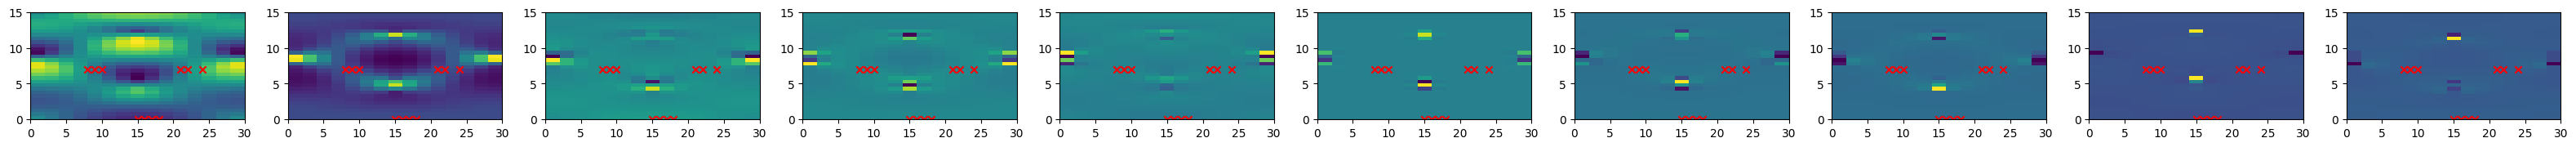

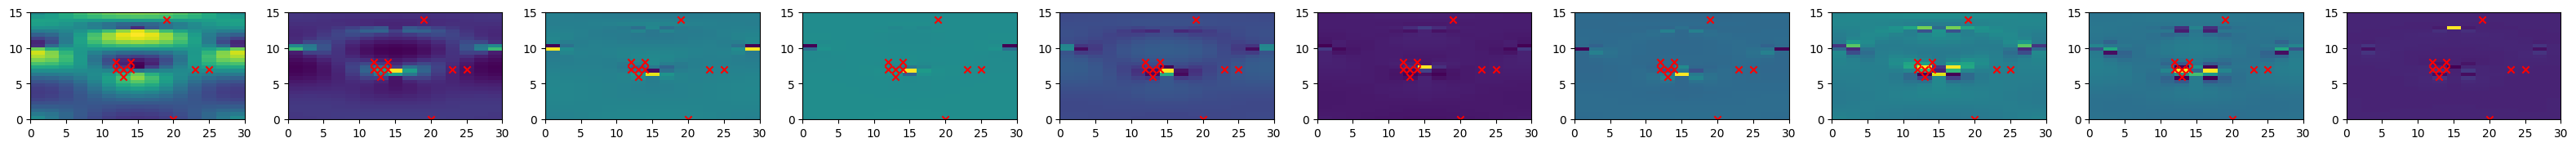

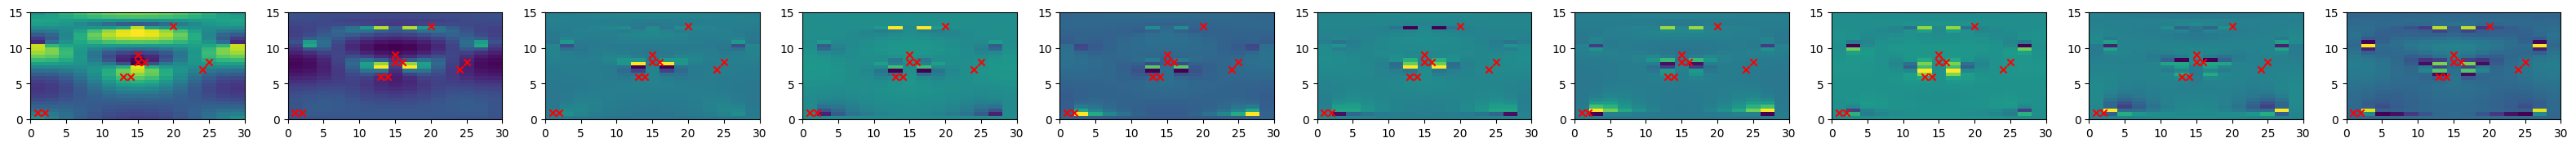

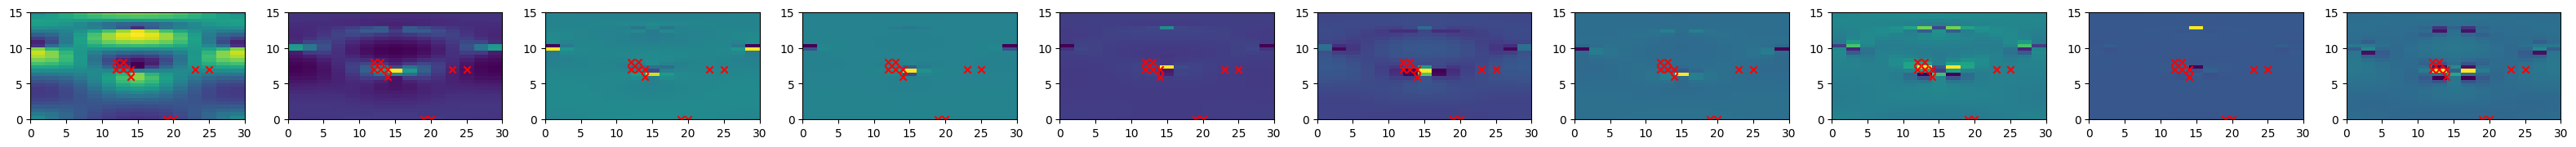

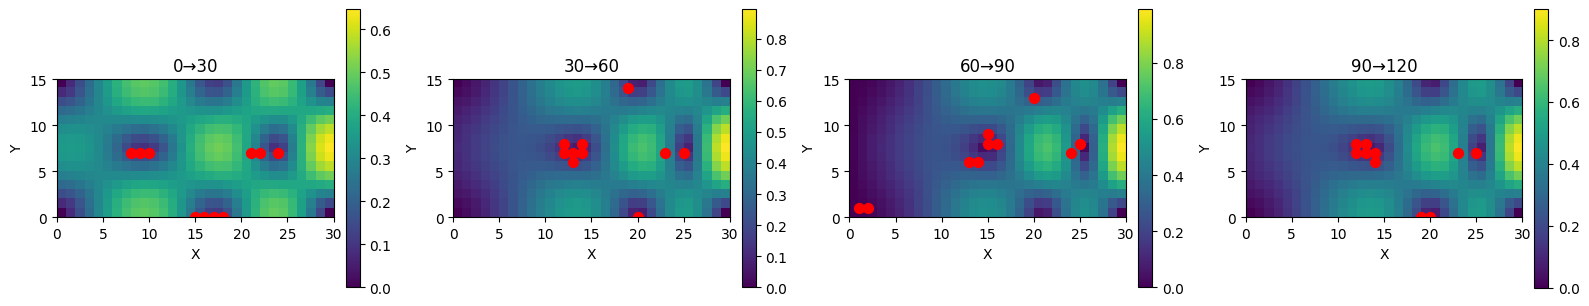

In [97]:
# Assuming interval_length, n_timesteps, n_basis_modes, n_sensors, magnitude, and ps are already defined

intervals = [
    (start, min(start + interval_length, n_timesteps))
    for start in range(0, n_timesteps, interval_length)
]

data = magnitude
_, nx_t, ny_t = data.shape
sensor_coords_list = []

for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]
    # Flatten and demean
    
    X = data_interval.reshape(interval_length, nx_t * ny_t).copy()
    X -= X.mean(axis=0)
    
    # Fit the POD+QR model
    basis = ps.basis.SVD(
        n_basis_modes=n_basis_modes,
        # complex_mode=False,
        algorithm='arpack',
        random_state=90
    )
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)
    try:
        Phi = model.basis.basis_matrix  # shape: (nx_t*ny_t, n_basis_modes)
    except AttributeError:
        Phi = model.basis.components_
    
    Phi = Phi.T
    # Get sensor coordinates for overlay
    sensor_indices = model.selected_sensors
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T
    sensor_coords_list.append(sensor_coords)
    
    n = Phi.shape[1]
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    # Plot each mode as a 2D map
    for m in range(n):
        mode_map = Phi[:, m].reshape(nx_t, ny_t)
        axes[m].imshow(mode_map, origin='lower', extent=[0, nx_t, 0, ny_t])
        axes[m].scatter(sensor_coords[:,0], sensor_coords[:,1], c='r', marker='x', label='Sensors')
    plt.show()


# Optionally, plot sensor trajectories across all intervals
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)


## Velocity Reconstruction

In [98]:
# Feild representation
feild_representation = "complex" # ("complex", "concatenation")

if feild_representation == "concatenation":
    horizontal_concat = False
    data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
elif feild_representation == "complex":
    data = magnitude
    # data = to_complex_cartesian(u_field, v_field) # (to_complex_cartesian, to_complex_polar)

_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

In [99]:
# Interval Params
sliding_intervals = False    # Boolean flag for sliding intervals
window_length, step_size = interval_length, 5    # Params for sliding window

if sliding_intervals:
    intervals = get_sliding_intervals(n_timesteps, window_length, step_size)
else:
    intervals = [
        (start, min(start + interval_length, n_timesteps))
        for start in range(0, n_timesteps, interval_length)
    ]

sensor_coords_list = []
for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]

    # flattens row-wise (but rmr row is a col-strip in our 2d map), so append on the slices of y-axis together
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    sensor_indices, _ = get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=(feild_representation == "complex"))
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T # get index in row-major form by default
    sensor_coords_list.append(sensor_coords)
    


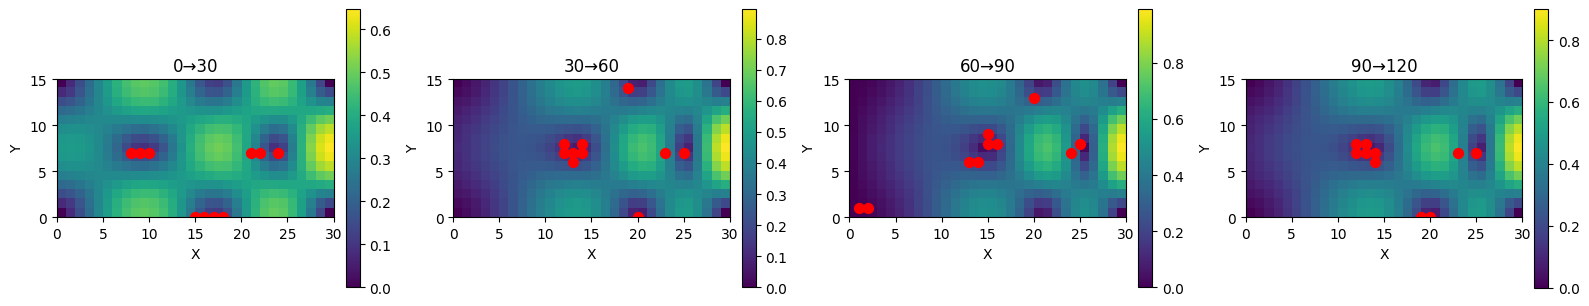

In [100]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

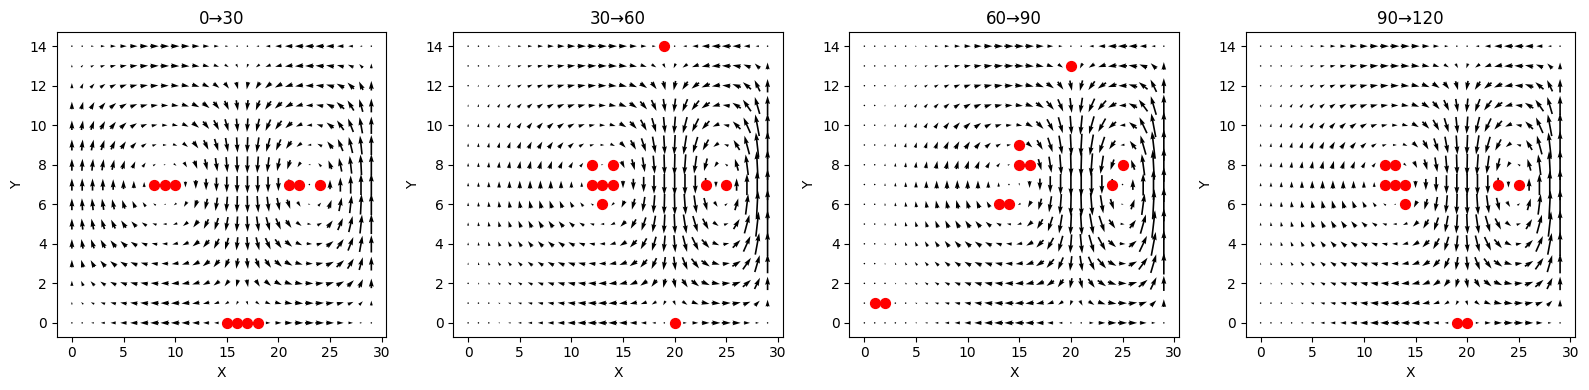

In [101]:
if feild_representation == "concatenation":
    sensor_coords_list = [map_sensor_to_original(sensor_coords, (nx_t, ny_t), horizontal_concat) for sensor_coords in sensor_coords_list]

plot_all_intervals((u_field, v_field), nx, ny, intervals, sensor_coords_list)

# Error Analysis

In [12]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [13]:
rows = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=True)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                # complex_mode=True, 
                                algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_measurements = X[:, sensor_idx]                
    X_pred = model.predict(Y_measurements)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Cart",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


  interval representation  Cartesian RMSE  Polar RMSE
0     0-30    Concat-Cart        0.168257    1.376606
1    30-60    Concat-Cart        0.179643    1.641726
2    60-90    Concat-Cart        0.147269    0.125501
3   90-120    Concat-Cart        0.130405    0.473425


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(


In [14]:
rows   = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(magnitude, angle, horizontal_concat=horizontal_concat)

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=False)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                # complex_mode=False, 
                                algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_measurements = X[:, sensor_idx]                
    X_pred = model.predict(Y_measurements)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X,      nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Polar",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


  interval representation  Cartesian RMSE  Polar RMSE
0     0-30   Concat-Polar        0.393399    0.819755
1    30-60   Concat-Polar        0.444823    0.479732
2    60-90   Concat-Polar        0.435421    0.327485
3   90-120   Concat-Polar        0.483979    1.408375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pysensors/reconstruction/_sspor.py:247: UserWarning: noise is None. noise will be set to the average of the computed prior
  warnings.warn(


# Optical Flow Feild

In [15]:
import cv2
import math
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

In [50]:
def sensors_to_gaussian_img(coords, nx, ny, sigma=1.3, amp=1.0):
    """
    coords : array (n_sensors,2)  -- integer grid indices (i,j)
    nx, ny : grid dimensions
    sigma  : std‑dev of Gaussian (in pixels)
    returns: 2‑D float image of shape (nx, ny)
    """
    img = np.zeros((nx, ny), dtype=np.float32)
    for i, j in coords:
        img[i, j] = amp                          # delta spike
    if sigma > 0:
        img = gaussian_filter(img, sigma=sigma)  # blur into blob
    # normalize so max=1 (helps optical flow)
    img /= img.max() + 1e-9
    return img

In [17]:
def get_farneback_hyperparams(nx, ny,        # grid resolution   (pixels)
                        lx, ly,        # domain size       (same units as velocity)
                        dt,            # time‑step between frames
                        u_max,         # estimate of max |u| in domain units/sec
                        blob_sigma_px, # Gaussian blur sigma used for each sensor (pixels)
                        pyr_scale=0.5  # keep 0.5 
                       ):
    """
    Compute a reasonable Farnebäck parameter dictionary.
    Returns something you can splat straight into calcOpticalFlowFarneback(**params).
    """
    # convert physics to pixel displacements per frame 
    dx = lx / nx  # one pixel in physical units
    disp_px = u_max * dt / dx # max jump in *pixels* per frame

    # pick pyramid depth so residual motion <= 3 px at coarsest
    if disp_px <= 3:
        levels = 1
        residual = disp_px
    else:
        levels = math.ceil(1 + math.log(disp_px / 3, 1 / pyr_scale))
        residual = disp_px * (pyr_scale ** (levels - 1))

    # needs to cover both the blob diameter (≈ 4 sigma) and the residual jump
    winsize = int(2 * max(blob_sigma_px * 2, residual))
    if winsize % 2 == 0: # Farnebäck prefers odd windows
        winsize += 1

    poly_n = 5 if max(nx, ny) < 1000 else 7
    poly_sigma = 1.1 if poly_n == 5 else 1.5

    return dict(pyr_scale=pyr_scale,
                levels=levels,
                winsize=winsize,
                iterations=3,  
                poly_n=poly_n,
                poly_sigma=poly_sigma,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [36]:
def compute_blob_sigma(sensor_coords_list,
                        target_amp=0.3,
                        mode="max"):
    """
    Compute blob sigma so that across ALL timesteps your Gaussian blobs
    overlap at `target_amp` of peak.

    sensor_coords_list : list of (n_sensors,2) arrays or lists of (x,y) tuples
    target_amp         : desired amplitude at neighbor center (0<target_amp<1)
    mode               : "mean" (avg spacing) or "max" (worst-case spacing)
    """
    all_nn_dist = []

    for coords in sensor_coords_list:
        # ensure an (N,2) array of floats
        arr = np.array(coords, dtype=float)
        if arr.ndim != 2 or arr.shape[1] != 2:
            raise ValueError("Each coords entry must be shape (n,2)")

        # build KD-tree & find 2nd neighbor (first is self at zero)
        tree = cKDTree(arr)
        dists, _ = tree.query(arr, k=2)
        nn = dists[:,1] 
        all_nn_dist.append(nn)

    all_nn_dist = np.concatenate(all_nn_dist)

    if mode == "mean":
        d_ref = all_nn_dist.mean()
    elif mode == "max":
        d_ref = all_nn_dist.max()
    else:
        raise ValueError("mode must be 'mean' or 'max'")

    sigma_px = d_ref / math.sqrt(2 * math.log(1/target_amp))
    return sigma_px


In [59]:
def create_optical_flow_field(sensor_coords_list, nx, ny, lx, ly, dt, u_max):
    # 1) blobs
    blob_sigma_px = compute_blob_sigma(sensor_coords_list)  # your function
    frames = [sensors_to_gaussian_img(cs, nx, ny, sigma=blob_sigma_px) for cs in sensor_coords_list]
    frames = np.stack(frames, axis=0)  # (K, nx, ny)

    # 2) Farnebäck params and flow
    fb_params = get_farneback_hyperparams(nx, ny, lx, ly, dt, u_max, blob_sigma_px)
    flows = []
    for k in range(len(frames) - 1):
        f0 = frames[k].astype(np.float32)
        f1 = frames[k + 1].astype(np.float32)
        flow = cv2.calcOpticalFlowFarneback(prev=f0.T, next=f1.T, flow=None, **fb_params)  # (ny,nx,2)
        flows.append(flow.transpose(1, 0, 2))  # -> (nx,ny,2)
    flows = np.stack(flows, axis=0)  # (K-1, nx, ny, 2)

    # quick viz with exact sensor locations (green: t_k, blue: t_{k+1})
    fig, axes = plt.subplots(1, len(flows), figsize=(4*len(flows), 4))
    if len(flows) == 1:
        axes = [axes]

    for k, (ax, img, flow) in enumerate(zip(axes, frames[:-1], flows)):
        ax.imshow(img.T, origin='lower', cmap='gray')

        # quiver of flow (pixels/frame)
        step = max(1, min(nx, ny)//40)
        Xg, Yg = np.meshgrid(np.arange(0, nx, step), np.arange(0, ny, step), indexing='ij')
        U = flow[::step, ::step, 0]
        V = flow[::step, ::step, 1]
        ax.quiver(Xg, Yg, U, V, color='red', alpha=0.9, zorder=2)

        # exact sensors at k (green) and k+1 (blue)
        s_k   = np.asarray(sensor_coords_list[k], dtype=int)     # (N,2) as (i,j)
        s_k1  = np.asarray(sensor_coords_list[k+1], dtype=int)   # (N,2)
        # clamp just in case
        s_k   = s_k[(s_k[:,0]>=0)&(s_k[:,0]<nx)&(s_k[:,1]>=0)&(s_k[:,1]<ny)]
        s_k1  = s_k1[(s_k1[:,0]>=0)&(s_k1[:,0]<nx)&(s_k1[:,1]>=0)&(s_k1[:,1]<ny)]

        ax.scatter(s_k[:,0],  s_k[:,1],  s=28, c='lime',  edgecolors='k', linewidths=0.4,
                label=f'sensors t{k}', zorder=3)
        ax.scatter(s_k1[:,0], s_k1[:,1], s=28, c='yellow', edgecolors='k', linewidths=0.4,
                label=f'sensors t{k+1}', zorder=3)

        ax.set_xlim(-0.5, nx-0.5); ax.set_ylim(-0.5, ny-0.5)
        ax.set_aspect('equal', adjustable='box')
        ax.set_axis_off()
        ax.legend(loc='upper right', fontsize=8, frameon=True)

    plt.tight_layout(); plt.show()


    return frames, flows  # pixels/frame

# Guidance Feild

In [3]:
def build_guidance_field(nx, ny, lx, ly, qr_targets):
    """
    Return u(x,y), v(x,y) arrays whose vectors point toward
    the nearest POD–QR target.
    """
    grid_x = np.linspace(0, lx, nx)
    grid_y = np.linspace(0, ly, ny)

    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij') # shape (nx,ny)
    pos = np.stack([X[..., None], Y[..., None]], axis=-1) # (nx,ny,1,2)

    # qr_targets: array (m,2)
    diff = qr_targets[None, None, :, :] - pos  # (nx,ny,m,2)
    dist2 = np.sum(diff**2, axis=-1)  # (nx,ny,m)

    jstar = np.argmin(dist2, axis=-1)  # nearest target idx
    v = diff[np.arange(diff.shape[0])[:, None],      
             np.arange(diff.shape[1])[None, :,],
             jstar] # (nx,ny,2)

    # cap speed: 20 % of domain per dt
    vmax = 0.2 * lx          
    speed = np.linalg.norm(v, axis=-1, keepdims=True)
    v = v / np.maximum(1, speed/vmax)

    u_field = v[..., 0]
    v_field = v[..., 1]
    return u_field, v_field

In [4]:
import numpy as np
import scipy.ndimage as ndi

def build_guidance_field_edt(nx, ny, lx, ly, qr_targets,
                         smooth_sigma=0.8, vmax_frac=0.20):
    """
    Smooth guidance field that always points to the *nearest* POD–QR
    site but varies continuously in both direction and magnitude.

    Parameters
    ----------
    nx, ny : int
        Grid resolution in x and y.
    lx, ly : float
        Domain lengths (physical units).
    qr_targets : (m,2) array
        Optimal sensor coordinates (x,y).
    smooth_sigma : float
        Gaussian blur (in grid cells) applied to the distance map to
        round the sharp Voronoi edges.  0 disables smoothing.
    vmax_frac : float
        Maximum speed as a fraction of the domain width per time step.

    Returns
    -------
    u_field, v_field : (nx,ny) arrays
        x- and y-components of the guidance velocity.
    """
    # Create a binary mask: False at target cells, True elsewhere
    mask = np.ones((nx, ny), dtype=bool)

    # Convert target coordinates to nearest grid indices
    dx = lx / (nx - 1)
    dy = ly / (ny - 1)
    idx = np.clip(np.round(qr_targets[:, 0] / dx).astype(int), 0, nx - 1)
    idy = np.clip(np.round(qr_targets[:, 1] / dy).astype(int), 0, ny - 1)
    mask[idx, idy] = False # target sites

    # Exact Euclidean distance (physical units) to the nearest target, even on a coarse grid
    edt = ndi.distance_transform_edt(mask, sampling=(dx, dy))

    # smoothing so the gradient turns gently at Voronoi edges
    if smooth_sigma > 0.0:
        edt = ndi.gaussian_filter(edt, smooth_sigma, mode='nearest')

    # Guidance vector: v = −grad(distance)
    # Negative sign descend toward the closest target
    grad_x, grad_y = np.gradient(edt, dx, dy) 
    vx = -grad_x
    vy = -grad_y

    # Scale by distance (so farther cells move faster) and cap speed
    mag = np.hypot(vx, vy) + 1e-12  # avoid divide-by-0
    vx /= mag
    vy /= mag
    speed = edt # proportional to dist
    vmax = vmax_frac * lx # same idea as before
    speed = np.minimum(speed, vmax)
    u_field = vx * speed
    v_field = vy * speed
    return u_field, v_field


In [ ]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

In [ ]:
fig, axes = plt.subplots(1, len(sensor_coords_list), 
                         figsize=(8*len(sensor_coords_list),4))

for sensor_coords, ax in zip(sensor_coords_list, axes):
    u_g, v_g = build_guidance_field_edt(nx_t, ny_t, lx, ly, 
                     grid_to_phys(sensor_coords, nx_t, ny_t, lx, ly))
    skip = 1      # thin quiver for clarity
    X, Y = np.meshgrid(np.arange(0, nx_t, skip), np.arange(0, ny_t, skip), indexing='ij')
    U = u_g[::skip, ::skip];  V = v_g[::skip, ::skip]
    ax.quiver(X, Y, U, V, color='red')
    # ax.set_aspect(ly / lx)

# Sensor Movement Helpers

In [102]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
import pysensors as ps

In [103]:
def grid_to_phys(coords, nx, ny, lx, ly):
    """
    Transform sensor positions from grid indices (i,j) to physical (x,y) coordinates.
    coords : array_like, shape (m,2)
        Integer grid indices [[i1,j1], [i2,j2], ...].

    Returns
    phys_coords : ndarray, shape (m,2)
        Physical coordinates corresponding to each grid index.
    """
    grid_x = np.linspace(0, lx, nx)
    grid_y = np.linspace(0, ly, ny)
    coords = np.asarray(coords, dtype=int)
    i_idx, j_idx = coords[:,0], coords[:,1]
    x_phys = grid_x[i_idx]
    y_phys = grid_y[j_idx]
    return np.column_stack([x_phys, y_phys])

In [104]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [105]:
SEED = 42
rng = np.random.default_rng(SEED)

TOTAL_STEPS = 120
NX, NY = 30, 15
LX, LY = 2.0, 1.0
PERIOD = 300

num_sensors = 12
WINDOW_LEN = 30
MAX_BASIS_DIM = 12
num_cv_folds = 3

In [106]:
def linspace_interior(length, n, pad_frac=0.15):
    return np.linspace(pad_frac * length, (1 - pad_frac) * length, n)


def  seed_sensor_grid(n, Lx, Ly):
    gx = int(np.sqrt(n * Lx / Ly))
    gy = int(np.ceil(n / gx))
    xs, ys = linspace_interior(Lx, gx), linspace_interior(Ly, gy)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    return np.column_stack([xv.ravel(), yv.ravel()])[:n]

def advect(points, u, v, Lx, Ly, dt=1.0, periodic=False):
    """
    Advect points through the velocity field (u, v).

    Parameters
    ----------
    points : array_like, shape (n_points, 2)
        Coordinates of points to advect.
    u, v : array_like, shape (NX, NY)
        Velocity field components on a regular grid.
    Lx, Ly : float
        Domain lengths in x and y.
    dt : float
        Time step size.
    periodic : bool, optional
        If True, apply periodic boundary conditions (wrap around).
        If False, clip points to the domain [0, Lx] × [0, Ly].

    Returns
    -------
    pts_new : ndarray, shape (n_points, 2)
        Updated point coordinates after advection.
    """
    if periodic:
        gx = np.linspace(0, Lx, u.shape[0], endpoint=False)
        gy = np.linspace(0, Ly, u.shape[1], endpoint=False)
    else:
        gx = np.linspace(0, Lx, u.shape[0])
        gy = np.linspace(0, Ly, u.shape[1])

    Ui = RegularGridInterpolator((gx, gy), u, bounds_error=False, fill_value=None)
    Vi = RegularGridInterpolator((gx, gy), v, bounds_error=False, fill_value=None)

    P = points.copy()

    # 1) wrap BEFORE sampling so interpolation is periodic-consistent
    if periodic:
        P[:, 0] = np.mod(P[:, 0], Lx)
        P[:, 1] = np.mod(P[:, 1], Ly)

    # sample velocities
    vel = np.stack([Ui(P), Vi(P)], axis=1)

    # forward Euler step
    P_new = P + dt * vel

    # 2) wrap AFTER stepping to keep positions in [0, Lx) × [0, Ly)
    if periodic:
        P_new[:, 0] = np.mod(P_new[:, 0], Lx)
        P_new[:, 1] = np.mod(P_new[:, 1], Ly)
    else:
        P_new[:, 0] = np.clip(P_new[:, 0], 0.0, Lx)
        P_new[:, 1] = np.clip(P_new[:, 1], 0.0, Ly)

    return P_new


def coords_to_linear_index(points, nx, ny,
                           Lx, Ly):
    i = np.clip(np.round(points[:, 0] / Lx * (nx - 1)).astype(int), 0, nx - 1)
    j = np.clip(np.round(points[:, 1] / Ly * (ny - 1)).astype(int), 0, ny - 1)
    return np.ravel_multi_index((i, j), (nx, ny))

In [107]:
def fourier_basis(nx, ny, kx, ky, cap=MAX_BASIS_DIM):
    """kx is the number of (sin, cos) pair in x direction; similar with ky"""
    xs, ys = np.linspace(0, 1, nx, endpoint=False), np.linspace(
        0, 1, ny, endpoint=False)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    g = np.column_stack([xv.ravel(), yv.ravel()])
    cols = [np.ones(nx*ny)]
    for m in range(1, kx+1):
        cols += [np.cos(2*np.pi*m*g[:, 0]), np.sin(2*np.pi*m*g[:, 0])]
    for n in range(1, ky+1):
        cols += [np.cos(2*np.pi*n*g[:, 1]), np.sin(2*np.pi*n*g[:, 1])]
    return np.column_stack(cols)[:, :cap]


def fourier2d_basis(nx, ny, kx, ky, cap=MAX_BASIS_DIM, order="radial"):
    """
    Build a full 2‑D Fourier dictionary on [0,1]^2.

    Parameters
    ----------
    nx, ny : int
        Number of grid points in x and y.
    kx, ky : int
        Maximum integer frequencies |m| ≤ kx and |n| ≤ ky (inclusive).
    cap : int or None, optional
        If not None, keep only the first `cap` columns.
    order : {"radial", "lex"}, optional
        * "radial": sort modes by increasing sqrt(m**2 + n**2).
        * "lex":    (m,n) nested loops, standard lexicographic order.

    Returns
    -------
    Phi : ndarray, shape (nx*ny, num_modes)
        Flattened design matrix whose columns are
        [1, cos(2π(mx+ny)), sin(2π(mx+ny)), ...].
    mode_indices : list[tuple]
        List of (kind, m, n) triples: kind ∈ {"1", "c", "s"}.
        Useful for inspecting which column is which.
    """
    # grid coordinates (periodic [0,1) so endpoint=False)
    xs = np.linspace(0, 1, nx, endpoint=False)
    ys = np.linspace(0, 1, ny, endpoint=False)
    xv, yv = np.meshgrid(xs, ys, indexing="ij") # shape (nx, ny)
    grid  = np.column_stack([xv.ravel(), yv.ravel()]) # (nx*ny, 2)

    cols, meta = [], []  # design matrix + bookkeeping
    cols.append(np.ones(nx * ny)) # constant mode
    meta.append(("1", 0, 0))

    # generate all (m,n) pairs (skip (0,0))
    pairs = [(m, n)
             for m in range(-kx, kx + 1)
             for n in range(-ky, ky + 1)
             if not (m == 0 and n == 0)]

    if order == "radial": # sort by Euclidean magnitude, then lex
        pairs.sort(key=lambda mn: (mn[0] ** 2 + mn[1] ** 2, mn[0], mn[1]))
    else: # "lex": keep generator order
        pairs.sort(key=lambda mn: (mn[0], mn[1]))

    # build cos / sin columns
    for m, n in pairs:
        phase = 2 * np.pi * (m * grid[:, 0] + n * grid[:, 1])
        cols.append(np.cos(phase))
        meta.append(("c", m, n))
        cols.append(np.sin(phase))
        meta.append(("s", m, n))

        if cap is not None and len(cols) >= cap:
            break

    Phi = np.column_stack(cols)[:, :cap] if cap else np.column_stack(cols)
    meta = meta[:Phi.shape[1]]
    return Phi, meta



def polynomial_basis(nx, ny, deg, cap=MAX_BASIS_DIM):
    xs, ys = np.linspace(-1, 1, nx), np.linspace(-1, 1, ny)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    phi_full = PolynomialFeatures(degree=deg, include_bias=True).fit_transform(
        np.column_stack([xv.ravel(), yv.ravel()]))
    return phi_full[:, :cap]


def rbf_basis(nx, ny, sigma, cap=MAX_BASIS_DIM):
    xs, ys = np.linspace(0, 1, nx), np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    grid = np.column_stack([xv.ravel(), yv.ravel()])
    rng = np.random.default_rng(SEED)
    centres = rng.uniform(0, 1, size=(cap, 2))
    dist2 = np.sum((grid[:, None, :]-centres[None, :, :])**2, axis=2)
    return np.exp(-dist2/(2*sigma**2))

In [108]:
from sklearn.model_selection import TimeSeriesSplit

def cv_rmse(basis,
            Y_u,
            Y_v,
            sensor_index,
            num_cv_folds=1):
    """
    Cross-validated RMSE for a candidate basis phi.

    If num_cv_folds == 1, returns the RMSE on the full dataset
    (no cross-validation).

    Parameters
    ----------
    basis : (N, m) array
        Columns are m basis functions sampled on the grid.
    Y_u, Y_v : (T, p) arrays
        Measured u, v at the p chosen sensors for T snapshots.
    sensor_index : (p,) int array
        Indices of the p sensors in row-major grid ordering.
    num_cv_folds : int, default 4
        Number of time-series CV splits; if 1, evaluate on full data.
    """
    C = np.eye(basis.shape[0])[sensor_index]
    pinv = np.linalg.pinv(C @ basis)

    def _rmse_on(idx):
        a_u = Y_u[idx] @ pinv.T
        a_v = Y_v[idx] @ pinv.T
        X_u_hat = a_u @ basis.T
        X_v_hat = a_v @ basis.T
        return 0.5 * np.sqrt(
            np.mean((Y_u[idx] - X_u_hat[:, sensor_index])**2) +
            np.mean((Y_v[idx] - X_v_hat[:, sensor_index])**2)
        )

    # If only one fold, evaluate on the full dataset
    if num_cv_folds <= 1:
        idx_all = np.arange(Y_u.shape[0])
        return float(_rmse_on(idx_all))

    # Otherwise do time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=num_cv_folds)
    errs = []
    for _, test_idx in tscv.split(Y_u):
        errs.append(_rmse_on(test_idx))

    return float(np.mean(errs))


In [109]:
def tune_pod(u_interval, v_interval, n_modes=MAX_BASIS_DIM, seed=SEED):
    """
    Compute a POD basis (separately for u and v) on the current window.
    """
    pod_u = ps.basis.SVD(n_basis_modes=n_modes,
                        #  complex_mode=False,
                         algorithm="arpack",
                         random_state=seed)
    pod_u.fit(u_interval)

    pod_v = ps.basis.SVD(n_basis_modes=n_modes,
                        #  complex_mode=False,
                         algorithm="arpack",
                         random_state=seed)
    pod_v.fit(v_interval)

    phi_u = pod_u.basis_matrix_
    phi_v = pod_v.basis_matrix_
    return phi_u, phi_v


def tune_fourier(nx, ny, sensor_index, Yu, Yv):
    # full range of wavenumbers you could possibly use -- using nyquist thm
    max_kx = nx // 2
    max_ky = ny // 2

    all_pairs = [(kx, ky)
                 for kx in range(1, max_kx + 1)
                 for ky in range(1, max_ky + 1)]

    # sort them by total frequency (asc)
    all_pairs.sort(key=lambda t: (t[0] + t[1], t[0], t[1]))

    # pick 10 evenly spaced indices from that sorted list
    n_candidates = len(all_pairs)
    step = max(1, n_candidates // 10)
    selected_pairs = [all_pairs[i] for i in range(0, n_candidates, step)][:10]

    best = None
    for kx, ky in selected_pairs:
        phi, _ = fourier2d_basis(nx, ny, kx, ky)
        err = cv_rmse(phi, Yu, Yv, sensor_index)
        tag = f"Fourier({kx},{ky})"
        if best is None or err < best[0]:
            best = (err, phi, tag)

    return best[1], best[2]


def tune_poly(nx, ny, sensor_index, Yu, Yv, cap=MAX_BASIS_DIM):
    # Compute max polynomial degree; theres at most (d+2)C2
    max_terms = min(cap, nx*ny)
    d_max = min(int(np.floor((np.sqrt(8*max_terms + 1) - 3) / 2)), 5)
    degs = np.unique(np.linspace(1, d_max, num=min(d_max, 10), dtype=int))

    candidates = []
    for d in degs:
        phi = polynomial_basis(nx, ny, d, cap=cap)
        err = cv_rmse(phi, Yu, Yv, sensor_index)
        candidates.append((err, phi, f"Poly deg={d}"))

    return min(candidates, key=lambda t: t[0])[1:]


def tune_rbf(nx, ny, sensor_index, Yu, Yv):
    cand = []
    for sigma in [0.05, 0.1, 0.15, 0.25]:
        phi = rbf_basis(nx, ny, sigma)
        cand.append((cv_rmse(phi, Yu, Yv, sensor_index),
                    phi, f"RBF sigma={sigma}"))
    return min(cand, key=lambda t: t[0])[1:]

In [110]:
def bounce_apart(coords, min_dist, lx, ly):
    """
    If any two probes are closer than min_dist, push them straight
    away from each other just enough to meet min_dist.
    """
    p = len(coords)
    for i in range(p):
        for j in range(i+1, p):
            dx = coords[i,0] - coords[j,0]
            dy = coords[i,1] - coords[j,1]

            # shortest periodic displacement
            dx = (dx + lx/2) % lx - lx/2
            dy = (dy + ly/2) % ly - ly/2
            dist = np.hypot(dx, dy)

            if dist < 1e-12: # exactly same point – random nudge
                dx, dy, dist = 1e-6, 0, 1e-6

            if dist < min_dist:
                overlap = 0.5 * (min_dist - dist)
                # normalised direction
                ux, uy = dx/dist, dy/dist
                # move i one way, j the opposite
                coords[i,0] +=  overlap*ux
                coords[i,1] +=  overlap*uy
                coords[j,0] -=  overlap*ux
                coords[j,1] -=  overlap*uy

    # keep inside domain
    coords[:, 0] = np.clip(coords[:, 0], 0.0, lx)
    coords[:, 1] = np.clip(coords[:, 1], 0.0, ly)

    return coords


In [111]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_distance(A, B):
    """
    Compute optimal assignment between 2D point sets A and B using the Hungarian algorithm.
    Returns:
      total_dist
    """
    # Build the cost matrix of pairwise Euclidean distances
    cost_matrix = np.linalg.norm(A[:, None, :] - B[None, :, :], axis=2)
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Extract distances for the matched pairs
    dists = cost_matrix[row_ind, col_ind]
    total_dist = dists.sum()
    
    return total_dist


In [112]:

def _periodic_delta(p, q, L):
    """Signed shortest displacement from p to q on a 1‑D ring of length L."""
    d = q - p
    d[d >  +L/2] -= L
    d[d <  -L/2] += L
    return d

def guidance_field_hungarian(nx, ny, lx, ly,
                             curr_pts, opt_pts,
                             v_max,
                             periodic=False):
    """
    Build a sparse guidance field whose non‑zero entries sit on the current
    sensor locations.  Sensors are assigned to optimal sites via Hungarian,
    then moved a fraction alpha of the remaining distance (capped).

    Parameters
    ----------
    nx, ny : int
        Grid resolution.
    lx, ly : float
        Physical domain dimensions.
    curr_pts, opt_pts : (N,2) float arrays
        Current and optimal sensor coordinates (same length N).
    alpha : 0<alpha<=1
        Fraction of the gap covered in one step.
    vmax_frac : float
        Maximum speed as fraction of domain width per step.
    periodic : bool
        If True, domain is treated as doubly‑periodic; distances wrap.

    Returns
    -------
    u_field, v_field : (nx,ny) float arrays
        Guidance velocities; zero elsewhere.
    """
    curr_pts = np.asarray(curr_pts, float)
    opt_pts  = np.asarray(opt_pts,  float)
    N = curr_pts.shape[0]

    # --- 1. Cost matrix with periodic option ----------------------------------
    if periodic:
        dx = np.abs(curr_pts[:, None, 0] - opt_pts[None, :, 0])
        dy = np.abs(curr_pts[:, None, 1] - opt_pts[None, :, 1])
        dx = np.minimum(dx, lx - dx)   # wrap in x
        dy = np.minimum(dy, ly - dy)   # wrap in y
        C  = np.hypot(dx, dy)
    else:
        C = np.linalg.norm(curr_pts[:, None, :] - opt_pts[None, :, :], axis=2)

    row_idx, col_idx = linear_sum_assignment(C)
    pairs = list(zip(row_idx, col_idx))
    disp  = opt_pts[col_idx] - curr_pts[row_idx]      # raw displacement

    if periodic:
        # shortest signed displacement on the torus
        disp[:, 0] = _periodic_delta(curr_pts[row_idx, 0],
                                     opt_pts[col_idx, 0], lx)
        disp[:, 1] = _periodic_delta(curr_pts[row_idx, 1],
                                     opt_pts[col_idx, 1], ly)

    # --- 2. total distance before motion --------------------------------------
    dist_vec   = np.linalg.norm(disp, axis=1)
    total_dist = dist_vec.sum()

    # --- 3. desired velocities (capped) ---------------------------------------
    alpha=1.0
    speed_desired = alpha * dist_vec
    speed         = np.minimum(speed_desired, v_max)

    unit = disp / (dist_vec[:, None] + 1e-12)  # avoid /0
    vel  = unit * speed[:, None]               # (N,2)

    # --- 4. sparse field on grid ----------------------------------------------
    u_field = np.zeros((nx, ny), float)
    v_field = np.zeros((nx, ny), float)

    dxg = lx / (nx - 1)
    dyg = ly / (ny - 1)
    gi  = np.clip(np.round(curr_pts[row_idx, 0] / dxg).astype(int), 0, nx-1)
    gj  = np.clip(np.round(curr_pts[row_idx, 1] / dyg).astype(int), 0, ny-1)

    np.add.at(u_field, (gi, gj), vel[:, 0])
    np.add.at(v_field, (gi, gj), vel[:, 1])

    return u_field, v_field

def advect_hungarian(curr_pts, opt_pts, Lx, Ly,
                     v_max, dt=1.0, periodic=False, alpha=1.0):
    """
    Move probes toward optimal locations using Hungarian assignment.

    Parameters
    ----------
    curr_pts : (N, 2) ndarray
        Current probe coordinates.
    opt_pts  : (N, 2) ndarray
        Desired probe coordinates (e.g. QR‑selected sensors).
    Lx, Ly   : float
        Domain sizes.
    v_max    : float
        Maximum allowed probe speed (same units as velocity field).
    dt       : float, default 1.0
        Physical time‑step.
    periodic : bool, default False
        Treat domain as periodic.
    alpha    : float, default 1.0
        Fraction (0–1] of the distance to cover in one step before capping.

    Returns
    -------
    new_pts  : (N, 2) ndarray
        Updated probe coordinates.
    """

    curr_pts = np.asarray(curr_pts, dtype=float)
    opt_pts  = np.asarray(opt_pts,  dtype=float)
    N        = curr_pts.shape[0]

    # -- 1. Hungarian assignment ----------------------------------------------
    if periodic:
        # cost matrix using wrapped distances
        dx = np.abs(curr_pts[:, None, 0] - opt_pts[None, :, 0])
        dy = np.abs(curr_pts[:, None, 1] - opt_pts[None, :, 1])
        dx = np.minimum(dx, Lx - dx)
        dy = np.minimum(dy, Ly - dy)
        C  = np.hypot(dx, dy)
    else:
        C = np.linalg.norm(curr_pts[:, None, :] - opt_pts[None, :, :], axis=2)

    rows, cols = linear_sum_assignment(C)
    disp = opt_pts[cols] - curr_pts[rows]           # raw displacement (N,2)

    if periodic:                                    # shortest wrapped vector
        disp[:, 0] = _periodic_delta(curr_pts[rows, 0], opt_pts[cols, 0], Lx)
        disp[:, 1] = _periodic_delta(curr_pts[rows, 1], opt_pts[cols, 1], Ly)

    # -- 2. step length capped by v_max ----------------------------------------
    dist      = np.linalg.norm(disp, axis=1)        # remaining gap
    step_len  = np.minimum(alpha * dist, v_max * dt)
    step_vec  = disp * (step_len / (dist + 1e-12))[:, None]   # avoid /0

    # -- 3. update positions ---------------------------------------------------
    new_pts = curr_pts.copy()
    new_pts[rows] += step_vec                       # preserve original order

    if periodic:
        new_pts[:, 0] = np.mod(new_pts[:, 0], Lx)
        new_pts[:, 1] = np.mod(new_pts[:, 1], Ly)
    else:
        new_pts[:, 0] = np.clip(new_pts[:, 0], 0.0, Lx)
        new_pts[:, 1] = np.clip(new_pts[:, 1], 0.0, Ly)

    return new_pts

In [113]:
def expand_to_uv(node_indices, grid_N):
    """
    Take a 1‑D array of physical node indices (0 … grid_N‑1)
    and return the combined indices for both u and v components.
    """
    node_indices = np.asarray(node_indices, dtype=int)
    return np.sort(np.unique(
        np.concatenate([node_indices, node_indices + grid_N])
    ))

In [114]:
def seed_uniform_random(num_sensors, lx, ly):
    SEED = 42
    rng = np.random.default_rng(SEED)
    return np.column_stack([rng.uniform(0, lx,  num_sensors),
                            rng.uniform(0, ly,  num_sensors)])

In [115]:
def run_experiment_sliding_random(u, v,
                           window_len, step_size=1,
                           min_dist_pct=0.05,
                           n_trials=3, seed=42, ):
    rng  = np.random.default_rng(seed)
    T, NX, NY = u.shape
    grid_N    = NX*NY
    intervals = get_sliding_intervals(T, window_len + 1, step_size)
    records   = []

    for trial in range(n_trials):

        # five initial sensor sets 
        euler_loc = seed_uniform_random(num_sensors, LX, LY)
        lag_loc   = euler_loc.copy()
        hung_loc  = euler_loc.copy()
        edt_loc   = euler_loc.copy()

        plt.figure(figsize=(4,4))
        plt.scatter(euler_loc[:,0], euler_loc[:,1],
                    c='black', s=40, edgecolor='white')
        plt.xlim(0, LX); plt.ylim(0, LY)
        plt.title(f'Trial {trial+1}: initial sensors')
        plt.xlabel('x'); plt.ylabel('y')
        plt.tight_layout()
        plt.show()

        for w,(s,e) in enumerate(tqdm(intervals,
                          desc=f"trial {trial+1}/{n_trials}")):

            # POD-QR on the window
            Xu = u[s:e-1].reshape(e-s-1, -1); Xv = v[s:e-1].reshape(e-s-1, -1)
            Xfull = np.concatenate([Xu, Xv], axis=1)
            pbasis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                                  algorithm="arpack", random_state=0)
            qr     = ps.SSPOR(n_sensors=num_sensors, basis=pbasis).fit(Xfull)
            qr_idx = qr.selected_sensors
            ij     = np.column_stack(np.unravel_index(qr_idx%grid_N,(NX,NY)))
            qr_phys= grid_to_phys(ij, NX, NY, LX, LY)

            # latest true slice 
            x_u_last = u[e-1].reshape(1,-1)
            x_v_last = v[e-1].reshape(1,-1)

            # Hungarian guidance
            u_h, v_h = guidance_field_hungarian(
                NX,NY,LX,LY,hung_loc,qr_phys,alpha=1,vmax_frac=0.2)
            # EDT guidance 
            u_e, v_e   = build_guidance_field_edt(
                NX,NY,LX,LY,qr_phys,smooth_sigma=0.8,vmax_frac=0.2)

            # one-step advection for each moving set 
            lag_loc  = bounce_apart(
                advect(lag_loc,  u[e-2], u[e-2],LX,LY,1.0), # last one is for testing for testing only so use 2nd last one 
                min_dist_pct*LX, LX, LY)
            hung_loc = advect(hung_loc, u_h, v_h, LX, LY, 1.0)
            edt_loc  = bounce_apart(
                advect(edt_loc, u_e, v_e,      LX,LY,1.0),
                min_dist_pct*LX, LX, LY)

            # POD basis for reconstruction 
            phi_u, phi_v = tune_pod(Xu,Xv)

            Phi_combo = qr.basis_matrix_    # shape (r, 2*grid_N)
            Yq_last   = np.concatenate([x_u_last, x_v_last], axis=1) 

            def qr_recon_rmse(qr_idx_full):
                """Reconstruct with the *combined* basis PBASIS."""
                sidx = np.unique(qr_idx_full)         # already 0..2*grid_N-1
                Cq   = np.eye(2*grid_N)[sidx]
                pinv = np.linalg.pinv(Cq @ Phi_combo)         # (r x r) inverse
                xhat_concat = (Yq_last[:, sidx] @ pinv.T) @ Phi_combo.T
                u_hat, v_hat = np.split(xhat_concat, 2, axis=1)
                return 0.5*(rmse(x_u_last, u_hat) + rmse(x_v_last, v_hat))
            

            def recon_rmse(coords=None, force_idx=None):
                """
                If force_idx is given (QR teleport case), use those indices after
                folding them back into 0 … grid_N-1.  Otherwise convert coords→idx.
                """
                sidx = np.unique(coords_to_linear_index(coords,
                                                        NX, NY, LX, LY))

                Csmall = np.eye(grid_N)[sidx]
                pinv_u = np.linalg.pinv(Csmall @ phi_u)
                pinv_v = np.linalg.pinv(Csmall @ phi_v)
                xhat_u = (x_u_last[:, sidx] @ pinv_u.T) @ phi_u.T
                xhat_v = (x_v_last[:, sidx] @ pinv_v.T) @ phi_v.T
                return 0.5*(rmse(x_u_last, xhat_u) + rmse(x_v_last, xhat_v))

            # Log RMSEs for the five placements
            records.extend([
                dict(trial=trial, window=w, placement="Euler",
                    RMSE=qr_recon_rmse(coords_to_linear_index(euler_loc,
                                                        NX, NY, LX, LY))),
                dict(trial=trial, window=w, placement="Lag",
                    RMSE=qr_recon_rmse(coords_to_linear_index(lag_loc,
                                                        NX, NY, LX, LY))),
                dict(trial=trial, window=w, placement="Hungarian",
                    RMSE=qr_recon_rmse(coords_to_linear_index(hung_loc,
                                                        NX, NY, LX, LY))),
                dict(trial=trial, window=w, placement="EDT",
                    RMSE=qr_recon_rmse(coords_to_linear_index(edt_loc,
                                                        NX, NY, LX, LY))),
                dict(trial=trial, window=w, placement="QR teleport",
                    RMSE=qr_recon_rmse(qr_idx))   # use exact indices
            ])

    results = pd.DataFrame(records)

    # box-plot of RMSE by placement 
    plt.figure(figsize=(8,4))
    results.boxplot(column='RMSE', by='placement',
                    vert=False, grid=False, showfliers=True,
                    whis=[5,95])
    plt.suptitle(""); plt.xlabel("RMSE across windows & trials")
    plt.xscale("log")
    plt.tight_layout(); plt.show()
    return results

In [116]:

def run_experiment_sliding(u, v,
                           window_len=30, step_size=1,
                           min_dist_pct=0.05,dt=1, periodic=False, return_paths=False):
    """
    u, v             : full velocity snapshots (T, NX, NY)
    window_len       : length of sliding POD window   (e.g. 30)
    step_size        : shift between windows          (e.g. 1)
    min_dist_pct     : probe–probe minimum spacing as % of LX
    """
    TOTAL_STEPS = u.shape[0]
    grid_N = NX * NY

    intervals = get_sliding_intervals(TOTAL_STEPS, window_len + 1, step_size) # window_len + 1, + 1 for test

    # initial probe positions 
    # rng  = np.random.default_rng(123)
    # lag_loc   = seed_uniform_random(num_sensors, LX, LY, rng)  # passive probes
    if return_paths:
        lag_hist  = []       
        hung_hist = []
        hung_heading_hist = []   # (W, num_sensors, 2) heading velocity
        hung_flow_hist    = []   # (W, num_sensors, 2) flow velocity at sensor coords

    lag_loc = seed_sensor_grid(num_sensors, LX, LY)
    guide_loc = lag_loc.copy()                          # active probes
    ortho_loc = lag_loc.copy()                          # orthogonal probes

    # fixed split: first half = left (+90°), second half = right (−90°) ---
    sigma = np.ones(num_sensors, dtype=int)
    sigma[num_sensors // 2:] = -1 


    records = []

    v_max = np.max(np.hypot(u, v))
    print("median speed:", v_max)
    
    fig, axes = plt.subplots(1, len(intervals), figsize=(8*(LX/(LX+LY))*len(intervals), 8*(LY/(LX+LY))))

    for w, (s, e) in enumerate(tqdm(intervals, desc="windows")):
        if return_paths:
            lag_hist.append(lag_loc.copy())
            hung_hist.append(guide_loc.copy())
        # Window data (POD uses the whole window)
        Xu = u[s:e-1].reshape(e-s-1, -1) # (window_len, grid_N)
        Xv = v[s:e-1].reshape(e-s-1, -1)

        # latest slice (index e‑1) for RBF / Fourier / Poly error calc
        x_last_u = u[e-1].reshape(1, -1) # shape (1, grid_N)
        x_last_v = v[e-1].reshape(1, -1)

        
        # POD‑QR on the window
        uv_concat = np.concatenate([Xu, Xv], axis=1)
        pod_basis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                                 algorithm="arpack",
                                 random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(uv_concat)

        qr_idx = qr_model.selected_sensors              
        qr_grid_idx = np.mod(qr_idx, grid_N) # wrap around to grid indices      
        qr_idx_uv  = expand_to_uv(qr_grid_idx, grid_N) 

        ij = np.column_stack(np.unravel_index(qr_grid_idx, (NX, NY)))
        qr_phys = grid_to_phys(ij, NX, NY, LX, LY)

        # QR reconstruction RMSE on the latest slice
        C = np.eye(grid_N*2)[qr_idx_uv]       
        pinv = np.linalg.pinv(C @ qr_model.basis_matrix_)

        Yq_last = np.concatenate([x_last_u, x_last_v], axis=1)[:, qr_idx_uv]
        concat_pred_last = (Yq_last @ pinv.T) @ qr_model.basis_matrix_.T
        u_pred_last, v_pred_last = np.split(concat_pred_last, 2, axis=1)

        rmse_qr = 0.5 * (rmse(x_last_u, u_pred_last) +
                        rmse(x_last_v, v_pred_last))

        records.append(dict(window=w,
                            placement="QR",
                            basis="POD",
                            RMSE=rmse_qr))

    

        if True:  # for plotting sensors
            x = np.linspace(0, LX, NX)
            y = np.linspace(0, LY, NY)
            step=4
            Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

            u_grid = u[e-2].reshape(NX, NY)
            v_grid = v[e-2].reshape(NX, NY)
            axes[w].set_xlim(0, LX)
            axes[w].set_ylim(0, LY)
            axes[w].set_aspect('equal', adjustable='box')

            axes[w].quiver(Xgrid[::step, ::step], Ygrid[::step, ::step], u_grid[::step, ::step], v_grid[::step, ::step], color='black',
                                        scale_units='xy', scale=None, width=0.0025, pivot='mid')

            axes[w].scatter(guide_loc[:,0], guide_loc[:,1],
                                        color='blue', s=50, marker='o', label='actual')
            
            axes[w].scatter(ortho_loc[:,0], ortho_loc[:,1],
                            color='red', s=50, marker='o', label='target')
            axes[w].scatter(lag_loc[:,0], lag_loc[:,1],
                            color='green', s=50, marker='o', label='target')
            
            # plt.show()


        # Prepare sensor‑index bundles
        if w == 0: # Eulerian probes fixed only once
            euler_idx = coords_to_linear_index(lag_loc, NX, NY, LX, LY)

        lag_idx   = coords_to_linear_index(lag_loc,   NX, NY, LX, LY)
        guid_idx  = coords_to_linear_index(guide_loc, NX, NY, LX, LY)
        ortho_idx   = coords_to_linear_index(ortho_loc,   NX, NY, LX, LY)
        bundles = {"Euler": euler_idx,
                   "Lag":   lag_idx,
                   "Hungarian": guid_idx,
                   "Ortho": ortho_idx}

        # Fit bases & compute RMSE only on latest slice
        for label, sidx in bundles.items():
            Yu_last = u[e-1].reshape(1, -1)[:, sidx]      
            Yv_last = v[e-1].reshape(1, -1)[:, sidx]

            # phi_four, _ = tune_fourier(NX, NY, sidx, Yu_last, Yv_last)
            # phi_poly, _ = tune_poly(NX, NY, sidx, Yu_last, Yv_last)
            # phi_rbf, _ = tune_rbf(NX, NY, sidx, Yu_last, Yv_last)

            # for tag, (Phi_u, Phi_v) in {
            #     "Fourier":    (phi_four,  phi_four),
            #     "Polynomial": (phi_poly,  phi_poly),
            #     "RBF":        (phi_rbf,   phi_rbf),
            # }.items():
            #     Csmall = np.eye(grid_N)[sidx]
            #     pinv_u = np.linalg.pinv(Csmall @ Phi_u)
            #     pinv_v = np.linalg.pinv(Csmall @ Phi_v)

            #     xhat_u = (Yu_last @ pinv_u.T) @ Phi_u.T 
            #     xhat_v = (Yv_last @ pinv_v.T) @ Phi_v.T

            #     err = 0.5*(rmse(x_last_u, xhat_u) + rmse(x_last_v, xhat_v))
            #     records.append(dict(window=w,
            #                         placement=label,
            #                         basis=tag,
            #                         RMSE=float(err)))
                
            Phi_combo = qr_model.basis_matrix_    # shape (r, 2*grid_N)
            Yq_last   = np.concatenate([x_last_u, x_last_v], axis=1) 
            sidx_uv  = expand_to_uv(sidx, grid_N) 
            Cq  = np.eye(2*grid_N)[sidx_uv]
            pinv = np.linalg.pinv(Cq @ Phi_combo)         # (r x r) inverse
            xhat_concat = (Yq_last[:, sidx_uv] @ pinv.T) @ Phi_combo.T
            u_hat, v_hat = np.split(xhat_concat, 2, axis=1)
            err = 0.5*(rmse(x_last_u, u_hat) + rmse(x_last_v, v_hat))
            records.append(dict(window=w,
                                placement=label,
                                basis="POD",
                                RMSE=float(err)))
 
        # ADVECT probes one step (flow of latest slice or guidance)
        # print(hungarian_distance(guide_loc, qr_phys))
        # Lagrangian: true flow at time e‑2
        lag_loc = advect(lag_loc, u[e-2], v[e-2], LX, LY, dt=dt, periodic=periodic)
        lag_loc = bounce_apart(lag_loc, min_dist_pct*LX, LX, LY)

        # guidance field evaluated at grid + repulsion step
        
        u_grid = u[e-2].reshape(NX, NY)
        v_grid = v[e-2].reshape(NX, NY)

        grid_x = np.linspace(0, LX, NX)
        grid_y = np.linspace(0, LY, NY)
        Ui = RegularGridInterpolator((grid_x, grid_y), u_grid, bounds_error=False, fill_value=None)
        Vi = RegularGridInterpolator((grid_x, grid_y), v_grid, bounds_error=False, fill_value=None)
        flow_vec = np.stack([Ui(guide_loc), Vi(guide_loc)], axis=1)  # (num_sensors, 2)

        # Next guided positions (what your controller commands)
        guide_next = advect_hungarian(
            curr_pts = guide_loc,
            opt_pts  = qr_phys,
            Lx=LX, Ly=LY,
            v_max=v_max,
            dt=dt,
            periodic=periodic
        )

        heading_vel = (guide_next - guide_loc) / dt  # velocity; keep magnitude

        if return_paths:
            hung_heading_hist.append(heading_vel.copy())
            hung_flow_hist.append(flow_vec.copy())

        # commit the update
        guide_loc = guide_next
    
        # FIXED-SPLIT ORTHOGONAL CONTROLLER (uses advect with rotated field @ e-2) 
        # rotate previous-slice field by 90 deg: (+90) => (-v, u), (−90) => (v, −u)
        u_prev = u[e-2].reshape(NX, NY)
        v_prev = v[e-2].reshape(NX, NY)
        u_ccw, v_ccw = -v_prev,  u_prev   # left / CCW (+90°)
        u_cw,  v_cw  =  v_prev, -u_prev   # right / CW  (−90°)

        idx_left  = np.where(sigma == +1)[0]
        idx_right = np.where(sigma == -1)[0]

        if idx_left.size:
            ortho_loc[idx_left] = advect(
                ortho_loc[idx_left], u_ccw, v_ccw, LX, LY, dt=dt, periodic=periodic
            )
        if idx_right.size:
            ortho_loc[idx_right] = advect(
                ortho_loc[idx_right], u_cw, v_cw, LX, LY, dt=dt, periodic=periodic
            )
        ortho_loc = bounce_apart(ortho_loc, min_dist_pct*LX, LX, LY)

    results = pd.DataFrame(records)
    means = (results.groupby(["placement","basis"])
                    .RMSE.mean()
                    .sort_values())
    print(means)
    plt.figure(figsize=(8,4))
    means.plot(kind="barh", logx=True)
    plt.xlabel("mean RMSE over sliding windows")
    plt.tight_layout()
    plt.show()
    if return_paths:
        return (
            results,
            np.stack(lag_hist),
            np.stack(hung_hist),
            np.stack(hung_heading_hist),
            np.stack(hung_flow_hist),
        )
    else:
        return results


# Running Expriements

In [ ]:
num_sensors = 10
WINDOW_LEN = 13
MAX_BASIS_DIM = 10
num_cv_folds = 3

TOTAL_STEPS = 80
PERIOD = 80

# double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# from data_generation import generate_cfd_kolmogorov_flow 

NX, NY = 150, 150
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=1600,
    nx=NX, ny=NY,      
    dt=1e-3,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1400, 1500, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

results = run_experiment_sliding_random(u,v,window_len=WINDOW_LEN,n_trials=15)

In [ ]:
TOTAL_STEPS = 20

NX, NY = 300, 300
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1100, 1999, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

x = np.linspace(0, 2*np.pi, NX)
y = np.linspace(0, 2*np.pi, NY)
Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

max_plots_in_row = 5
num_cols = max(1, TOTAL_STEPS // max_plots_in_row) 
fig, axs = plt.subplots(max_plots_in_row,num_cols, figsize=(4*(max_plots_in_row), 4*num_cols))

for t in range(u.shape[0]):
    
    axs[t // num_cols][t % num_cols].quiver(Xgrid, Ygrid, u[t], v[t], color='black', 
                scale_units='xy', scale=None, width=None, pivot='mid')
plt.show()

In [ ]:
num_sensors = 12
WINDOW_LEN = 21
MAX_BASIS_DIM = 11
num_cv_folds = 3
TOTAL_STEPS = 50
PERIOD = 100
DT = 1

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1500, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
_ = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=dt_advect, periodic=True, return_paths=True)


In [ ]:
num_sensors = 5
WINDOW_LEN = 11
MAX_BASIS_DIM = 10
num_cv_folds = 3
TOTAL_STEPS = 110
PERIOD = 100
DT = 1

# double gyre
NX, NY = 300, 150
LX, LY = 2.0, 1.0
u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
                                A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)

# NX, NY = 300, 300
# DT = 1e-3
# u, v = generate_cfd_kolmogorov_flow(
#     n_timesteps=2000,
#     nx=NX, ny=NY,      
#     dt=DT,              
#     nu=2e-2, 
#     forcing_amp=20.0, 
#     kf=4,
#     plot_series=False)
# sample_indices = np.linspace(1400, 1599, TOTAL_STEPS, dtype=int)
# u = u[sample_indices]
# v = v[sample_indices]
result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)


# Cylinder Wake (My Sim)

In [46]:
u_list = []
v_list = []
step = 25
for i in range(4, 13):
    with np.load(f"data_generation/cylinder_wake_data/wake_snap_{i:03d}.npz", allow_pickle=True) as data:
        u_list.append(data["u"][::step])
        v_list.append(data["v"][::step])

u = np.concatenate(u_list, axis=0)
v = np.concatenate(v_list, axis=0)

del u_list, v_list  

NX, NY = 220*3, 41*3
LX, LY = 2.2, 0.41
DT  = step * 1/3200
num_steps = u.shape[0]


In [ ]:
import matplotlib.pyplot as plt

NUM_TIME_STEPS = u.shape[0]
u_sampled = u
v_sampled = v


num_steps = u_sampled.shape[0]
# pick 20 time-indices
idxs = np.linspace(0, num_steps-1, 40, dtype=int)

step  = 3         # plot every 2-nd grid point → 4× fewer arrows
qscale = 15       # make arrows shorter; larger number ⇒ shorter arrows

x_vals = np.linspace(0, LX, NX)
y_vals = np.linspace(0, LY, NY)
X, Y = np.meshgrid(x_vals, y_vals, indexing="xy")

fig, axes = plt.subplots(4, 5, figsize=(20, 6), sharex=True, sharey=True)

for ax, k in zip(axes.ravel(), idxs):
    U = u_sampled[k][::step, ::step].T      # x-component
    V = v_sampled[k][::step, ::step].T      # y-component
    ax.quiver(X[::step, ::step],
              Y[::step, ::step],
              U, V,
              scale=None, pivot="mid", linewidth=0.6)
    ax.set_title(f"t={k}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')              

fig.tight_layout()
plt.show()


In [ ]:
num_sensors = 13
WINDOW_LEN = 16
MAX_BASIS_DIM = 14
num_cv_folds = 3
TOTAL_STEPS = 80
PERIOD = 100

u = np.nan_to_num(u, nan=0.0)
v = np.nan_to_num(v, nan=0.0)
num_sample=50
time_idx = np.linspace(0, num_steps - 1, num_sample, dtype=int)
u_sampled = u[time_idx]
v_sampled = v[time_idx]

results = run_experiment_sliding(u_sampled,v_sampled,window_len=WINDOW_LEN,dt=DT*10)

In [ ]:

Xu = u_sampled.reshape(u_sampled.shape[0], -1)   # (80, NX*NY)
Xv = v_sampled.reshape(v_sampled.shape[0], -1)

X = np.concatenate([Xu, Xv], axis=1)            # (80, 2*NX*NY)

# subtract the temporal mean 
X_fluc = X - X.mean(axis=0)  

# SVD on the **fluctuations:
U, s, Vt = np.linalg.svd(X_fluc, full_matrices=False)

var_ratio   = s**2 / np.sum(s**2)
cum_var     = np.cumsum(var_ratio)

print(f"{'mode':>4s}  {'s-value':>10s}  {'var%':>7s}  {'cum var%':>9s}")
for i, (σ, vr, cv) in enumerate(zip(s, var_ratio, cum_var), 1):
    print(f"{i:4d}  {σ:10.3e}  {vr*100:7.2f}%  {cv*100:9.2f}%")

# find how many modes to capture e.g. 95% of variance
threshold = 0.95
n95 = np.searchsorted(cum_var, threshold) + 1
print(f"\n{n95} modes capture {threshold*100:.1f}% of the variance.")


In [ ]:
df = results

desired = [
    ("QR",              "POD"),
    ("Hungarian",  "POD"),
    ("Euler",           "POD"),
    # ("Euler",           "Polynomal"),
    # ("Lag",             "POD"),
]

# 2. Filter df to only those rows:
mask = df.apply(lambda r: (r["placement"], r["basis"]) in desired, axis=1)
df2 = df[mask].copy()

# 3. Create a string column for “placement–basis”:
df2["combo"] = df2["placement"] + "–" + df2["basis"]

# 4. Pivot so that index=window, columns=combo, values=RMSE:
pivot = df2.pivot(index="window", columns="combo", values="RMSE")

# 5. Plot on a log‐scale y‐axis:
plt.figure(figsize=(10, 5))
ax = plt.gca()

pivot.plot(marker="o", linewidth=1.5, ax=ax)

ax.set_yscale("log")
ax.set_xlabel("window")
ax.set_ylabel("RMSE (log scale)")
ax.set_title("RMSE over window (log scale) for selected placement–basis combos")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


In [43]:
def run_experiment():
    # generate velocity snapshots
    # u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
    #                                  A=0.1, epsilon=0.5, period=PERIOD)
    # u, v = generate_moving_vortex()

    u_flattened = u.reshape(TOTAL_STEPS, -1)
    v_flattened = v.reshape(TOTAL_STEPS, -1)
    grid_N = u_flattened.shape[1]


    windows = [(s, min(s + WINDOW_LEN, TOTAL_STEPS))
               for s in range(0, TOTAL_STEPS, WINDOW_LEN)]

    lagrangian_sensor_location = seed_sensor_grid(num_sensors, LX, LY)
    guided_sensor_location = lagrangian_sensor_location.copy()


    records = []

    n = TOTAL_STEPS // WINDOW_LEN
    fig, axes = plt.subplots(1, n, figsize=(8*n, 4))

    for window_index, (start_index, end_index) in enumerate(tqdm(windows, desc="windows")):
        Xu, Xv = u_flattened[start_index: end_index], v_flattened[start_index:end_index]

        # Concatenate the u and v snapshots
        uv_concatenated = np.concatenate([Xu, Xv], axis=1)
        basis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                            #  complex_mode=False,
                             algorithm="arpack",
                             random_state=SEED)

        model = ps.SSPOR(n_sensors=num_sensors, basis=basis)
        model.fit(uv_concatenated)

        # adding a bit of random noise to grid point
        # offset = 1
        # new_sensors = [idx + (5 * random.choice([-1 * offset, offset])) for idx in model.selected_sensors]
        new_sensors = model.selected_sensors
        # print("QR-true: ", new_sensors)

        Y_measurements = uv_concatenated[:,new_sensors]
        # Option A
        C = np.eye(grid_N*2)[new_sensors]
        pinv = np.linalg.pinv(C @ model.basis_matrix_)
        concatenated_prediction = (Y_measurements @ pinv.T) @ model.basis_matrix_.T

        # # Option B
        # concatenated_prediction = model.predict(Y_measurements)


        # split the concatenated states back into u and v grids
        u_true, v_true = Xu, Xv
        u_pred, v_pred = np.split(concatenated_prediction, 2, axis=1)
        rmse_sspor = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))

        records.append(
            dict(window=window_index, placement="QR",
                 basis="POD", RMSE=rmse_sspor)
        )

        # Build SSPOR Guidance feild
        qr_indices = model.selected_sensors
        qr_grid_idx = np.mod(qr_indices, grid_N)
        ij = np.column_stack(np.unravel_index(qr_grid_idx, (NX, NY)))
        qr_phys = grid_to_phys(ij, NX, NY, LX, LY)
        u_g, v_g = build_guidance_field(NX, NY, LX, LY, qr_phys)

        # Eulerian sensors computed only first window
        if window_index == 0:
            eulerian_sensor_indicies = coords_to_linear_index(
                lagrangian_sensor_location, NX, NY, LX, LY)

        lagrangian_sensor_indicies = coords_to_linear_index(
            lagrangian_sensor_location, NX, NY, LX, LY)

        guidance_sensor_indicies = coords_to_linear_index(
            guided_sensor_location, NX, NY, LX, LY)
        # print("guidance: ", guidance_sensor_indicies)

        if True:  # for plotting sensors
            x = np.linspace(0, LX, NX)
            y = np.linspace(0, LY, NY)

            Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

            axes[window_index].quiver(Xgrid, Ygrid, u_g, v_g, color='black',
                                      scale_units='xy', scale=10, width=0.005, pivot='mid')

            axes[window_index].scatter(guided_sensor_location[:,0], guided_sensor_location[:,1],
                                       color='blue', s=50, marker='o', label='selected')
            
            axes[window_index].scatter(qr_phys[:,0], qr_phys[:,1],
                            color='red', s=50, marker='o', label='selected')
            # plt.show()

        # evaluate other bundles
        bundle_dict = {
            "Euler":  eulerian_sensor_indicies,
            "Lag": coords_to_linear_index(lagrangian_sensor_location,
                                          NX, NY, LX, LY),
            "SSPOR Guidance": coords_to_linear_index(guided_sensor_location,
                                                     NX, NY, LX, LY)
        }

        for label, sensor_index in bundle_dict.items():
            Yu, Yv = Xu[:, sensor_index], Xv[:, sensor_index]
            # auto‑tune bases for this sensor set
            phi_fourier, _ = tune_fourier(NX, NY, sensor_index, Yu, Yv)
            phi_poly, _ = tune_poly(NX, NY, sensor_index, Yu, Yv)
            phi_rbf,  _ = tune_rbf(NX, NY, sensor_index, Yu, Yv)
            phi_pod_u, phi_pod_v = tune_pod(Xu, Xv)
            for tag, (phi_u, phi_v) in {
                'Fourier': (phi_fourier, phi_fourier),
                'Polynomal': (phi_poly, phi_poly),
                'RBF': (phi_rbf,  phi_rbf),
                'POD': (phi_pod_u,  phi_pod_v)
            }.items():
                # LS reconstruction component‑wise
                C = np.eye(grid_N)[sensor_index]
                pinv_u = np.linalg.pinv(C @ phi_u)
                pinv_v = np.linalg.pinv(C @ phi_v)
                X_hat_u = (Yu @ pinv_u.T) @ phi_u.T
                X_hat_v = (Yv @ pinv_v.T) @ phi_v.T

                rmse_uv = 0.5 * (rmse(Xu, X_hat_u) +
                                 rmse(Xv, X_hat_v))

                records.append(
                    dict(window=window_index,
                         placement=label,
                         basis=tag,
                         RMSE=float(rmse_uv))
                )

        # Move lagrangian and guided probes
        # Passive Lagrangian probes – follow flow
        lagrangian_sensor_location = advect(lagrangian_sensor_location,
                                            u[end_index-1], v[end_index-1],
                                            LX, LY, dt=1.0)
        lagrangian_sensor_location[:, 0] %= LX
        lagrangian_sensor_location[:, 1] %= LY

        # SSPOR‑Guided probes – follow guidance field
        guided_sensor_location = advect(guided_sensor_location,
                                        u_g, v_g,
                                        LX, LY, dt=1.0)
        guided_sensor_location[:, 0] %= LX
        guided_sensor_location[:, 1] %= LY

        # ensure sensors don't overlap
        # after moving Lagrangian probes
        min_dist_percentage = 0.05
        lagrangian_sensor_location = bounce_apart(
            lagrangian_sensor_location, min_dist=min_dist_percentage*LX, lx=LX, ly=LY)

        # after moving SSPOR‑Guided probes
        guided_sensor_location = bounce_apart(
            guided_sensor_location, min_dist=min_dist_percentage*LX, lx=LX, ly=LY)

        # print(lag_pts)


    results = pd.DataFrame(records)

    # quick bar‑plot of mean RMSE per bundle
    means = (
        results
        .groupby(["placement", "basis"])
        .RMSE.median()
        .sort_values()
    )
    print(means)
    plt.figure(figsize=(8, 4))
    means.plot(kind="barh", logx=True)
    plt.xlabel("mean RMSE")
    plt.tight_layout()
    plt.show()
    return results

In [ ]:
num_sensors = 12
WINDOW_LEN = 30
MAX_BASIS_DIM = 12
num_cv_folds = 3

TOTAL_STEPS = 300
PERIOD = 300

# # double gyre
NX, NY = 60, 30
LX, LY = 2.0, 1.0
u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
                                A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 25, 25 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
results = run_experiment()

30 by 15
QR              POD          2.893138e-16
Euler           POD          7.002052e-02
SSPOR Guidance  POD          7.696635e-02
Lag             POD          8.772508e-02
Euler           Polynomal    1.064339e-01
                Fourier      1.125991e-01
Lag             Fourier      2.122815e-01
                Polynomal    3.316035e-01
SSPOR Guidance  Fourier      5.088710e-01
                Polynomal    1.307625e+00
Euler           RBF          4.011075e+00
Lag             RBF          3.182347e+02
SSPOR Guidance  RBF          1.972155e+03

60 by 30 
QR              POD          3.094472e-16
SSPOR Guidance  POD          6.141127e-03
Euler           POD          6.494020e-02
Lag             POD          7.207284e-02
Euler           Polynomal    1.035447e-01
                Fourier      1.833111e-01
Lag             Fourier      1.976684e-01
                Polynomal    2.658933e-01
SSPOR Guidance  Fourier      1.272428e+00
Euler           RBF          2.707004e+00
SSPOR Guidance  Polynomal    4.120374e+00
Lag             RBF          1.333754e+01
SSPOR Guidance  RBF          4.299681e+01

In [ ]:
means = (
    results
    .groupby(["placement", "basis"])
    .RMSE.mean()
    .sort_values()
)
print(means)
plt.figure(figsize=(8, 4))
means.plot(kind="barh", logx=True)
plt.xlabel("mean RMSE")
plt.tight_layout()
plt.show()

In [ ]:
df = results

desired = [
    # ("QR",              "POD"),
    ("SSPOR Guidance",  "POD"),
    ("Euler",           "POD"),
    # ("Euler",           "Polynomal"),
    ("Lag",             "POD"),
]

# 2. Filter df to only those rows:
mask = df.apply(lambda r: (r["placement"], r["basis"]) in desired, axis=1)
df2 = df[mask].copy()

# 3. Create a string column for “placement–basis”:
df2["combo"] = df2["placement"] + "–" + df2["basis"]

# 4. Pivot so that index=window, columns=combo, values=RMSE:
pivot = df2.pivot(index="window", columns="combo", values="RMSE")

# 5. Plot on a log‐scale y‐axis:
plt.figure(figsize=(10, 5))
ax = plt.gca()

pivot.plot(marker="o", linewidth=1.5, ax=ax)

ax.set_yscale("log")
ax.set_xlabel("window")
ax.set_ylabel("RMSE (log scale)")
ax.set_title("RMSE over window (log scale) for selected placement–basis combos")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


In [ ]:
df = results

desired = [
    ("SSPOR Guidance",  "POD"),
    ("SSPOR Guidance",  "Polynomal"),
    ("SSPOR Guidance",  "Fourier"),
    ("SSPOR Guidance",  "RBF"),
]

# 2. Filter df to only those rows:
mask = df.apply(lambda r: (r["placement"], r["basis"]) in desired, axis=1)
df2 = df[mask].copy()

# 3. Create a string column for “placement–basis”:
df2["combo"] = df2["placement"] + "–" + df2["basis"]

# 4. Pivot so that index=window, columns=combo, values=RMSE:
pivot = df2.pivot(index="window", columns="combo", values="RMSE")

# 5. Plot on a log‐scale y‐axis:
plt.figure(figsize=(10, 5))
ax = plt.gca()

pivot.plot(marker="o", linewidth=1.5, ax=ax)

ax.set_yscale("log")
ax.set_xlabel("window")
ax.set_ylabel("RMSE (log scale)")
ax.set_title("RMSE over window (log scale) for selected placement–basis combos")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


## Sensitivity of Reconstruction error to slight deviation in SSPOR Sensor placement

In [ ]:
def run_sspor_sensitivity_test(max_offset,
                               n_trials = 10,
                               num_sensors = 12,
                               seed = 42):
    """
    Measure how sensitive SSPOR reconstruction is when each sensor is
    randomly displaced by up to `max_offset` grid points in x and y.

    Parameters
    ----------
    max_offset : int
        Maximum absolute shift (in grid nodes) applied independently
        to the i‑ and j‑indices.  The displacement (di,dj) is sampled
        uniformly from {‑max_offset … +max_offset}² and wrapped modulo
        (NX,NY).
    n_trials : int, default 10
        How many random perturbations to perform for the same offset.
    num_sensors : int
        How many sensors SSPOR should pick.
    seed : int
        RNG seed for reproducibility.

    Returns
    -------
    DataFrame with columns
        window, trial, RMSE
    """

    rng = np.random.default_rng(seed)

    u_flat = u.reshape(TOTAL_STEPS, -1)        # shape (T, NX*NY)
    v_flat = v.reshape(TOTAL_STEPS, -1)
    grid_N = u_flat.shape[1]                   # NX*NY

    windows = [(s, min(s + WINDOW_LEN, TOTAL_STEPS))
               for s in range(0, TOTAL_STEPS, WINDOW_LEN)]

    records = []
    fig, axes = plt.subplots(1, max_offset + 1, figsize=(8*(max_offset + 1), 4))

    for w_idx, (s_idx, e_idx) in enumerate(tqdm(windows, desc="windows")):
        Xu, Xv = u_flat[s_idx:e_idx], v_flat[s_idx:e_idx]
        uv_concat = np.concatenate([Xu, Xv], axis=1)    

        basis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                             algorithm="arpack",
                             random_state=seed)

        # Fit SSPOR once per window (sensor set is then held fixed
        # while we re‑evaluate with n_trials different perturbations)
        model = ps.SSPOR(n_sensors=num_sensors, basis=basis)
        model.fit(uv_concat)

        # Split indices into “u” half (< grid_N) and “v” half (≥ grid_N)
        sens_all = np.asarray(model.selected_sensors)            # (num_sensors,)
        is_v = sens_all >= grid_N
        base_lin = sens_all % grid_N  # remove u/v offset
        i0, j0 = np.unravel_index(base_lin, (NX, NY)) 

        # perturb the same sensor set n_trials times
        for offset in range(0, max_offset + 1):
            for trial in range(n_trials):

                # independent uniform shifts in [-offset, +offset]
                di = rng.integers(-offset, offset + 1, size=num_sensors)
                dj = rng.integers(-offset, offset + 1, size=num_sensors)


                # di = rng.choice([offset, -1 * offset], size=num_sensors)
                # dj = rng.choice([offset, -1 * offset], size=num_sensors)
                
                # wrap onto the periodic grid
                new_i = (i0 + di) % NX
                new_j = (j0 + dj) % NY
                new_lin = np.ravel_multi_index((new_i, new_j), (NX, NY))

                # restore u/v half‑offset
                new_sensors = new_lin + is_v * grid_N # shape (num_sensors,)

                if False and trial == 0 and s_idx == 0: # For plotting and debugging
                    x = np.linspace(0, LX, NX)
                    y = np.linspace(0, LY, NY)

                    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

                    axes[offset].quiver(Xgrid, Ygrid, u[s_idx], v[s_idx], color='black',
                                            scale_units='xy', scale=10, width=0.005, pivot='mid')

                    axes[offset].scatter(x[i0], y[j0],
                                            color='blue', s=50, marker='o', label='og')
                    
                    axes[offset].scatter(x[new_i], y[new_j],
                                    color='red', s=50, marker='o', label='new')

                # reconstruct with perturbed sensors 
                Y = uv_concat[:, new_sensors] 
                C = np.eye(grid_N * 2)[new_sensors]          
                pinv = np.linalg.pinv(C @ model.basis_matrix_)
                uv_hat = (Y @ pinv.T) @ model.basis_matrix_.T

                u_true, v_true = Xu, Xv
                u_hat, v_hat  = np.split(uv_hat, 2, axis=1)

                rmse_val = 0.5 * (rmse(u_true, u_hat) + rmse(v_true, v_hat))

                records.append(dict(window=w_idx,
                                    trial=trial,
                                    offset=offset,
                                    RMSE=rmse_val))

    return pd.DataFrame(records)


In [ ]:
records = run_sspor_sensitivity_test(10, n_trials = 20, num_sensors = 12)
# Recompute means, ensuring offsets are in ascending order
means = (
    records
    .groupby("offset")
    .RMSE
    .mean()
    .sort_index()
)

plt.figure(figsize=(8, 4))

means.plot(kind="bar", color="skyblue", edgecolor="black")

benchmark = 6.713887e-02
plt.axhline(
    y=benchmark,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Euler POD: 0.06714"
)

plt.xlabel("offset")
plt.ylabel("mean RMSE")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
print(means)


# ETHZ Cylinder Wake

In [ ]:
import xarray as xr

ds = xr.open_dataset("cylinder2d.nc")  # path or URL
# Peek at what the dims/vars are
print(ds)

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Open dataset
ds = xr.open_dataset("cylinder2d.nc", engine="netcdf4")

# Transpose so axes are (time, x, y)
u = ds['u'].transpose('tdim', 'xdim', 'ydim').values
v = ds['v'].transpose('tdim', 'xdim', 'ydim').values

# Compute speed magnitude
speed = np.sqrt(u**2 + v**2)

In [ ]:

# Plot first 20 timesteps
fig, axes = plt.subplots(4, 5, figsize=(15, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(speed[1000 + i].T, origin='lower', aspect='auto',
                   extent=[ds['xdim'].min(), ds['xdim'].max(),
                           ds['ydim'].min(), ds['ydim'].max()])
    ax.set_title(f"t = {ds['tdim'].values[i]:.2f}")
    ax.axis('off')

# Add a shared colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.7, label='Speed')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Load dataset
ds = xr.open_dataset("cylinder2d.nc", engine="netcdf4")

# Coordinates
x = ds['xdim'].values
y = ds['ydim'].values
t = ds['tdim'].values

# Velocity fields (time, x, y)
u = ds['u'].transpose('tdim', 'xdim', 'ydim').values
v = ds['v'].transpose('tdim', 'xdim', 'ydim').values

# Subsample factor
step_x = 8
step_y = 4

x_sub = x[::step_x]
y_sub = y[::step_y]

# Create the mesh for quiver
X, Y = np.meshgrid(x_sub, y_sub, indexing='xy')

fig, axes = plt.subplots(4, 5, figsize=(15, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    u_sub = u[i, ::step_x, ::step_y].T
    v_sub = v[i, ::step_x, ::step_y].T
    
    ax.quiver(X, Y, u_sub, v_sub, scale=10, pivot='mid')
    ax.set_title(f"t = {t[i]:.2f}")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_aspect('equal')
    ax.axis('off')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# --- Load & prep ---
ds = xr.open_dataset("cylinder2d.nc", engine="netcdf4")
u = ds['u'].transpose('tdim','xdim','ydim').values   # (T, X, Y)
v = ds['v'].transpose('tdim','xdim','ydim').values

x_vals = ds['xdim'].values   # shape (NX,)
y_vals = ds['ydim'].values   # shape (NY,)
t_vals = ds['tdim'].values   # shape (T,)

NX = x_vals.size
NY = y_vals.size
LX = x_vals[-1] - x_vals[0]
LY = y_vals[-1] - y_vals[0]

X, Y = np.meshgrid(x_vals, y_vals, indexing="xy")

In [ ]:


# --- Select frames & subsampling ---
NUM_TIME_STEPS = u.shape[0]
u_sampled = u
v_sampled = v

num_steps = u_sampled.shape[0]
idxs = np.linspace(0, num_steps - 1, 20, dtype=int)  # 20 frames

step  = 7     # plot every 3rd grid point
qscale = 20   # larger => shorter arrows

# --- Plot ---
fig, axes = plt.subplots(4, 5, figsize=(20, 6), sharex=True, sharey=True)

for ax, k in zip(axes.ravel(), idxs):
    # Note: transpose so quiver gets arrays as (ny_sub, nx_sub)
    U = u_sampled[k][::step, ::step].T
    V = v_sampled[k][::step, ::step].T

    ax.quiver(X[::step, ::step],
              Y[::step, ::step],
              U, V,
              scale=qscale, pivot="mid", linewidth=0.6)
    ax.set_title(f"t = {t_vals[k]:.2f}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')

fig.tight_layout()
plt.show()


In [ ]:
import xarray as xr

# Load NetCDF and transpose so dims are (time, x, y)
ds = xr.open_dataset("cylinder2d.nc", engine="netcdf4")

u = ds['u'].transpose('tdim', 'xdim', 'ydim').values  # shape (1501, 640, 80)
v = ds['v'].transpose('tdim', 'xdim', 'ydim').values

# Grid sizes and domain lengths from coords
NX = u.shape[1]
NY = u.shape[2]
LX = float(ds['xdim'].max() - ds['xdim'].min())
LY = float(ds['ydim'].max() - ds['ydim'].min())

# The dt between saved frames in the dataset
DT = float(ds['tdim'][1] - ds['tdim'][0])  # should be 0.01 for this dataset
print(f"NX={NX}, NY={NY}, LX={LX}, LY={LY}, DT={DT}")

num_sensors = 13
WINDOW_LEN = 16
MAX_BASIS_DIM = 14
num_cv_folds = 3

# --- Select a subset of timesteps like your example ---
TOTAL_STEPS = 200  # number of frames to use in the experiment
sample_indices = np.linspace((u.shape[0]-1) // 2, u.shape[0]-1, TOTAL_STEPS, dtype=int)

u = u[sample_indices]
v = v[sample_indices]

# --- Advect step size based on skipping ---
k_skip = sample_indices[1] - sample_indices[0]
dt_advect = k_skip * DT  # delta t between stored frames


In [ ]:
result, lag_traj, hung_traj = run_experiment_sliding(
    u, v,
    window_len=WINDOW_LEN,  
    dt=dt_advect,
    periodic=False,          # no periodicity for cylinder flow
    return_paths=False
)


In [ ]:
import xarray as xr

# Load NetCDF and transpose so dims are (time, x, y)
ds = xr.open_dataset("cylinder2d.nc", engine="netcdf4")

u = ds['u'].transpose('tdim', 'xdim', 'ydim').values  # shape (1501, 640, 80)
v = ds['v'].transpose('tdim', 'xdim', 'ydim').values

# Grid sizes and domain lengths from coords
NX = u.shape[1]
NY = u.shape[2]
LX = float(ds['xdim'].max() - ds['xdim'].min())
LY = float(ds['ydim'].max() - ds['ydim'].min())

# The dt between saved frames in the dataset
DT = float(ds['tdim'][1] - ds['tdim'][0])  # should be 0.01 for this dataset
print(f"NX={NX}, NY={NY}, LX={LX}, LY={LY}, DT={DT}")

num_sensors = 13
WINDOW_LEN = 16
MAX_BASIS_DIM = 14
num_cv_folds = 3

# --- Select a subset of timesteps like your example ---
TOTAL_STEPS = 400  # number of frames to use in the experiment
sample_indices = np.linspace(u.shape[0] // 2, u.shape[0]-1, TOTAL_STEPS, dtype=int)

u = u[sample_indices]
v = v[sample_indices]

# --- Advect step size based on skipping ---
k_skip = sample_indices[1] - sample_indices[0]
dt_advect = k_skip * DT  # delta t between stored frames

results_cy_wake = run_experiment_sliding(
    u, v,
    window_len=WINDOW_LEN, 
    dt=dt_advect,
    periodic=False,          # no periodicity for cylinder flow
    return_paths=True
)


# Running Expeirment

In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 300
PERIOD = 100
DT = 1

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(700, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
result = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=dt_advect, periodic=True, return_paths=True)


In [118]:
results,sensor1_hist,ortho_hist,ortho_heading_hist,ortho_flow_hist = result
        

In [ ]:
df = results

desired = [
    # ("QR",              "POD"),
    ("Hungarian",  "POD"),
    ("Ortho",             "POD"),
    # ("Euler",           "POD"),
    # ("Euler",           "Polynomal"),
    # ("Lag",             "POD"),
]

# 2. Filter df to only those rows:
mask = df.apply(lambda r: (r["placement"], r["basis"]) in desired, axis=1)
df2 = df[mask].copy()

# 3. Create a string column for “placement–basis”:
df2["combo"] = df2["placement"] + "–" + df2["basis"]

# 4. Pivot so that index=window, columns=combo, values=RMSE:
pivot = df2.pivot(index="window", columns="combo", values="RMSE")

# 5. Plot on a log‐scale y‐axis:
plt.figure(figsize=(10, 5))
ax = plt.gca()

pivot.plot(marker="o", linewidth=1.5, ax=ax)

ax.set_yscale("log")
ax.set_xlabel("window")
ax.set_ylabel("RMSE (log scale)")
ax.set_title("RMSE over window (log scale) for selected placement–basis combos")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


# Plot Path and Angles

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ───────────────────────── helpers ───────────────────────────────────────
def unwrap_path(path, Lx, Ly):
    """
    Return a version of `path` whose successive points are connected by the
    shortest displacement on the torus (no jump exceeds L/2 in either axis).
    """
    path = np.asarray(path, float)
    out  = path.copy()
    for i in range(1, len(path)):
        dx = path[i, 0] - path[i-1, 0]
        dy = path[i, 1] - path[i-1, 1]
        dx -= np.round(dx / Lx) * Lx          # subtract an integer multiple
        dy -= np.round(dy / Ly) * Ly
        out[i] = out[i-1] + (dx, dy)
    return out


def add_periodic_line(ax, pts, colours, Lx, Ly,
                      lw=1, ls='-'):
    """
    Draw a coloured poly‑line in a periodic box.  `colours` must have length
    len(pts)‑1 (one colour per segment).
    """
    # ── unwrap once, then duplicate into the 9 neighbour tiles ────────────
    upath = unwrap_path(pts, Lx, Ly)
    shifts = ((sx * Lx, sy * Ly) for sx in (-1, 0, 1)
                                for sy in (-1, 0, 1))

    for dx, dy in shifts:
        shifted = upath + (dx, dy)
        # keep only lines that have (at least) one endpoint inside the box
        mask = ((0 <= shifted[:, 0]) & (shifted[:, 0] <= Lx) &
                (0 <= shifted[:, 1]) & (shifted[:, 1] <= Ly))
        if not np.any(mask):
            continue

        segs = np.stack([shifted[:-1], shifted[1:]], axis=1)
        lc   = LineCollection(segs, colors=colours,
                              linewidths=lw, linestyle=ls)
        ax.add_collection(lc)



def plot_trajectory(sensor1_hist, sensor2_hist, sensor1_title='', sensor2_title='',start=0,end=None):
    end = len(sensor1_hist) if end is None else end            # interval you want to display
    cmap_lag   = cm.get_cmap('autumn')   # warm colours
    cmap_hun   = cm.get_cmap('winter')   # cool colours

    Tvis     = end - start          # number of points you will plot
    t_norm   = np.linspace(0, 1, Tvis - 1)           # one per *segment*
    col_lag  = cmap_lag(t_norm)                      # (Tvis-1, 4)
    col_hun  = cmap_hun(t_norm)

    fig, ax = plt.subplots(figsize=(6, 6))

    for k in range(sensor1_hist.shape[1]):               # loop over sensors
        add_periodic_line(ax,
            sensor1_hist[start:end, k],  col_lag, LX, LY, lw=1, ls='-')
        add_periodic_line(ax,
            sensor2_hist[start:end, k], col_hun, LX, LY, lw=1, ls='--')

    ax.set_xlim(0, LX);  ax.set_ylim(0, LY)
    ax.set_aspect('equal')
    ax.set_xlabel('x');  ax.set_ylabel('y')
    ax.set_title(f'Sensor trajectories\nwarm ={sensor1_title}   |   cool ={sensor2_title}')

    # separate colour‑bars 
    norm = plt.Normalize(0, Tvis - 1)                # global for both bars

    cax1 = inset_axes(ax, width='3%',  height='60%',  loc='right',
                    bbox_to_anchor=(0.05, 0, 1, 1),
                    bbox_transform=ax.transAxes, borderpad=0)
    sm1  = cm.ScalarMappable(cmap=cmap_lag, norm=norm)
    sm1.set_array([]);  plt.colorbar(sm1, cax=cax1)

    cax2 = inset_axes(ax, width='3%',  height='60%',  loc='right',
                    bbox_to_anchor=(0.11, 0, 1, 1),
                    bbox_transform=ax.transAxes, borderpad=0)
    sm2  = cm.ScalarMappable(cmap=cmap_hun, norm=norm)
    sm2.set_array([]);  plt.colorbar(sm2, cax=cax2)

    plt.tight_layout()
    plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Inputs (from your tuple unpack):
# results, lag_hist, hung_hist, hung_heading_hist, hung_flow_hist
# shapes: (W, Ns, 2) for the last two
# ------------------------------------------------------------------

def plot_sensor_heading_vs_flow(H, F):
    # H = ortho_heading_hist          # (W, Ns, 2) heading velocity at Hungarian sensors
    # F = ortho_flow_hist             # (W, Ns, 2) local flow velocity at those coords
    t = np.arange(H.shape[0])
    eps = 1e-12

    # Cosine + angle between heading and flow (per time, per sensor)
    dotHF   = (H * F).sum(axis=2)                           # (W, Ns)
    speed_H = np.linalg.norm(H, axis=2)                     # (W, Ns)
    speed_F = np.linalg.norm(F, axis=2)                     # (W, Ns)
    den     = speed_H * speed_F

    cosHF = np.full_like(dotHF, np.nan, dtype=float)
    mask  = den > eps
    cosHF[mask] = np.clip(dotHF[mask] / den[mask], -1.0, 1.0)
    angle_deg = np.degrees(np.arccos(cosHF))                # (W, Ns), NaN-safe

    # Summary stats (ignore NaNs)
    mean_angle = np.nanmean(angle_deg, axis=1)              # (W,)
    p25_angle  = np.nanpercentile(angle_deg, 25, axis=1)
    p75_angle  = np.nanpercentile(angle_deg, 75, axis=1)

    speed_ratio = np.full_like(speed_H, np.nan, dtype=float)
    speed_ratio[speed_F > eps] = speed_H[speed_F > eps] / speed_F[speed_F > eps]
    mean_speed_ratio = np.nanmean(speed_ratio, axis=1)

    # Hungarian-POD RMSE per window
    rmse_df   = (results.query("placement == 'Hungarian' and basis == 'POD'")
                        .sort_values("window"))
    twindows  = rmse_df["window"].to_numpy()
    rmse_vals = rmse_df["RMSE"].to_numpy()

    # ------------------------------------------------------------------
    # Plot 1: Angular mismatch vs time (per-sensor wisps + mean + IQR)
    # ------------------------------------------------------------------
    plt.figure(figsize=(8,4))
    for k in range(angle_deg.shape[1]):
        plt.plot(t, angle_deg[:, k], alpha=0.12, lw=0.7)
    plt.plot(t, mean_angle, lw=2, label="mean angle")
    plt.axhline(y=mean_angle.mean(), color='r', linestyle='-', label="mean angle overall")
    plt.axhline(y=90, color='b', linestyle='-', label="90 degrees")

    plt.fill_between(t, p25_angle, p75_angle, alpha=0.2, label="25–75%")
    plt.xlabel("window index")
    plt.ylabel("angle (deg)")
    plt.title("Hungarian sensors: heading vs local flow (angular mismatch)")
    plt.grid(alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [53]:
import numpy as np
import matplotlib.pyplot as plt

# H = hung_heading_hist  # (W, Ns, 2)
# F = hung_flow_hist     # (W, Ns, 2)

def wrap_signed_deg(a):
    return (a + 180.0) % 360.0 - 180.0  # (-180,180]

def signed_angle_deg(H, F, eps=1e-12):
    """Angle of H relative to F in degrees on (-180,180]; NaN if either ~0."""
    thH = np.arctan2(H[...,1], H[...,0])
    thF = np.arctan2(F[...,1], F[...,0])
    d = thH - thF
    ok = (np.linalg.norm(H, axis=-1) > eps) & (np.linalg.norm(F, axis=-1) > eps)
    d = np.where(ok, d, np.nan)
    return wrap_signed_deg(np.degrees(d))  # (-180,180]

def two_half_means_strict(A):
    """
    A: (W, Ns) signed degrees in (-180,180].
    Returns lower_mean, upper_mean (W,) where each time step is split by median.
    Upper is the mean of the numerically largest 50%; lower is the smallest 50%.
    """
    W = A.shape[0]
    lower_mean = np.full(W, np.nan)
    upper_mean = np.full(W, np.nan)
    for w in range(W):
        row = A[w]
        row = row[~np.isnan(row)]
        if row.size == 0:
            continue
        row = wrap_signed_deg(row)     # ensure in (-180,180]
        row.sort()                     # numeric sort
        k = row.size // 2              # floor(N/2)
        lower = row[:k]
        upper = row[k:]
        if lower.size: lower_mean[w] = lower.mean()
        if upper.size: upper_mean[w] = upper.mean()
    return lower_mean, upper_mean

def plot_sensor_heading_vs_flow_360(H,F):
    A = signed_angle_deg(H, F)                 # (W, Ns)
    lower_mean, upper_mean = two_half_means_strict(A)

    t = np.arange(A.shape[0])
    plt.figure(figsize=(10,4))
    # optional: faint per-sensor traces
    for k in range(A.shape[1]):
        plt.plot(t, A[:,k], alpha=0.06, lw=0.6)
    plt.plot(t, lower_mean, lw=2, label="bottom 50% mean")
    plt.plot(t, upper_mean, lw=2, label="top 50% mean")
    plt.axhline(y=lower_mean.mean(), color='r', linestyle='-', label="mean angle overall")
    plt.axhline(y=upper_mean.mean(), color='r', linestyle='-')

    plt.axhline(y=90, color='g', linestyle='-', label="90 degrees")
    plt.axhline(y=-90, color='g', linestyle='-')
    plt.axhline(0, ls="--", lw=1)
    plt.yticks([-180,-120,-60,0,60,120,180]); plt.ylim(-185,185)
    plt.xlabel("window index"); plt.ylabel("Δθ (deg, −180..180]")
    plt.title("Heading vs Local Flow — top/bottom 50% means per time step")
    plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

    # sanity: at each time, lower <= upper (up to tiny FP noise)
    diff = upper_mean - lower_mean
    ok = np.all(np.nan_to_num(diff, nan=0.0) >= -1e-9)
    print("ordering ok:", ok)


# Flow Features

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pysensors as ps  # your 'ps'
# assumes you already have: get_sliding_intervals, expand_to_uv, grid_to_phys
# and globals: NX, NY, LX, LY, MAX_BASIS_DIM, SEED

def plot_podqr_vs_flow_features(
    u, v,
    window_len=30, step_size=1,
    num_sensors=16,
    max_basis_dim=None,         # if None → min(window_len, 2*NX*NY)
    dt=1.0,
    smooth_sigma=0.0            # e.g., 0.5–1.0 for prettier fields
):
    """
    u, v: arrays (T, NX, NY).
    For each sliding window [s .. e-2] (length=window_len), compute POD-QR pivots
    using PySensors and plot 6 feature maps with pivots overlaid.
    """
    T, NX_, NY_ = u.shape
    assert NX_ == NX and NY_ == NY, "u,v shape must match NX,NY globals"
    grid_N = NX * NY
    if max_basis_dim is None:
        max_basis_dim = min(window_len, 2 * grid_N)

    # spatial metrics spacing
    dx = LX / (NX - 1)
    dy = LY / (NY - 1)
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    # window indices: train on [s .. e-2], hold out e-1
    intervals = get_sliding_intervals(T, window_len + 1, step_size)

    pivot_list = []  # (per-window) list of (num_sensors, 2) grid indices (i,j)

    for w, (s, e) in enumerate(intervals):
        # -------------------- POD-QR pivots (PySensors) --------------------
        Uwin = u[s:e-1].reshape(e - s - 1, -1)  # (W, NX*NY) with W=window_len
        Vwin = v[s:e-1].reshape(e - s - 1, -1)
        Xu = Uwin.copy()
        Xv = Vwin.copy()

        # center over the training window (better POD)
        Xu -= Xu.mean(axis=0, keepdims=True)
        Xv -= Xv.mean(axis=0, keepdims=True)

        uv_concat = np.concatenate([Xu, Xv], axis=1)  # (W, 2*grid_N)
        pod_basis = ps.basis.SVD(n_basis_modes=min(max_basis_dim, uv_concat.shape[1]),
                                 algorithm="arpack",
                                 random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(uv_concat)

        qr_idx = qr_model.selected_sensors                      # indices in [0 .. 2*grid_N)
        qr_grid_idx = np.mod(qr_idx, grid_N)                    # map back to spatial grid
        ii, jj = np.unravel_index(qr_grid_idx, (NX, NY))
        piv_ij = np.column_stack([ii, jj])                      # (Ns,2)
        pivot_list.append(piv_ij)

        # -------------------- window-mean feature fields -------------------
        # average over training window frames [s .. e-2]
        mean_u = u[s:e-1].mean(axis=0)
        mean_v = v[s:e-1].mean(axis=0)

        if smooth_sigma > 0:
            mean_u = gaussian_filter(mean_u, smooth_sigma, mode='nearest')
            mean_v = gaussian_filter(mean_v, smooth_sigma, mode='nearest')

        # speed and its gradient magnitude
        speed = np.hypot(mean_u, mean_v)
        sx, sy = np.gradient(speed, dx, dy, edge_order=2)
        grad_speed_mag = np.hypot(sx, sy)

        # spatial derivatives of mean flow
        ux, uy = np.gradient(mean_u, dx, dy, edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy, edge_order=2)

        # vorticity (scalar, out of plane): ω = ∂v/∂x − ∂u/∂y
        vort = vx - uy

        # strain-rate tensor symmetric part: S = [[ux, (uy+vx)/2], [(uy+vx)/2, vy]]
        s1 = ux - vy               # one canonical pair used in many 2D flows
        s2 = uy + vx               # “off-diagonal” combined
        strain_mag = np.sqrt(s1**2 + s2**2)

        # Okubo–Weiss: OW = s1^2 + s2^2 − ω^2  (shear/strain > 0, rotation < 0)
        ow = s1**2 + s2**2 - vort**2

        # temporal change over the window (mean magnitude of dv/dt)
        du_dt = np.gradient(u[s:e-1], dt, axis=0)
        dv_dt = np.gradient(v[s:e-1], dt, axis=0)
        mean_temporal_change = np.mean(np.hypot(du_dt, dv_dt), axis=0)

        # --------------------------- plotting -----------------------------
        fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        axs = axes.ravel()

        def imshow_with_piv(ax, field, title, diverge=False):
            if diverge:
                vmax = np.nanpercentile(np.abs(field), 98)
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='coolwarm',
                               vmin=-vmax, vmax=vmax)
            else:
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='viridis')
            ax.scatter(ii*dx, jj*dy, s=35, c='r', edgecolor='k', lw=0.4, label='POD-QR pivots')
            ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('y')
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            return im

        # 1) mean speed + quiver of mean velocity (subsampled)
        imshow_with_piv(axs[0], speed, 'Mean speed ⟨|v|⟩')
        step = max(1, NX // 25)
        axs[0].quiver(Xg[::step, ::step], Yg[::step, ::step],
                      mean_u[::step, ::step], mean_v[::step, ::step],
                      scale_units='xy', scale=None, width=0.0025)

        # 2) mean vorticity (signed)
        imshow_with_piv(axs[1], vort, 'Mean vorticity ⟨ω⟩', diverge=True)

        # 3) mean strain magnitude
        imshow_with_piv(axs[2], strain_mag, 'Mean strain magnitude ⟨‖S‖⟩')

        # 4) mean |∇|v|| (speed-gradient magnitude)
        imshow_with_piv(axs[3], grad_speed_mag, 'Mean ‖∇|v|‖')

        # 5) mean Okubo–Weiss + OW=0 contour (shear vs rotation)
        imshow_with_piv(axs[4], ow, 'Mean Okubo–Weiss ⟨OW⟩', diverge=True)
        try:
            cs = axs[4].contour(Xg, Yg, ow, levels=[0.0], colors='k', linewidths=1.0)
            cs.collections[0].set_label('OW=0 (shear/rotation boundary)')
        except Exception:
            pass  # contour can fail if nearly constant

        # 6) mean temporal velocity change magnitude
        imshow_with_piv(axs[5], mean_temporal_change, 'Mean ‖∂t v‖')

        fig.suptitle(f'Window {w}: train frames [{s} .. {e-2}] (holdout {e-1})', y=1.02, fontsize=12)

        # one legend (avoid repeats)
        h, lab = axs[0].get_legend_handles_labels()
        if h:
            fig.legend(h, lab, loc='upper right')

        plt.show()

    return pivot_list


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 50
PERIOD = 100
DT = 1

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1500, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
pivots = plot_podqr_vs_flow_features(
    u, v,
    window_len=30, step_size=1,
    num_sensors=num_sensors,
    max_basis_dim=MAX_BASIS_DIM,   # or None
    dt=dt,
    smooth_sigma=0.0              
)



# Ortho Movement

In [117]:
# --- imports you already likely have ---
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator

# ---------------------------------------------------------------------
# NEW: finite-difference helpers for diagnostics (need adjacent points)
# ---------------------------------------------------------------------
def _central_diff_periodic(A, dx, axis):
    """Periodic central difference along 'axis' using np.roll."""
    return (np.roll(A, -1, axis=axis) - np.roll(A, +1, axis=axis)) / (2.0 * dx)

def _central_diff_neumann(A, dx, axis):
    """
    Non-periodic central difference with 2nd-order interior and 1st-order
    one-sided at the boundaries (approx zero-flux / mirror extrapolation).
    """
    d = np.empty_like(A)
    # interior
    slicer_m = [slice(None)] * A.ndim
    slicer_p = [slice(None)] * A.ndim
    slicer   = [slice(None)] * A.ndim
    slicer_m[axis] = slice(0, -2)
    slicer_p[axis] = slice(2, None)
    slicer[axis]   = slice(1, -1)
    d[tuple(slicer)] = (A[tuple(slicer_p)] - A[tuple(slicer_m)]) / (2.0 * dx)
    # left boundary: forward difference
    slicer0 = [slice(None)] * A.ndim
    slicer1 = [slice(None)] * A.ndim
    slicer0[axis] = 0
    slicer1[axis] = 1
    d[tuple(slicer0)] = (A[tuple(slicer1)] - A[tuple(slicer0)]) / dx
    # right boundary: backward difference
    slicer_1 = [slice(None)] * A.ndim
    slicer_2 = [slice(None)] * A.ndim
    slicer_1[axis] = -1
    slicer_2[axis] = -2
    d[tuple(slicer_1)] = (A[tuple(slicer_1)] - A[tuple(slicer_2)]) / dx
    return d

def _grad_field(F, dx, dy, periodic):
    """
    Gradient of scalar field F -> (dF/dx, dF/dy).
    Uses adjacent grid points (2-point central diff). On a torus (periodic=True),
    we wrap with np.roll; otherwise we apply one-sided at edges.
    """
    if periodic:
        dFx = _central_diff_periodic(F, dx, axis=0)
        dFy = _central_diff_periodic(F, dy, axis=1)
    else:
        dFx = _central_diff_neumann(F, dx, axis=0)
        dFy = _central_diff_neumann(F, dy, axis=1)
    return dFx, dFy

def compute_diagnostics(u_grid, v_grid, LX, LY, periodic):
    """
    On the current slice (2D arrays u_grid, v_grid of shape (NX, NY)),
    compute:
      - vorticity ω = dv/dx - du/dy  (scalar)
      - strain-rate magnitude ||S||_F, S = (∇v + ∇v^T)/2
      - speed-gradient magnitude ||∇||v||||
    These all require adjacent grid points (finite differences).
    """
    NX, NY = u_grid.shape
    dx = LX / (NX if periodic else (NX - 1))
    dy = LY / (NY if periodic else (NY - 1))

    du_dx, du_dy = _grad_field(u_grid, dx, dy, periodic)
    dv_dx, dv_dy = _grad_field(v_grid, dx, dy, periodic)

    # Vorticity (2D scalar)
    omega = dv_dx - du_dy

    # Strain-rate tensor S and its Frobenius norm
    s_xx = du_dx
    s_yy = dv_dy
    s_xy = 0.5 * (du_dy + dv_dx)
    strain_mag = np.sqrt(s_xx**2 + s_yy**2 + 2.0 * s_xy**2)

    # Speed gradient magnitude
    speed = np.sqrt(u_grid**2 + v_grid**2) + 1e-12
    dS_dx, dS_dy = _grad_field(speed, dx, dy, periodic)
    speed_grad_mag = np.sqrt(dS_dx**2 + dS_dy**2)

    return omega, strain_mag, speed_grad_mag


def build_vorticity_orthogonal_field_simple(u_grid, v_grid, omega_grid):
    """
    orthogonal guidance field, also invert speed to stay in high velocity zones

    Direction:
      - if ω>0 (CCW):  use right-orthogonal (CW)  (u,v) -> (v, -u)
      - if ω<0 (CW):   use left-orthogonal  (CCW) (u,v) -> (-v, u)
      - if ω==0:       no orthogonal push (0,0)

    Magnitude:
      - rotate the local flow vector

    Args
    ----
    u_grid, v_grid : 2D arrays (NX,NY) of the current velocity slice
    omega_grid     : 2D array (NX,NY) vorticity (∂x v - ∂y u)

    Returns
    -------
    u_ortho, v_ortho : 2D arrays (NX,NY), orthogonal guidance field
    """
    # rotated fields
    u_cw,  v_cw  =  v_grid, -u_grid   # right turn (CW)
    u_ccw, v_ccw = -v_grid,  u_grid   # left turn  (CCW)

    # masks by vorticity sign
    m_pos = (omega_grid > 0)   # CCW spin → choose CW (right) rotation
    m_neg = (omega_grid < 0)   # CW  spin → choose CCW (left) rotation

    # initialize zeros (ω==0 → no orthogonal push)
    u_rot = np.zeros_like(u_grid)
    v_rot = np.zeros_like(v_grid)

    # assign rotated directions by sign
    u_rot[m_pos], v_rot[m_pos] = u_cw[m_pos],  v_cw[m_pos]
    u_rot[m_neg], v_rot[m_neg] = u_ccw[m_neg], v_ccw[m_neg]


    speed = np.hypot(u_rot, v_rot) + 1e-12
    v_max = np.max(np.hypot(u_rot, v_rot))

    u_unit = u_rot / speed
    v_unit = v_rot / speed

    mag = np.maximum(0.0, v_max - speed)

    u_guid = u_unit * mag
    v_guid = v_unit * mag
    return u_guid, v_guid


# vorticity-aware orthogonal field builder
def build_vorticity_orthogonal_field(u_grid, v_grid, omega_grid, blend_ref="p90"):
    """
    Create a rotated guidance field that goes "right" for ω>0 and "left" for ω<0.
      - CW (right-turn) rotation by -90°: (u,v) -> (v, -u)
      - CCW (left-turn) rotation by +90°: (u,v) -> (-v, u)
    We blend smoothly across ω≈0 using s = tanh(omega / omega_scale).

    blend_ref: percentile string like "p90" to set omega_scale = percentile(|ω|)
               or a float for direct scaling.
    """
    if isinstance(blend_ref, str) and blend_ref.startswith("p"):
        p = float(blend_ref[1:])
        omega_scale = np.percentile(np.abs(omega_grid), p)
        if omega_scale <= 0:
            omega_scale = np.max(np.abs(omega_grid)) + 1e-6
    else:
        omega_scale = float(blend_ref)

    s = np.tanh(omega_grid / (omega_scale + 1e-12))  # in [-1,1]

    # CW (right) and CCW (left) rotated fields
    u_cw,  v_cw  =  v_grid, -u_grid
    u_ccw, v_ccw = -v_grid,  u_grid

    # Blend: s=+1 -> CW, s=-1 -> CCW
    u_rot = 0.5 * ((1 + s) * u_cw + (1 - s) * u_ccw)
    v_rot = 0.5 * ((1 + s) * v_cw + (1 - s) * v_ccw)
    return u_rot, v_rot


def run_experiment_ortho(u, v,
                           window_len=30, step_size=1,
                           min_dist_pct=0.05, dt=1, periodic=False, return_paths=False,
                           plot_every=1,              # NEW: plot every k windows 
                           init_sensors_func=seed_sensor_grid
                           ):
    """
    u, v             : full velocity snapshots (T, NX, NY)
    window_len       : length of sliding POD window (e.g. 30)
    step_size        : shift between windows (e.g. 1)
    min_dist_pct     : probe–probe minimum spacing as % of LX
    plot_every       : if >0, plot every 'plot_every' windows (quiver + ω + ||S|| + ||∇|v|||)
    omega_blend      : blending for vorticity-based orthogonal field ("p90" or float)
    """
    TOTAL_STEPS = u.shape[0]
    grid_N = NX * NY
    intervals = get_sliding_intervals(TOTAL_STEPS, window_len + 1, step_size)  # +1 for test slice

    # initial probe positions
    if return_paths:
        lag_hist  = []
        ortho_hist = []
        ortho_heading_hist = []   # (W, num_sensors, 2) heading velocity (guided)
        ortho_flow_hist    = []   # (W, num_sensors, 2) local flow velocity at sensor coords

    lag_loc   = init_sensors_func(num_sensors, LX, LY)
    guide_loc = lag_loc.copy()   # active probes that follow QR targets (Hungarian)
    ortho_loc = lag_loc.copy()   # probes for orthogonal policy

    records = []

    v_max = np.max(np.hypot(u, v))  # global typical speed (used by advect_hungarian)
    print("max speed:", v_max)
    ortho_gain = v_max

    if plot_every != 0:
        num_plots = np.ceil(len(intervals) / plot_every).astype(int) 

        fig, axes = plt.subplots(1, num_plots, figsize=(8*(LX/(LX+LY))*num_plots, 8*(LY/(LX+LY))))

    for w, (s, e) in enumerate(tqdm(intervals, desc="windows")):
        if return_paths:
            lag_hist.append(lag_loc.copy())
            ortho_hist.append(ortho_loc.copy())

        # Window data (POD uses [s, e-1))
        Xu = u[s:e-1].reshape(e - s - 1, -1)  # (window_len, grid_N)
        Xv = v[s:e-1].reshape(e - s - 1, -1)

        # Latest slice (index e-1) for reconstruction scoring
        x_last_u = u[e-1].reshape(1, -1)      # shape (1, grid_N)
        x_last_v = v[e-1].reshape(1, -1)

        # Standardize before SVD/QR (per column over time in the window)
        uv_concat_raw = np.concatenate([Xu, Xv], axis=1)   # shape (window_len, 2*grid_N)
        mu_vec  = uv_concat_raw.mean(axis=0, keepdims=True)
        # std_vec = uv_concat_raw.std(axis=0, keepdims=True) + 1e-12
        uv_concat_std = uv_concat_raw - mu_vec


        # POD-QR on standardized data
        pod_basis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                                 algorithm="arpack",
                                 random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(uv_concat_std)  

        qr_idx = qr_model.selected_sensors                      # indices in [0, 2*grid_N)
        qr_grid_idx = np.mod(qr_idx, grid_N)                    # collapse u/v to grid indices
        qr_idx_uv   = expand_to_uv(qr_grid_idx, grid_N)         # back to paired u/v indices

        ij = np.column_stack(np.unravel_index(qr_grid_idx, (NX, NY)))
        qr_phys = grid_to_phys(ij, NX, NY, LX, LY)


        # QR reconstruction RMSE on the latest slice (destandard)
        Phi_std = qr_model.basis_matrix_    # basis in standardized coordinates (2*grid_N, r)
        C_sel   = np.eye(2 * grid_N)[qr_idx_uv]

        # Sensors at e-1 (raw), then standardize them to match Phi_std
        Yq_last_raw = np.concatenate([x_last_u, x_last_v], axis=1)  # (1, 2*grid_N)
        Yq_last_std_sel = Yq_last_raw[:, qr_idx_uv] - mu_vec[:, qr_idx_uv]

        # Solve in standardized space
        pinv_std = np.linalg.pinv(C_sel @ Phi_std)                 # (r x r)
        xhat_std = (Yq_last_std_sel @ pinv_std.T) @ Phi_std.T      # (1, 2*grid_N)

        # De-standardize full field and split
        xhat_raw = xhat_std + mu_vec
        u_pred_last, v_pred_last = np.split(xhat_raw, 2, axis=1)

        rmse_qr = 0.5 * (rmse(x_last_u, u_pred_last) + rmse(x_last_v, v_pred_last))
        records.append(dict(window=w, placement="QR", basis="POD", RMSE=float(rmse_qr)))

        # Use the previous-slice field (e-2) consistently with your motion step
        u_grid = u[e-2].reshape(NX, NY)
        v_grid = v[e-2].reshape(NX, NY)

        # Diagnostics that require adjacent grid points (finite differences)
        omega_grid, strain_mag, speed_grad_mag = compute_diagnostics(u_grid, v_grid, LX, LY, periodic)

        if plot_every and (w % plot_every == 0):
            i = w // plot_every
            x = np.linspace(0, LX, NX)
            y = np.linspace(0, LY, NY)
            Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
            step = max(1, int(min(NX, NY) // 40))

            # 1) Quiver + sensor positions
            axes[i].set_title(f"Flow and sensors (window {w})")
            axes[i].set_xlim(0, LX); 
            axes[i].set_ylim(0, LY); 
            axes[i].set_aspect('equal', adjustable='box')
            axes[i].quiver(Xgrid[::step, ::step], Ygrid[::step, ::step],
                           u_grid[::step, ::step], v_grid[::step, ::step],
                           color='black', scale_units='xy', scale=None, width=0.0025, pivot='mid')
            axes[i].scatter(lag_loc[:,0], lag_loc[:,1], color='blue',  s=50, label='Lag')
            axes[i].scatter(ortho_loc[:,0], ortho_loc[:,1], color='red',   s=50, label='Ortho-vort')
            axes[i].scatter(qr_phys[:,0],   qr_phys[:,1],   color='green', s=50, label='QR tele')
            axes[i].legend(loc='upper right')


        # Prepare sensor-index bundles
        if w == 0:  # Eulerian probes fixed only once
            euler_idx = coords_to_linear_index(lag_loc, NX, NY, LX, LY)

        lag_idx   = coords_to_linear_index(lag_loc,   NX, NY, LX, LY)
        guid_idx  = coords_to_linear_index(guide_loc, NX, NY, LX, LY)
        ortho_idx = coords_to_linear_index(ortho_loc, NX, NY, LX, LY)

        bundles = {"Euler": euler_idx,
                   "Lag":   lag_idx,
                   "Hungarian": guid_idx,
                   "Ortho": ortho_idx}

        # Fit alternative bases & compute RMSE on latest slice (e-1)
        for label, sidx in bundles.items():
            Yu_last = u[e-1].reshape(1, -1)[:, sidx]
            Yv_last = v[e-1].reshape(1, -1)[:, sidx]

            # # Classic surrogates (original scale)
            # phi_four, _ = tune_fourier(NX, NY, sidx, Yu_last, Yv_last)
            # phi_poly, _ = tune_poly(NX, NY, sidx, Yu_last, Yv_last)
            # phi_rbf, _  = tune_rbf(NX, NY, sidx, Yu_last, Yv_last)

            # for tag, (Phi_u, Phi_v) in {
            #     "Fourier":    (phi_four,  phi_four),
            #     "Polynomial": (phi_poly,  phi_poly),
            #     "RBF":        (phi_rbf,   phi_rbf),
            # }.items():
            #     Csmall = np.eye(grid_N)[sidx]
            #     pinv_u = np.linalg.pinv(Csmall @ Phi_u)
            #     pinv_v = np.linalg.pinv(Csmall @ Phi_v)
            #     xhat_u = (Yu_last @ pinv_u.T) @ Phi_u.T
            #     xhat_v = (Yv_last @ pinv_v.T) @ Phi_v.T
            #     err = 0.5 * (rmse(x_last_u, xhat_u) + rmse(x_last_v, xhat_v))
            #     records.append(dict(window=w, placement=label, basis=tag, RMSE=float(err)))

            # POD combo using the standardized basis -> standardize sensors, destandardize reconstruction
            Phi_std = qr_model.basis_matrix_
            sidx_uv = expand_to_uv(sidx, grid_N)
            Cq      = np.eye(2 * grid_N)[sidx_uv]

            Y_last_raw_sel = np.concatenate([x_last_u, x_last_v], axis=1)[:, sidx_uv]
            Y_last_std_sel = Y_last_raw_sel - mu_vec[:, sidx_uv]     
                              
            pinv_std = np.linalg.pinv(Cq @ Phi_std)
            xhat_std = (Y_last_std_sel @ pinv_std.T) @ Phi_std.T
            xhat_raw = xhat_std + mu_vec
            u_hat, v_hat = np.split(xhat_raw, 2, axis=1)
            err = 0.5 * (rmse(x_last_u, u_hat) + rmse(x_last_v, v_hat))
            records.append(dict(window=w, placement=label, basis="POD", RMSE=float(err)))

        # ADVECT probes one step

        # 1) Lagrangian: true flow at time e-2
        lag_loc = advect(lag_loc, u[e-2], v[e-2], LX, LY, dt=dt, periodic=periodic)
        lag_loc = bounce_apart(lag_loc, min_dist_pct * LX, LX, LY)

        # 2) Guided (Hungarian) toward QR picks with speed cap v_max
        guide_next = advect_hungarian(
            curr_pts = guide_loc,
            opt_pts  = qr_phys,
            Lx=LX, Ly=LY,
            v_max=v_max,
            dt=dt,
            periodic=periodic
        )

        guide_loc = guide_next

        # 3) NEW: Vorticity-aware orthogonal advection on slice e-2
        #    if ω>0 -> "right" (CW: v,-u); if ω<0 -> "left" (CCW: -v,u).
        #    We blend by tanh(ω/scale) to avoid discontinuities along ω≈0.
        u_rot, v_rot = build_vorticity_orthogonal_field_simple(u_grid, v_grid, omega_grid)

        # # Optionally scale the orthogonal field magnitude (so it isn't too fast)
        # u_rot = ortho_gain * u_rot
        # v_rot = ortho_gain * v_rot


        # --- 1) ADVECT orthogonal probes one frame (ortho field already on e-2 slice) ---
        ortho_next = advect(ortho_loc, u_rot, v_rot, LX, LY, dt=dt, periodic=periodic)

        # We'll record flow/heading at the CURRENT positions (before updating to ortho_next)
        P = ortho_loc.copy()

        # --- 2) Build grid coords (respect periodic domain) ---
        if periodic:
            grid_x = np.linspace(0, LX, NX, endpoint=False)
            grid_y = np.linspace(0, LY, NY, endpoint=False)
            # pre-wrap to avoid out-of-range interpolation
            P[:, 0] = np.mod(P[:, 0], LX)
            P[:, 1] = np.mod(P[:, 1], LY)
        else:
            grid_x = np.linspace(0, LX, NX)
            grid_y = np.linspace(0, LY, NY)

        # --- 3) Flow velocity at sensor locations (from the actual flow u_grid, v_grid) ---
        Ui_flow = RegularGridInterpolator((grid_x, grid_y), u_grid, bounds_error=False, fill_value=None)
        Vi_flow = RegularGridInterpolator((grid_x, grid_y), v_grid, bounds_error=False, fill_value=None)
        flow_vec = np.column_stack([Ui_flow((P[:, 0], P[:, 1])),
                                    Vi_flow((P[:, 0], P[:, 1]))])   # shape (num_sensors, 2)

        # --- 4) Orthogonal heading field at sensor locations (from u_rot, v_rot) ---
        Ui_head = RegularGridInterpolator((grid_x, grid_y), u_rot, bounds_error=False, fill_value=None)
        Vi_head = RegularGridInterpolator((grid_x, grid_y), v_rot, bounds_error=False, fill_value=None)
        heading_vel = np.column_stack([Ui_head((P[:, 0], P[:, 1])),
                                    Vi_head((P[:, 0], P[:, 1]))]) # shape (num_sensors, 2)

        # --- 5) Save histories, then commit the step and apply spacing constraint ---
        if return_paths:
            ortho_heading_hist.append(heading_vel.copy())  # guidance (orthogonal) velocity at current sensor positions
            ortho_flow_hist.append(flow_vec.copy())        # actual flow velocity at current sensor positions

        ortho_loc = ortho_next
        ortho_loc = bounce_apart(ortho_loc, min_dist_pct * LX, LX, LY)


    # Summarize and/or return
    results = pd.DataFrame(records)
    means = (results.groupby(["placement", "basis"]).RMSE.mean().sort_values())
    print(means)
    plt.figure(figsize=(8, 4))
    means.plot(kind="barh", logx=True)
    plt.xlabel("mean RMSE over sliding windows")
    plt.tight_layout()
    plt.show()

    if return_paths:    
        return (
            results,
            np.stack(lag_hist),
            np.stack(ortho_hist),
            np.stack(ortho_heading_hist),
            np.stack(ortho_flow_hist),
        )
    else:
        return results


/Users/a5karki/Documents/sensor-trajectory/data_generation/.flow_cache
*************************************
Program fluidsim
sim:                <class 'fluidsim_core.extend_simul.extend_simul_class.<locals>.NewSimul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.state.StateNS2D'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>
sim.forcing:        <class 'fluidsim.solvers.ns2d.forcing.ForcingNS2D'>

solver NS2D, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =    300 ; ny =    300
lx = 2pi ; ly = 2pi
path_run =
/var/folders/1d/93jt5bk515xg9t06p_3pgk7h5n4f78/T/tmpq28q99zz/NS2D_300x300_S2pix2pi_2025-10-08_23-26-14
init_fields.type: noise

Initialization outputs:
sim.output.increments:        

windows: 100%|██████████| 179/179 [09:21<00:00,  3.14s/it]


placement  basis
QR         POD      1.785281e-07
Lag        POD      2.198073e-07
Ortho      POD      2.427030e-07
Hungarian  POD      2.490728e-07
Euler      POD      2.720960e-07
Name: RMSE, dtype: float64


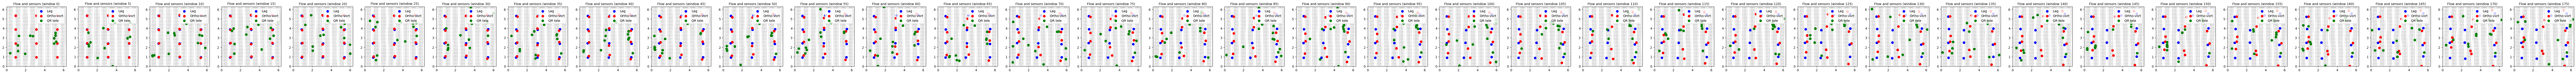

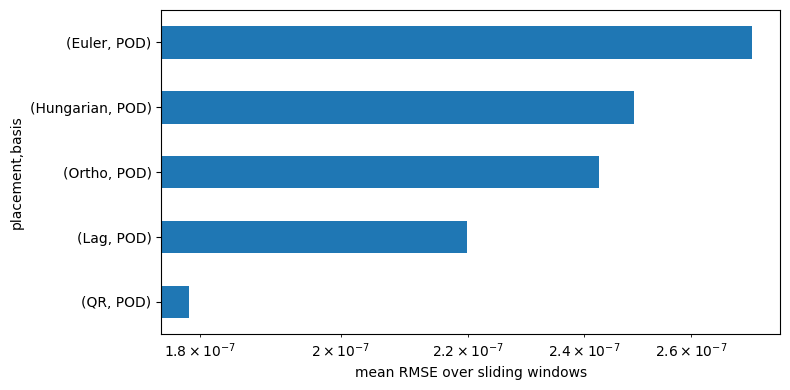

In [119]:
num_sensors = 12
WINDOW_LEN = 21
MAX_BASIS_DIM = 11
num_cv_folds = 3
TOTAL_STEPS = 200
PERIOD = 100
DT = 1

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)


NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-4
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=5000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)

sample_indices = np.linspace(800, 4900, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]
k_skip = sample_indices[1] - sample_indices[0]  
DT = k_skip * DT  # delta t between stored frames


dx = LX / NX; dy = LY / NY
dmin = min(dx, dy)
vmax = np.max(np.hypot(u, v))
C = vmax * DT / dmin

print(f"C={C}", "need to be C <= 0.5 (Euler advect)")

results,lag_hist,ortho_hist,ortho_heading_hist,ortho_flow_hist = run_experiment_ortho(
    u,v,window_len=WINDOW_LEN,dt=DT, periodic=True, return_paths=True, plot_every=5)


/var/folders/1d/93jt5bk515xg9t06p_3pgk7h5n4f78/T/ipykernel_66951/3891394582.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lag   = cm.get_cmap('autumn')   # warm colours
/var/folders/1d/93jt5bk515xg9t06p_3pgk7h5n4f78/T/ipykernel_66951/3891394582.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_hun   = cm.get_cmap('winter')   # cool colours
/var/folders/1d/93jt5bk515xg9t06p_3pgk7h5n4f78/T/ipykernel_66951/3891394582.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


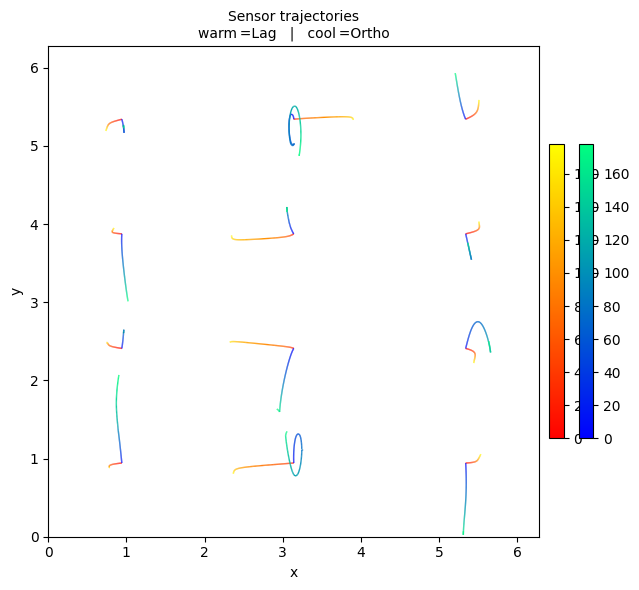

In [122]:
plot_trajectory(lag_hist,ortho_hist, sensor1_title='Lag', sensor2_title='Ortho')

In [ ]:
results

In [ ]:
n_trials=20
df_list = []
for trial in range(n_trials):
    df = run_experiment_ortho(u, v, window_len=WINDOW_LEN,
                                dt=DT, 
                                periodic=True, 
                                return_paths=False, 
                                plot_every=0,
                                init_sensors_func=seed_uniform_random)
    df["trial"] = trial
    df_list.append(df)


results = pd.DataFrame(df_list)

# box-plot of RMSE by placement 
plt.figure(figsize=(8,4))
results.boxplot(column='RMSE', by='placement',
                vert=False, grid=False, showfliers=True,
                whis=[5,95])
plt.suptitle(""); plt.xlabel("RMSE across windows & trials")
plt.xscale("log")
plt.tight_layout(); plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# path to your text file
path = "random_trail_output.txt"

# read the file: whitespace-delimited, no header
results = pd.read_csv(
    path,
    delim_whitespace=True,
    header=None,
    names=["placement", "basis", "RMSE"],
    dtype={"placement": str, "basis": str, "RMSE": float},
)

print(results.head())
print(results.groupby("placement").size())

# If you actually have many rows per placement, this will work as-is:
plt.figure(figsize=(8,4))
results.boxplot(column="RMSE", by="placement",
                vert=False, grid=False, showfliers=True, whis=[5,95])
plt.suptitle("")
plt.xlabel("RMSE across windows & trials")
# plt.xscale("log")
plt.tight_layout()
plt.show()


In [ ]:
plot_sensor_heading_vs_flow(ortho_heading_hist, ortho_flow_hist)

In [ ]:
plot_sensor_heading_vs_flow_360(ortho_heading_hist, ortho_flow_hist)

# High Accel & OW=0

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pysensors as ps  

# assumes you already have: get_sliding_intervals, expand_to_uv, grid_to_phys
# and globals: NX, NY, LX, LY, MAX_BASIS_DIM, SEED

def _greedy_pick_with_min_radius(
    cand_ij, scores, dx, dy, min_radius, num_keep
):
    """
    Greedy non-max suppression in physical space.
    cand_ij : (M,2) int array of candidate (i,j) grid indices
    scores  : (M,) float, larger = better
    dx, dy  : spacings to convert (i,j) -> (x,y)
    min_radius : required separation in physical units
    num_keep   : target number of picks
    """
    order = np.argsort(-scores)   # descending
    selected = []
    xs = cand_ij[:,0] * dx
    ys = cand_ij[:,1] * dy
    for k in order:
        i, j = cand_ij[k]
        xk, yk = xs[k], ys[k]
        ok = True
        for (ip, jp) in selected:
            xp, yp = ip*dx, jp*dy
            if np.hypot(xk - xp, yk - yp) < min_radius:
                ok = False
                break
        if ok:
            selected.append((i, j))
            if len(selected) >= num_keep:
                break
    return np.array(selected, dtype=int)

def _select_on_ow_zero_high_dvdt(
    ow, dvdt_mag, num_sensors_alt, dx, dy,
    min_sep_pct=0.02, ow_band='p0'
):
    """
    Choose sensor sites where OW is ~0 (within a band) and dv/dt is large,
    with min separation = min_sep_pct * max(LX, LY).
    Auto-relax the OW band if needed.
    """
    # band threshold tau from percentile of |OW|
    if isinstance(ow_band, str) and ow_band.startswith('p'):
        base_p = float(ow_band[1:])
    else:
        base_p = None  # will use absolute |OW| threshold directly if float given

    abs_ow = np.abs(ow)
    # make a candidate list under progressively relaxed bands
    min_radius = min_sep_pct * max(LX, LY)
    picks = np.empty((0,2), dtype=int)

    # try incremental relaxation until enough picks
    for add in [0, 5, 10, 20, 30, 40, 50]:
        if base_p is not None:
            p = min(100.0, base_p + add)
            tau = np.percentile(abs_ow, p)
        else:
            # if ow_band given as float (absolute), just scale it gradually
            tau = ow_band * (1.0 + 0.01*add)

        mask = abs_ow <= tau
        cand_ij = np.argwhere(mask)
        if cand_ij.size == 0:
            continue
        scores = dvdt_mag[cand_ij[:,0], cand_ij[:,1]]

        # Greedy NMS with min-radius
        picks = _greedy_pick_with_min_radius(
            cand_ij, scores, dx, dy, min_radius, num_sensors_alt
        )
        if picks.shape[0] >= num_sensors_alt:
            break

    return picks  # (K,2) with K<=num_sensors_alt (i,j)

def plot_podqr_dtow_flow_features(
    u, v,
    window_len=30, step_size=1,
    num_sensors=16,
    num_sensors_alt=None,      # NEW: number of OW–dv/dt sensors (default = num_sensors)
    max_basis_dim=None,        # if None → min(window_len, 2*NX*NY)
    dt=1.0,
    smooth_sigma=0.0,          # e.g., 0.5–1.0 for prettier fields
    ow_band='p5',              # NEW: OW≈0 band: percentile string like 'p5' or absolute float
    min_sep_pct=0.02           # NEW: min separation for alt sensors (fraction of domain)
):
    """
    u, v: arrays (T, NX, NY).
    For each sliding window [s .. e-2] (length=window_len), compute:
      • POD-QR pivots (red) using PySensors
      • OW≈0 & high ‖∂t v‖ sensors (cyan) with min separation
    and plot 6 feature maps with both placements overlaid.
    """
    T, NX_, NY_ = u.shape
    assert NX_ == NX and NY_ == NY, "u,v shape must match NX,NY globals"
    grid_N = NX * NY
    if max_basis_dim is None:
        max_basis_dim = min(window_len, 2 * grid_N)
    if num_sensors_alt is None:
        num_sensors_alt = num_sensors

    # spatial metrics spacing (non-periodic version)
    dx = LX / (NX - 1)
    dy = LY / (NY - 1)
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    intervals = get_sliding_intervals(T, window_len + 1, step_size)

    pivot_list = []     # (per-window) POD-QR (i,j)
    alt_list   = []     # (per-window) OW–dv/dt (i,j)

    for w, (s, e) in enumerate(intervals):
        # POD-QR pivots (PySensors) 
        Uwin = u[s:e-1].reshape(e - s - 1, -1)
        Vwin = v[s:e-1].reshape(e - s - 1, -1)

        # mean-center over the window (standard in POD)
        Uc = Uwin - Uwin.mean(axis=0, keepdims=True)
        Vc = Vwin - Vwin.mean(axis=0, keepdims=True)

        uv_concat = np.concatenate([Uc, Vc], axis=1)  # (W, 2*grid_N)
        pod_basis = ps.basis.SVD(n_basis_modes=min(max_basis_dim, uv_concat.shape[1]),
                                 algorithm="arpack",
                                 random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(uv_concat)

        qr_idx = qr_model.selected_sensors
        qr_grid_idx = np.mod(qr_idx, grid_N)
        ii_qr, jj_qr = np.unravel_index(qr_grid_idx, (NX, NY))
        piv_ij = np.column_stack([ii_qr, jj_qr])
        pivot_list.append(piv_ij)

        # window-mean feature fields 
        mean_u = u[s:e-1].mean(axis=0)
        mean_v = v[s:e-1].mean(axis=0)
        if smooth_sigma > 0:
            mean_u = gaussian_filter(mean_u, smooth_sigma, mode='nearest')
            mean_v = gaussian_filter(mean_v, smooth_sigma, mode='nearest')

        # speed and its gradient magnitude
        speed = np.hypot(mean_u, mean_v)
        sx, sy = np.gradient(speed, dx, dy, edge_order=2)
        grad_speed_mag = np.hypot(sx, sy)

        # spatial derivatives of mean flow
        ux, uy = np.gradient(mean_u, dx, dy, edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy, edge_order=2)

        # vorticity
        vort = vx - uy

        # strain proxies used in classic OW
        s1 = ux - vy
        s2 = uy + vx
        strain_mag = np.sqrt(s1**2 + s2**2)
        s_xy = 0.5*(uy + vx)
        shear_mag = np.abs(s_xy)

        # Okubo–Weiss (shear/strain > 0, rotation < 0)
        ow = s1**2 + s2**2 - vort**2

        # temporal change over the window (mean magnitude of dv/dt)
        du_dt = np.gradient(u[s:e-1], dt, axis=0)
        dv_dt = np.gradient(v[s:e-1], dt, axis=0)
        dvdt_mag = np.mean(np.hypot(du_dt, dv_dt), axis=0)
        if smooth_sigma > 0:
            dvdt_mag = gaussian_filter(dvdt_mag, smooth_sigma, mode='nearest')

        # NEW: alt sensors on OW≈0 & high ‖∂t v‖ 
        alt_ij = _select_on_ow_zero_high_dvdt(
            ow=ow, dvdt_mag=dvdt_mag,
            num_sensors_alt=num_sensors_alt,
            dx=dx, dy=dy,
            min_sep_pct=min_sep_pct,
            ow_band=ow_band
        )
        alt_list.append(alt_ij)

        # plotting 
        fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        axs = axes.ravel()

        # helper for plotting with both sensor sets
        def show(ax, field, title, diverge=False, contour_ow=False):
            if diverge:
                vmax = np.nanpercentile(np.abs(field), 98)
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='coolwarm',
                               vmin=-vmax, vmax=vmax)
            else:
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='viridis')
            # POD-QR (red)
            ax.scatter(ii_qr*dx, jj_qr*dy, s=35, c='red', edgecolor='k', lw=0.4, label='POD-QR')
            # Alt sensors (cyan)
            if alt_ij.size:
                ax.scatter(alt_ij[:,0]*dx, alt_ij[:,1]*dy, s=40, c='cyan', marker='^',
                           edgecolor='k', lw=0.4, label='OW≈0 & high ‖∂t v‖')
            if contour_ow:
                try:
                    cs = ax.contour(Xg, Yg, ow, levels=[0.0], colors='k', linewidths=1.0)
                    cs.collections[0].set_label('OW=0')
                except Exception:
                    pass
            ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('y')
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # 1) mean speed + quiver
        show(axs[0], speed, 'Mean speed ⟨|v|⟩')
        step = max(1, NX // 25)
        axs[0].quiver(Xg[::step, ::step], Yg[::step, ::step],
                      mean_u[::step, ::step], mean_v[::step, ::step],
                      scale_units='xy', scale=None, width=0.0025)

        # 2) mean vorticity (signed)
        show(axs[1], vort, 'Mean vorticity ⟨ω⟩', diverge=True)

        # 3) mean strain magnitude
        # show(axs[2], strain_mag, 'Mean strain magnitude ⟨‖S‖⟩')
        show(axs[2], shear_mag, 'Mean shear magnitude')

        # 4) mean |∇|v|| (speed-gradient magnitude)
        show(axs[3], grad_speed_mag, 'Mean ‖∇|v|‖')

        # 5) mean Okubo–Weiss + OW=0 contour
        show(axs[4], ow, 'Mean Okubo–Weiss ⟨OW⟩', diverge=True, contour_ow=True)

        # 6) mean temporal velocity change magnitude
        show(axs[5], dvdt_mag, 'Mean ‖∂t v‖')

        fig.suptitle(
            f'Window {w}: train frames [{s} .. {e-2}] (holdout {e-1}) — '
            f'{num_sensors} POD-QR, {num_sensors_alt} OW–dv/dt (min sep {int(min_sep_pct*100)}%)',
            y=1.02, fontsize=11
        )

        # Single legend
        handles, labels = [], []
        for ax in axs:
            h, lab = ax.get_legend_handles_labels()
            handles += h; labels += lab
        if handles:
            # de-duplicate while preserving order
            seen = set(); H = []; L = []
            for h, l in zip(handles, labels):
                if l not in seen:
                    H.append(h); L.append(l); seen.add(l)
            fig.legend(H, L, loc='upper right')

        plt.show()

    return pivot_list, alt_list


def plot_flow_features(
    u, v, start, stop, step=1, dt=1
):
    """
    u, v: arrays (T, NX, NY).
    For each sliding window [s .. e-2] (length=window_len), compute:
      • POD-QR pivots (red) using PySensors
      • OW≈0 & high ‖∂t v‖ sensors (cyan) with min separation
    and plot 6 feature maps with both placements overlaid.
    """
    T, NX_, NY_ = u.shape
    assert NX_ == NX and NY_ == NY, "u,v shape must match NX,NY globals"
    grid_N = NX * NY

    # spatial metrics spacing (non-periodic version)
    dx = LX / (NX - 1)
    dy = LY / (NY - 1)
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')


    for w in range(start, stop, step):
        # POD-QR pivots (PySensors) 
        Uwin = u[w]
        Vwin = v[w]

        # window-mean feature fields 
        mean_u = Uwin
        mean_v = Vwin
        # speed and its gradient magnitude
        speed = np.hypot(mean_u, mean_v)
        sx, sy = np.gradient(speed, dx, dy)
        grad_speed_mag = np.hypot(sx, sy)

        # spatial derivatives of mean flow
        ux, uy = np.gradient(mean_u, dx, dy,edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy,edge_order=2)

        # vorticity
        vort = vx - uy

        # strain proxies used in classic OW
        s1 = ux - vy
        s2 = uy + vx
        strain_mag = np.sqrt(s1**2 + s2**2)
        s_xy = 0.5*(uy + vx)
        shear_mag = np.abs(s_xy)

        # Okubo–Weiss (shear/strain > 0, rotation < 0)
        ow = s1**2 + s2**2 - vort**2

        # plotting 
        fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        axs = axes.ravel()

        # helper for plotting with both sensor sets
        def show(ax, field, title, diverge=False, contour_ow=False):
            if diverge:
                vmax = np.nanpercentile(np.abs(field), 98)
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='coolwarm',
                               vmin=-vmax, vmax=vmax)
            else:
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='viridis')
            # POD-QR (red)
           
            if contour_ow:
                try:
                    cs = ax.contour(Xg, Yg, ow, levels=[0.0], colors='k', linewidths=1.0)
                    cs.collections[0].set_label('OW=0')
                except Exception:
                    pass
            ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('y')
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # 1) mean speed + quiver
        show(axs[0], speed, 'Mean speed ⟨|v|⟩')
        step = max(1, NX // 25)
        axs[0].quiver(Xg[::step, ::step], Yg[::step, ::step],
                      mean_u[::step, ::step], mean_v[::step, ::step],
                      scale_units='xy', scale=None, width=0.0025)

        # 2) mean vorticity (signed)
        show(axs[1], vort, 'Mean vorticity ⟨ω⟩', diverge=True)

        # 3) mean strain magnitude
        # show(axs[2], strain_mag, 'Mean strain magnitude ⟨‖S‖⟩')
        show(axs[2], shear_mag, 'Mean shear magnitude')

        # 4) mean |∇|v|| (speed-gradient magnitude)
        show(axs[3], grad_speed_mag, 'Mean ‖∇|v|‖')

        # 5) mean Okubo–Weiss + OW=0 contour
        show(axs[4], ow, 'Mean Okubo–Weiss ⟨OW⟩', diverge=True, contour_ow=True)

        # 6) mean temporal velocity change magnitude
        show(axs[5], strain_mag, 'Mean strain magnitude ⟨‖S‖⟩')

        fig.suptitle(
            f'Window {w}',
            y=1.02, fontsize=11
        )

        # Single legend
        handles, labels = [], []
        for ax in axs:
            h, lab = ax.get_legend_handles_labels()
            handles += h; labels += lab
        if handles:
            # de-duplicate while preserving order
            seen = set(); H = []; L = []
            for h, l in zip(handles, labels):
                if l not in seen:
                    H.append(h); L.append(l); seen.add(l)
            fig.legend(H, L, loc='upper right')

        plt.show()



In [131]:
def plot_flow_features(u, v, start, stop, step=1, dt=1, periodic=False):
    """
    Plot instantaneous fields for frames w in [start, stop) by 'step'.
    Panels: |v|, ω, shear |s_xy|, |∇|v||, OW (with OW=0), and ||S||_F.
    """
    T, NX_, NY_ = u.shape
    assert (NX_, NY_) == (NX, NY)
    dx = LX / (NX if periodic else (NX-1))
    dy = LY / (NY if periodic else (NY-1))
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX); y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    def grads(A):
        if periodic:
            Ax = (np.roll(A, -1, 0) - np.roll(A, 1, 0)) / (2*dx)
            Ay = (np.roll(A, -1, 1) - np.roll(A, 1, 1)) / (2*dy)
        else:
            Ax, Ay = np.gradient(A, dx, dy, edge_order=2)
        return Ax, Ay

    for w in range(start, stop, step):
        U = u[w]; V = v[w]

        speed = np.hypot(U, V)
        sx, sy = grads(speed)
        grad_speed_mag = np.hypot(sx, sy)

        ux, uy = grads(U)
        vx, vy = grads(V)

        # vorticity
        vort = vx - uy

        # shear (Cartesian)
        s_xy = 0.5 * (uy + vx)
        shear_mag = np.abs(s_xy)

        # strain Frobenius ||S||_F
        strain_Frob = np.sqrt(ux**2 + vy**2 + 2.0 * (0.5*(uy + vx))**2)

        # Okubo–Weiss (strain>0, rotation<0)
        s1 = ux - vy
        s2 = uy + vx
        ow = s1**2 + s2**2 - vort**2

        fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        axs = axes.ravel()

        def show(ax, field, title, diverge=False, contour_ow=False):
            if diverge:
                vmax = np.nanpercentile(np.abs(field), 98)
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='coolwarm',
                               vmin=-vmax, vmax=vmax)
            else:
                im = ax.imshow(field.T, origin='lower', extent=extent, cmap='viridis')
            if contour_ow:
                try:
                    ax.contour(Xg, Yg, ow, levels=[0.0], colors='k', linewidths=1.0)
                except Exception:
                    pass
            ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('y')
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # 1) |v| + quiver
        show(axs[0], speed, '|v|')
        qstep = max(1, NX // 25)
        axs[0].quiver(Xg[::qstep, ::qstep], Yg[::qstep, ::qstep],
                      U[::qstep, ::qstep], V[::qstep, ::qstep],
                      scale_units='xy', scale=None, width=0.0025)

        # 2) ω
        show(axs[1], vort, 'vorticity ω', diverge=True)

        # 3) |s_xy|
        show(axs[2], shear_mag, 'shear |s_xy|')

        # 4) |∇|v|||
        show(axs[3], grad_speed_mag, '‖∇|v|‖')

        # 5) OW (+ contour at 0)
        show(axs[4], ow, 'Okubo–Weiss W', diverge=True, contour_ow=True)

        # 6) ||S||_F
        show(axs[5], strain_Frob, 'strain ‖S‖_F')

        fig.suptitle(f'Frame {w}', y=1.02, fontsize=11)
        plt.show()


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 50
PERIOD = 100
# DT = 1

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# # result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1000, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
pivots = plot_flow_features(
    u, v,
    start=0, stop=50, step=5, dt=dt_advect            
)



In [80]:
# assumes you already have: get_sliding_intervals, expand_to_uv, grid_to_phys, rmse
# globals: NX, NY, LX, LY, MAX_BASIS_DIM, SEED
# assumes you defined: _select_on_ow_zero_high_dvdt(...)

def run_experiment_ow_dt(
    u, v,
    window_len=30, step_size=1,
    num_sensors=16,
    num_sensors_alt=None,      # number of OW–dv/dt sensors (default = num_sensors)
    max_basis_dim=None,        # if None → min(window_len, 2*NX*NY)
    dt=1.0,
    smooth_sigma=0.0,          # e.g., 0.5–1.0 for prettier fields
    ow_band='p5',              # OW≈0 band: percentile string like 'p5' or absolute float
    min_sep_pct=0.02,           # min separation for alt sensors (fraction of domain)
    plot_every=5
):
    """
    For each window [s .. e-2] (length=window_len), compute:
      • POD-QR pivots (red)
      • OW≈0 & high ‖∂t v‖ sensors (cyan) with min separation
    Compute reconstruction RMSE on holdout slice (e-1) using ONLY the POD basis
    (standardized), and produce ONE figure with 2 rows x (#windows) columns:
      row 1: OW with contour at 0, row 2: ‖∂t v‖, both with both placements.
    Returns: pivot_list, alt_list, results_df
    """
    T, NX_, NY_ = u.shape
    assert NX_ == NX and NY_ == NY, "u,v shape must match NX,NY globals"
    grid_N = NX * NY
    if max_basis_dim is None:
        max_basis_dim = min(window_len, 2 * grid_N)
    if num_sensors_alt is None:
        num_sensors_alt = num_sensors

    # grid geometry
    dx = LX / (NX - 1)
    dy = LY / (NY - 1)
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    intervals = get_sliding_intervals(T, window_len + 1, step_size)
    num_cols = len(intervals)

    # ---- ONE figure with 2 rows x num_cols columns (created BEFORE loop) ----
    # Size scales with domain aspect; beware very large num_cols.
    base = 3.6
    num_plots = np.ceil(len(intervals) / plot_every).astype(int) 
    fig_w = max(3.0, base * (LX / (LX + LY))) * num_plots
    fig_h = max(2.5, base * (LY / (LX + LY))) * 2.2


    fig, axes = plt.subplots(2, num_cols, figsize=(fig_w, fig_h), constrained_layout=True)
    if num_cols == 1:
        # ensure 2D indexing works when num_cols == 1
        axes = np.array(axes).reshape(2, 1)

    pivot_list = []     # per-window POD-QR (i,j)
    alt_list   = []     # per-window OW–dv/dt (i,j)
    records    = []     # rows: window, placement, basis="POD", RMSE

    # (Optional) to make color scales consistent across columns, track global ranges
    ow_abs_max = 0.0
    dvdt_max   = 0.0
    ow_store   = [None]*num_cols
    dvdt_store = [None]*num_cols
    piv_store  = [None]*num_cols
    alt_store  = [None]*num_cols

    for w, (s, e) in enumerate(tqdm(intervals)):
        # -------------------- POD fit data (window) --------------------
        Uwin = u[s:e-1].reshape(e - s - 1, -1)  # (W, NX*NY)
        Vwin = v[s:e-1].reshape(e - s - 1, -1)
        X_raw = np.concatenate([Uwin, Vwin], axis=1)            # (W, 2*grid_N)

        # Standardize per column over the window
        mu_vec  = X_raw.mean(axis=0, keepdims=True)
        std_vec = X_raw.std(axis=0, keepdims=True) + 1e-12
        X_std   = (X_raw - mu_vec) / std_vec

        # Truncated SVD basis on standardized data + POD-QR selection
        pod_basis = ps.basis.SVD(n_basis_modes=min(max_basis_dim, X_std.shape[1]),
                                 algorithm="arpack",
                                 random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(X_std)
        Phi_std = qr_model.basis_matrix_                          # (r, 2*grid_N)

        qr_idx = qr_model.selected_sensors
        qr_grid_idx = np.mod(qr_idx, grid_N)
        ii_qr, jj_qr = np.unravel_index(qr_grid_idx, (NX, NY))
        piv_ij = np.column_stack([ii_qr, jj_qr])
        pivot_list.append(piv_ij)
        piv_store[w] = piv_ij

        # -------------------- Feature fields (window means) ------------
        mean_u = u[s:e-1].mean(axis=0)
        mean_v = v[s:e-1].mean(axis=0)
        if smooth_sigma > 0:
            mean_u = gaussian_filter(mean_u, smooth_sigma, mode='nearest')
            mean_v = gaussian_filter(mean_v, smooth_sigma, mode='nearest')

        ux, uy = np.gradient(mean_u, dx, dy, edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy, edge_order=2)
        vort = vx - uy
        s1 = ux - vy
        s2 = uy + vx
        ow = s1**2 + s2**2 - vort**2
        ow_store[w] = ow
        ow_abs_max = max(ow_abs_max, np.nanpercentile(np.abs(ow), 98))

        du_dt = np.gradient(u[s:e-1], dt, axis=0)
        dv_dt = np.gradient(v[s:e-1], dt, axis=0)
        dvdt_mag = np.mean(np.hypot(du_dt, dv_dt), axis=0)
        if smooth_sigma > 0:
            dvdt_mag = gaussian_filter(dvdt_mag, smooth_sigma, mode='nearest')
        dvdt_store[w] = dvdt_mag
        dvdt_max = max(dvdt_max, np.nanpercentile(dvdt_mag, 98))

        # -------------------- Alt placement (OW≈0 & high ‖∂t v‖) -------
        alt_ij = _select_on_ow_zero_high_dvdt(
            ow=ow, dvdt_mag=dvdt_mag,
            num_sensors_alt=num_sensors_alt,
            dx=dx, dy=dy,
            min_sep_pct=min_sep_pct,
            ow_band=ow_band
        )
        alt_list.append(alt_ij)
        alt_store[w] = alt_ij

        # -------------------- Reconstruction RMSE on holdout (e-1) -----
        x_last_u = u[e-1].reshape(1, -1)
        x_last_v = v[e-1].reshape(1, -1)
        Y_last_raw = np.concatenate([x_last_u, x_last_v], axis=1)

        def recon_rmse_from_ij(ij_idx, label):
            if ij_idx is None or len(ij_idx) == 0:
                records.append(dict(window=w, placement=label, basis="POD", RMSE=np.nan))
                return np.nan
            sidx = ij_idx[:,0]*NY + ij_idx[:,1]
            sidx_uv = expand_to_uv(sidx, grid_N)
            C = np.eye(2*grid_N)[sidx_uv]
            Y_sel_std = (Y_last_raw[:, sidx_uv] - mu_vec[:, sidx_uv]) / std_vec[:, sidx_uv]
            pinv_std = np.linalg.pinv(C @ Phi_std)
            xhat_std = (Y_sel_std @ pinv_std.T) @ Phi_std.T
            xhat_raw = xhat_std * std_vec + mu_vec
            u_hat, v_hat = np.split(xhat_raw, 2, axis=1)
            err = 0.5*(rmse(x_last_u, u_hat) + rmse(x_last_v, v_hat))
            records.append(dict(window=w, placement=label, basis="POD", RMSE=float(err)))
            return float(err)

        _ = recon_rmse_from_ij(piv_ij, label="POD-QR")
        _ = recon_rmse_from_ij(alt_ij, label="OW-dvdt")

    # -------------------- Single plot (populate all panels now) --------------------
    try:
        for w in range(num_plots):
            ax_top = axes[0, w]
            ax_bot = axes[1, w]

            # Row 1: OW with 0-contour
            vmax = ow_abs_max if np.isfinite(ow_abs_max) and ow_abs_max > 0 else None
            if vmax is None:
                im_top = ax_top.imshow(ow_store[w * plot_every].T, origin='lower', extent=extent, cmap='coolwarm')
            else:
                im_top = ax_top.imshow(ow_store[w * plot_every].T, origin='lower', extent=extent, cmap='coolwarm',
                                    vmin=-vmax, vmax=vmax)
            try:
                cs = ax_top.contour(Xg, Yg, ow_store[w * plot_every], levels=[0.0], colors='k', linewidths=1.0)
                cs.collections[0].set_label('OW=0')
            except Exception:
                pass

            # Row 2: |∂t v|
            im_bot = ax_bot.imshow(dvdt_store[w * plot_every].T, origin='lower', extent=extent, cmap='viridis',
                                vmin=0.0, vmax=dvdt_max if dvdt_max>0 else None)

            # Overlay sensors
            piv = piv_store[w * plot_every]
            ax_top.scatter(piv[:,0]*dx, piv[:,1]*dy, s=30, c='red', edgecolor='k', lw=0.4, label='POD-QR')
            ax_bot.scatter(piv[:,0]*dx, piv[:,1]*dy, s=30, c='red', edgecolor='k', lw=0.4, label='POD-QR')

            alt = alt_store[w]
            if alt is not None and alt.size:
                ax_top.scatter(alt[:,0]*dx, alt[:,1]*dy, s=36, c='cyan', marker='^', edgecolor='k', lw=0.4,
                            label='OW≈0 & high ‖∂t v‖')
                ax_bot.scatter(alt[:,0]*dx, alt[:,1]*dy, s=36, c='cyan', marker='^', edgecolor='k', lw=0.4,
                            label='OW≈0 & high ‖∂t v‖')

            # Cosmetics
            for ax in (ax_top, ax_bot):
                ax.set_aspect('equal', adjustable='box')
                ax.set_xlim(0, LX); ax.set_ylim(0, LY)
                ax.set_xlabel('x')
            ax_top.set_title(f'win {w}: OW')
            ax_top.set_ylabel('y')
            ax_bot.set_title('‖∂t v‖')
            ax_bot.set_ylabel('y')

        # One figure-level legend (de-dup)
        handles, labels = [], []
        for ax in axes.ravel():
            h, lab = ax.get_legend_handles_labels()
            handles += h; labels += lab
        if handles:
            seen = set(); H = []; Lb = []
            for h, l in zip(handles, labels):
                if l not in seen:
                    H.append(h); Lb.append(l); seen.add(l)
            fig.legend(H, Lb, loc='upper right')

        plt.show()
    except Exception:
        print("Warning: error making summary figure")

    results = pd.DataFrame.from_records(records, columns=["window","placement","basis","RMSE"])
    return pivot_list, alt_list, results


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 200
PERIOD = 100
# DT = 1

# double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# # result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1100, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
pivots = run_experiment_ow_dt(
    u, v,
    window_len=WINDOW_LEN, step_size=1,
    num_sensors=num_sensors,
    max_basis_dim=MAX_BASIS_DIM,   # or None
    dt=dt_advect,
    smooth_sigma=0.0,
    min_sep_pct=0.05,                       
)



In [ ]:
_,_,results=pivots

means = (results.groupby(["placement", "basis"]).RMSE.mean().sort_values())
print(means)
plt.figure(figsize=(8, 4))
means.plot(kind="barh", logx=True)
plt.xlabel("mean RMSE over sliding windows")
plt.tight_layout()
plt.show()

# Timeseries Analysis

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pysensors as ps

# expects globals: NX, NY, LX, LY, MAX_BASIS_DIM, SEED
# expects helpers: get_sliding_intervals, expand_to_uv

def _spatial_grads(A, dx, dy, periodic):
    """Central diffs with periodic or simple one-sided at edges."""
    if periodic:
        Ax = (np.roll(A, -1, axis=0) - np.roll(A, 1, axis=0)) / (2*dx)
        Ay = (np.roll(A, -1, axis=1) - np.roll(A, 1, axis=1)) / (2*dy)
        return Ax, Ay
    # non-periodic: central inside, forward/backward at edges
    Ax = np.empty_like(A); Ay = np.empty_like(A)
    Ax[1:-1,:] = (A[2:,:]-A[:-2,:])/(2*dx)
    Ax[0,:]    = (A[1,:]-A[0,:])/dx
    Ax[-1,:]   = (A[-1,:]-A[-2,:])/dx
    Ay[:,1:-1] = (A[:,2:]-A[:,:-2])/(2*dy)
    Ay[:,0]    = (A[:,1]-A[:,0])/dy
    Ay[:,-1]   = (A[:,-1]-A[:,-2])/dy
    return Ax, Ay

def _compute_metrics_on_slice(u_grid, v_grid, dx, dy, periodic, smooth_sigma=0.0):
    """Return a dict of metric fields (each NXxNY)."""
    if smooth_sigma and smooth_sigma > 0:
        u_grid = gaussian_filter(u_grid, smooth_sigma, mode='nearest')
        v_grid = gaussian_filter(v_grid, smooth_sigma, mode='nearest')

    ux, uy = _spatial_grads(u_grid, dx, dy, periodic)
    vx, vy = _spatial_grads(v_grid, dx, dy, periodic)

    speed = np.hypot(u_grid, v_grid)
    sx, sy = _spatial_grads(speed, dx, dy, periodic)
    grad_speed_mag = np.hypot(sx, sy)

    omega = vx - uy                 # signed vorticity
    abs_omega = np.abs(omega)

    # strain tensor pieces
    s_xy = 0.5*(uy + vx)            # pure shear component
    s_xx = ux
    s_yy = vy
    normal_strain = 0.5*(ux - vy)   # normal strain difference / 2

    # Frobenius norms
    strain_Frob = np.sqrt(s_xx**2 + s_yy**2 + 2*s_xy**2)
    J_Frob = np.sqrt(ux**2 + uy**2 + vx**2 + vy**2)

    # Okubo–Weiss using the classic proxies
    s1 = ux - vy
    s2 = uy + vx
    OW = s1**2 + s2**2 - omega**2
    abs_OW = np.abs(OW)

    # package
    metrics = dict(
        speed=speed,
        omega=omega,
        abs_omega=abs_omega,
        shear_mag=np.abs(s_xy),          # |(uy+vx)/2|
        normal_strain_mag=np.abs(normal_strain),
        strain_Frob=strain_Frob,
        J_Frob=J_Frob,
        grad_speed_mag=grad_speed_mag,
        OW=OW,
        abs_OW=abs_OW,
    )
    return metrics

def _time_derivative_slice(u, v, t_idx, dt):
    """
    Central difference where possible: t_idx is the holdout index (e-1).
    Returns accel_mag field on that slice (NXxNY).
    """
    T = u.shape[0]
    if T == 1:
        du = np.zeros_like(u[0]); dv = np.zeros_like(v[0])
    elif 0 < t_idx < T-1:
        du = (u[t_idx+1] - u[t_idx-1])/(2*dt)
        dv = (v[t_idx+1] - v[t_idx-1])/(2*dt)
    elif t_idx == 0:
        du = (u[1] - u[0])/dt
        dv = (v[1] - v[0])/dt
    else:  # t_idx == T-1
        du = (u[-1] - u[-2])/dt
        dv = (v[-1] - v[-2])/dt
    return np.hypot(du, dv)

def plot_podqr_metric_timeseries(
    u, v,
    window_len=30, step_size=1,
    num_sensors=16,
    max_basis_dim=None,
    dt=1.0,
    periodic=False,
    smooth_sigma_metrics=0.0,
    show=True
):
    """
    Window-averaged view with a single window [s:e) used for:
      - POD-QR selection
      - metric distributions
      - POD-QR metric averages
    """
    T, NX_, NY_ = u.shape
    assert (NX_, NY_) == (NX, NY)
    grid_N = NX * NY
    if max_basis_dim is None:
        max_basis_dim = min(window_len, 2 * grid_N)

    # spacings
    dx = LX / (NX if periodic else (NX - 1))
    dy = LY / (NY if periodic else (NY - 1))

    # same window everywhere
    intervals = get_sliding_intervals(T, window_len, step_size)

    podqr_rows, stats_rows = [], []

    for w, (s, e) in enumerate(intervals):
        # --- POD-QR selection on [s:e) ---
        Uwin = u[s:e].reshape(e - s, -1)
        Vwin = v[s:e].reshape(e - s, -1)
        X = np.concatenate([Uwin, Vwin], axis=1)  # (W, 2N)

        # center-only POD for basis
        mu_pod = X.mean(axis=0, keepdims=True)
        Xs = X - mu_pod

        pod_basis = ps.basis.SVD(
            n_basis_modes=min(max_basis_dim, Xs.shape[1]),
            algorithm="arpack",
            random_state=SEED
        )
        qr_model = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(Xs)

        qr_idx   = qr_model.selected_sensors
        grid_idx = np.mod(qr_idx, grid_N)                 # collapse u/v to grid
        ii, jj   = np.unravel_index(grid_idx, (NX, NY))
        piv_ij   = np.column_stack([ii, jj])              # (K,2)

        # --- accumulate per-slice stats over the same window [s:e) ---
        slice_indices = range(s, e)
        field_stats = {}   # metric -> list of (min,p10,p25,median,p75,p90,max)
        pod_means   = {}   # metric -> list of POD-QR means

        for t in slice_indices:
            u_slice = u[t]
            v_slice = v[t]

            metrics = _compute_metrics_on_slice(
                u_slice, v_slice, dx, dy, periodic, smooth_sigma=smooth_sigma_metrics
            )

            # acceleration magnitude at time t (global central/one-sided)
            accel_mag = _time_derivative_slice(u, v, t_idx=t, dt=dt)
            metrics['accel_mag'] = accel_mag

            for name, field in metrics.items():
                # POD-QR values on this slice
                vals_podqr = field[piv_ij[:, 0], piv_ij[:, 1]]
                pod_means.setdefault(name, []).append(float(np.mean(vals_podqr)))

                # field-wide stats on this slice
                fa = field.ravel()
                stats_entry = (
                    float(np.min(fa)),
                    float(np.percentile(fa, 10)),
                    float(np.percentile(fa, 25)),
                    float(np.median(fa)),
                    float(np.percentile(fa, 75)),
                    float(np.percentile(fa, 90)),
                    float(np.max(fa)),
                )
                field_stats.setdefault(name, []).append(stats_entry)

        # --- window-average the slice stats ---
        for name, entries in field_stats.items():
            arr = np.asarray(entries)  # (#slices, 7)
            avg_min, avg_p10, avg_p25, avg_med, avg_p75, avg_p90, avg_max = arr.mean(axis=0)
            avg_pod_mean = float(np.mean(pod_means[name]))

            podqr_rows.append(dict(
                window=w, metric=name,
                mean_at_PODQR=avg_pod_mean,
                n=len(slice_indices)
            ))
            stats_rows.append(dict(
                window=w, metric=name,
                min=avg_min, p10=avg_p10, p25=avg_p25, median=avg_med,
                p75=avg_p75, p90=avg_p90, max=avg_max
            ))

    df_podqr = pd.DataFrame(podqr_rows).sort_values(['metric', 'window']).reset_index(drop=True)
    df_stats = pd.DataFrame(stats_rows).sort_values(['metric', 'window']).reset_index(drop=True)

    # ---- plotting (same as before) ----
    metrics_order = [
        'speed', 'accel_mag',
        'omega', 'abs_omega',
        'shear_mag', 'normal_strain_mag', 'strain_Frob', 'J_Frob',
        'grad_speed_mag',
        'OW', 'abs_OW',
    ]
    metrics_order = [m for m in metrics_order if m in df_stats['metric'].unique()]

    nM = len(metrics_order)
    ncols = 2
    nrows = int(np.ceil(nM / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.0*nrows), sharex=True)
    axes = np.array(axes).reshape(nrows, ncols)

    for k, m in enumerate(metrics_order):
        ax = axes[k // ncols, k % ncols]
        sub_stats = df_stats[df_stats.metric == m]
        wv = sub_stats['window'].values

        ax.fill_between(wv, sub_stats['p25'], sub_stats['p75'], alpha=0.25, label='IQR (avg 25–75%)')
        ax.fill_between(wv, sub_stats['p10'], sub_stats['p90'], alpha=0.12, label='avg 10–90%')
        ax.plot(wv, sub_stats['median'], linestyle='--', linewidth=1.2, label='avg median', alpha=0.9)
        ax.plot(wv, sub_stats['min'], linewidth=0.8, alpha=0.5, label='avg min')
        ax.plot(wv, sub_stats['max'], linewidth=0.8, alpha=0.5, label='avg max')

        sub_pod = df_podqr[df_podqr.metric == m]
        ax.plot(sub_pod['window'].values, sub_pod['mean_at_PODQR'].values,
                marker='o', lw=1.8, label='POD-QR mean (avg over window)')
        ax.set_title(m)
        ax.grid(True, alpha=0.3)

        if k == 0:
            ax.legend(loc='best', fontsize=9)

    for ax in axes.ravel()[nM:]:
        ax.axis('off')

    fig.suptitle('Window-averaged field distribution vs POD-QR mean (raw units)', y=1.02, fontsize=12)
    fig.tight_layout()
    if show:
        plt.show()

    return df_podqr, df_stats


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 200
PERIOD = 100
# DT = 1

# double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# # result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1100, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames
pivots = plot_podqr_metric_timeseries(
    u, v,
    window_len=WINDOW_LEN, step_size=1,
    num_sensors=num_sensors,
    max_basis_dim=MAX_BASIS_DIM,   # or None
    dt=dt_advect,                
)



In [28]:
# --- imports ---
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# You already have these:
#  - _compute_metrics_on_slice(u_grid, v_grid, dx, dy, periodic, smooth_sigma)
#  - _time_derivative_slice(u, v, t_idx, dt)
#  - get_sliding_intervals(T, window_len, step_size)
#  - pysensors as ps (POD + SSPOR/QR)

# -------------------------------
# 0) POD-QR picks on one window
# -------------------------------
def qr_picks_for_window(u, v, s, e, num_sensors, max_basis_dim, seed=0):
    """
    Returns: array of (i,j) indices (K x 2) for POD-QR picks on window [s:e).
    POD basis is computed on centered snapshots (no per-cell std).
    """
    T, NX, NY = u.shape
    grid_N = NX * NY

    Uwin = u[s:e].reshape(e - s, -1)   # (W, N)
    Vwin = v[s:e].reshape(e - s, -1)
    X = np.concatenate([Uwin, Vwin], axis=1)  # (W, 2N)

    # center-only POD (recommended)
    Xc = X - X.mean(axis=0, keepdims=True)

    n_modes = min(max_basis_dim, Xc.shape[1])
    pod_basis = ps.basis.SVD(n_basis_modes=n_modes, algorithm="arpack", random_state=seed)
    qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
    qr_model.fit(Xc)

    qr_idx   = qr_model.selected_sensors              # indices in [0, 2N)
    grid_idx = np.mod(qr_idx, grid_N)                 # collapse u/v to grid
    ii, jj   = np.unravel_index(grid_idx, (NX, NY))
    return np.column_stack([ii, jj])                  # (K,2)

# ---------------------------------------------------------
# 1) Window-averaged metric fields at every grid location
# ---------------------------------------------------------
def window_avg_metrics(u, v, s, e, LX, LY, periodic, smooth_sigma=0.0, dt=1.0):
    """
    Returns: dict[name] -> (NX,NY) arrays with window-averaged values.
    Metrics: speed, omega, abs_omega, shear_mag, normal_strain_mag,
             strain_Frob, J_Frob, grad_speed_mag, OW, abs_OW, accel_mag
    """
    _, NX, NY = u.shape
    dx = LX / (NX if periodic else (NX - 1))
    dy = LY / (NY if periodic else (NY - 1))

    acc = {k: np.zeros((NX, NY), dtype=float) for k in [
        "speed","omega","abs_omega","shear_mag","normal_strain_mag",
        "strain_Frob","J_Frob","grad_speed_mag","OW","abs_OW","accel_mag"
    ]}
    W = e - s
    for t in range(s, e):
        metrics = _compute_metrics_on_slice(u[t], v[t], dx, dy, periodic, smooth_sigma=smooth_sigma)
        for k in metrics:
            acc[k] += metrics[k]
        acc["accel_mag"] += _time_derivative_slice(u, v, t_idx=t, dt=dt)

    for k in acc:
        acc[k] /= W
    return acc

# ---------------------------------------------------------
# 2) OPTIONAL: leverage proxy (row-norm of raw-units basis)
# ---------------------------------------------------------
def leverage_proxy(u, v, s, e, max_basis_dim, periodic, LX, LY, smooth_sigma=0.0, seed=0):
    """
    Returns: (NX,NY) leverage-like map from POD basis row norms (raw units).
    (We use the same centered snapshots; no per-cell std scaling.)
    """
    _, NX, NY = u.shape
    grid_N = NX * NY
    Uwin = u[s:e].reshape(e - s, -1)
    Vwin = v[s:e].reshape(e - s, -1)
    X = np.concatenate([Uwin, Vwin], axis=1)
    Xc = X - X.mean(axis=0, keepdims=True)

    n_modes = min(max_basis_dim, Xc.shape[1])
    pod_basis = ps.basis.SVD(n_basis_modes=n_modes, algorithm="arpack", random_state=seed)
    pod_basis.fit(Xc)                        # get basis matrix (2N x r)
    Phi = pod_basis.basis_matrix_            # rows = spatial DOF
    row_norm = np.sqrt((Phi**2).sum(axis=1)) # length 2N
    lev_u = row_norm[:grid_N].reshape(NX, NY)
    lev_v = row_norm[grid_N:].reshape(NX, NY)
    return 0.5 * (lev_u + lev_v)

# ---------------------------------------------------------
# 3) Assemble labeled dataset (per-window, per-cell)
# ---------------------------------------------------------
def build_dataset_for_selection(
    u, v, LX, LY, window_len, step_size,
    num_sensors, max_basis_dim,
    periodic=False, smooth_sigma=0.0, dt=1.0,
    include_leverage=True,
    neg_ratio_per_window=5,   # keep ~5x negatives per window vs positives
    seed=0
):
    """
    Returns: df with columns:
      ['window','i','j','y', <feature columns...>]
    y=1 for POD-QR picks. Features = window-averaged metrics (and leverage if enabled).
    """
    rng = np.random.default_rng(seed)
    T = u.shape[0]
    intervals = get_sliding_intervals(T, window_len, step_size)

    rows = []
    for w, (s, e) in enumerate(intervals):
        # POD-QR picks (K locations)
        picks_ij = set(map(tuple, qr_picks_for_window(u, v, s, e, num_sensors, max_basis_dim, seed=seed)))

        # features: window-averaged metrics
        feats = window_avg_metrics(u, v, s, e, LX, LY, periodic, smooth_sigma, dt)
        if include_leverage:
            feats["leverage"] = leverage_proxy(u, v, s, e, max_basis_dim, periodic, LX, LY, smooth_sigma, seed=seed)

        NX, NY = feats["speed"].shape
        K = len(picks_ij)
        # We’ll collect all positives and sample ~neg_ratio_per_window*K negatives.
        neg_needed = neg_ratio_per_window * max(1, K)
        neg_pool = []

        for i in range(NX):
            for j in range(NY):
                y = int((i, j) in picks_ij)
                row = {"window": w, "i": i, "j": j, "y": y}
                for name, A in feats.items():
                    row[name] = float(A[i, j])
                if y == 1:
                    rows.append(row)  # keep all positives
                else:
                    neg_pool.append(row)

        # sample negatives for this window
        if len(neg_pool) > neg_needed:
            neg_idx = rng.choice(len(neg_pool), size=neg_needed, replace=False)
            for idx in neg_idx:
                rows.append(neg_pool[idx])
        else:
            rows.extend(neg_pool)

    df = pd.DataFrame(rows)
    # ensure feature columns are floats
    feature_cols = [c for c in df.columns if c not in ("window","i","j","y")]
    df[feature_cols] = df[feature_cols].astype(float)
    return df, feature_cols

# ---------------------------------------------------------
# 4) Univariate screen: PR-AUC + enrichment@90th
# ---------------------------------------------------------
def univariate_summary(df, feature_cols):
    out = []
    for f in feature_cols:
        # PR-AUC (across all rows)
        pr = average_precision_score(df["y"], df[f])
        # enrichment@90th computed per-window, then averaged (scale-free)
        vals = []
        for w, sub in df.groupby("window"):
            thr = sub[f].quantile(0.9)
            top = sub[f] >= thr
            p1 = sub.loc[top, "y"].mean()
            p0 = sub.loc[~top, "y"].mean()
            if p0 == 0:
                continue
            vals.append(p1 / p0)
        enrich90 = float(np.mean(vals)) if vals else np.nan
        out.append((f, pr, enrich90))
    uni = pd.DataFrame(out, columns=["feature","PR_AUC","enrich@90"]).sort_values("PR_AUC", ascending=False)
    return uni

# ---------------------------------------------------------
# 5) Grouped-CV PR-AUC for a feature subset
# ---------------------------------------------------------
def cv_pr_auc(df, feature_list, C=1.0, n_splits=5, seed=0):
    X = df[feature_list].to_numpy()
    y = df["y"].to_numpy()
    groups = df["window"].to_numpy()
    # balanced weights help if your downsampling ratio changes
    model = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(penalty="l2", C=C, class_weight="balanced", max_iter=2000, random_state=seed),
    )
    gkf = GroupKFold(n_splits=n_splits)
    scores = []
    for tr, te in gkf.split(X, y, groups):
        model.fit(X[tr], y[tr])
        p = model.predict_proba(X[te])[:, 1]
        scores.append(average_precision_score(y[te], p))
    return float(np.mean(scores))

# ---------------------------------------------------------
# 6) Sequential forward selection → minimal subset (1%-rule)
# ---------------------------------------------------------
def minimal_feature_set(df, feature_cols, start_top_k=6, tol_frac=0.01, seed=0):
    """
    - Start with top_k features by univariate PR-AUC.
    - Greedy forward selection using grouped CV PR-AUC.
    - Return the *smallest* subset whose PR-AUC is within tol_frac (e.g., 1%) of best.
    """
    uni = univariate_summary(df, feature_cols)
    candidate_order = list(uni.head(start_top_k)["feature"].values)
    # If you want to allow all features, set start_top_k = len(feature_cols)

    selected = []
    best_so_far = -np.inf
    path = []  # (tuple(features), score)

    for f in candidate_order:
        trial = selected + [f]
        sc = cv_pr_auc(df, trial)
        path.append((tuple(trial), sc))
        if sc > best_so_far + 1e-6:
            best_so_far = sc
            selected = trial

    # Also check adding any remaining features (optional, wider search)
    remaining = [f for f in feature_cols if f not in candidate_order]
    for f in remaining:
        trial = selected + [f]
        sc = cv_pr_auc(df, trial)
        path.append((tuple(trial), sc))
        if sc > best_so_far + 1e-6:
            best_so_far = sc
            selected = trial

    # Pick smallest set within tol of the best score ever seen
    best_overall = max(sc for _, sc in path)
    candidates = [(fs, sc) for fs, sc in path if sc >= best_overall * (1 - tol_frac)]
    minimal = min(candidates, key=lambda z: (len(z[0]), -z[1]))  # fewest features, break ties by higher score

    # Pretty summary
    path_df = pd.DataFrame([(list(fs), sc) for fs, sc in path], columns=["features","PR_AUC"]).sort_values("PR_AUC", ascending=False)
    print("=== Forward path (top few) ===")
    display(path_df.head(10))
    print(f"Best PR-AUC: {best_overall:.4f}")
    print(f"Minimal subset within {int(100*tol_frac)}% of best: {list(minimal[0])}  (PR-AUC={minimal[1]:.4f})")

    return list(minimal[0]), uni, path_df

# ---------------------------------------------------------
# 7) DRIVER: run everything and report the minimal feature list
# ---------------------------------------------------------
def find_minimal_predictive_features(
    u, v, LX, LY,
    window_len=30, step_size=1,
    num_sensors=16, max_basis_dim=20,
    periodic=False, smooth_sigma=0.0, dt=1.0,
    include_leverage=True,
    neg_ratio_per_window=5,
    start_top_k=6, tol_frac=0.01, seed=0
):
    df, feature_cols = build_dataset_for_selection(
        u, v, LX, LY, window_len, step_size,
        num_sensors, max_basis_dim,
        periodic=periodic, smooth_sigma=smooth_sigma, dt=dt,
        include_leverage=include_leverage,
        neg_ratio_per_window=neg_ratio_per_window,
        seed=seed
    )
    minimal_set, uni_table, path_df = minimal_feature_set(
        df, feature_cols,
        start_top_k=start_top_k, tol_frac=tol_frac, seed=seed
    )
    return minimal_set, uni_table, path_df, df


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 200
PERIOD = 100
# DT = 1

# double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)
# # result, lag_traj, hung_traj = run_experiment_sliding(u,v,window_len=WINDOW_LEN,dt=0.3, return_paths=True)



NX, NY = 300, 300
LX, LY = 2 * np.pi, 2 * np.pi
DT = 1e-3
u, v = generate_cfd_kolmogorov_flow(
    n_timesteps=2000,
    nx=NX, ny=NY,      
    lx=LX, ly=LY,
    dt=DT,              
    nu=2e-2, 
    forcing_amp=20.0, 
    kf=4,
    plot_series=False)
sample_indices = np.linspace(1100, 1950, TOTAL_STEPS, dtype=int)
u = u[sample_indices]
v = v[sample_indices]

k_skip = sample_indices[1] - sample_indices[0]  
dt_advect = k_skip * DT  # delta t between stored frames

minimal, uni, path, df = find_minimal_predictive_features(
    u, v, LX, LY,
    window_len=WINDOW_LEN, step_size=1,
    num_sensors=num_sensors, max_basis_dim=MAX_BASIS_DIM,
    periodic=True, smooth_sigma=0.0, dt=DT,
    include_leverage=False,          # set False if you want *only* flow metrics
    neg_ratio_per_window=10,         # adjust if df is too large
    start_top_k=8,                  # try 6–10
    tol_frac=0.01,                  # 1% of best PR-AUC
    seed=SEED
)
print("Minimal feature set:", minimal)
display(uni.head(10))


In [32]:
import numpy as np

# --- Build a (NX,NY,F) feature tensor from window-averaged physics fields ---
# Supports names like 'speed','accel_mag','shear_mag','strain_Frob','OW','abs_OW',...
def _feature_stack_from_window(u, v, s, e, LX, LY, periodic, dt, smooth_sigma, feature_names):
    feats = window_avg_metrics(u, v, s, e, LX, LY, periodic, smooth_sigma=smooth_sigma, dt=dt)
    NX_, NY_ = feats['speed'].shape

    stack_list = []
    for name in feature_names:
        if name == 'abs_OW':
            A = np.abs(feats['OW'])
        else:
            A = feats[name]
        stack_list.append(A.astype(float))
    F = np.stack(stack_list, axis=-1)  # (NX,NY,F)
    return F, feats  # return feats dict too if you want to annotate plots

# --- Score field from a model ---
# model can be:
#  (A) a scikit-learn-like estimator with predict_proba(X)[:,1]
#  (B) a dict with {"features": [...], "mu": [...], "sigma": [...], "w": [...], "b": float}
def _score_field(F_stack, model, feature_names):
    NX_, NY_, Fd = F_stack.shape

    # Param dict path (fast, no sklearn needed at runtime)
    if isinstance(model, dict):
        # ensure order matches model["features"]
        order = [feature_names.index(n) for n in model["features"]]
        X = F_stack[..., order].reshape(-1, len(order))
        mu = np.asarray(model["mu"]); sigma = np.asarray(model["sigma"])
        w  = np.asarray(model["w"]);  b = float(model["b"])
        Xz = (X - mu) / (sigma + 1e-12)
        scores = (Xz @ w + b)  # logistic logit; sigmoid not needed for ranking
        return scores.reshape(NX_, NY_)

    # Pipeline/estimator path
    X = F_stack.reshape(-1, Fd)
    # Must expose predict_proba; many sklearn/xgb models do
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)[:, 1]
    else:
        # fallback to decision_function/logits if available
        scores = getattr(model, "decision_function")(X)
    return scores.reshape(NX_, NY_)

# --- Greedy top-K with minimum physical separation (non-max suppression) ---
def _greedy_topK_minsep(S, K, LX, LY, min_sep_pct, periodic):
    NX_, NY_ = S.shape
    # physical spacings (respect periodic grid geometry)
    dx = LX / (NX_ if periodic else (NX_ - 1))
    dy = LY / (NY_ if periodic else (NY_ - 1))
    r_phys = min_sep_pct * min(LX, LY)

    chosen = []
    # flat sort descending
    order = np.argsort(S.ravel())[::-1]
    used = np.zeros_like(order, dtype=bool)

    def too_close(i1, j1, i2, j2):
        # physical distance; handle periodic wrap if needed
        if periodic:
            # wrap-aware Δx, Δy
            dxp = ((i1 - i2 + NX_) % NX_)
            dxm = ((i2 - i1 + NX_) % NX_)
            dxi = min(dxp, dxm) * dx
            dyp = ((j1 - j2 + NY_) % NY_)
            dym = ((j2 - j1 + NY_) % NY_)
            dyi = min(dyp, dym) * dy
        else:
            dxi = abs(i1 - i2) * dx
            dyi = abs(j1 - j2) * dy
        return (dxi*dxi + dyi*dyi) <= (r_phys * r_phys)

    for idx in order:
        if len(chosen) >= K: break
        ii, jj = np.unravel_index(idx, (NX_, NY_))
        ok = True
        for (ci, cj) in chosen:
            if too_close(ii, jj, ci, cj):
                ok = False; break
        if ok:
            chosen.append((ii, jj))
    return np.array(chosen, dtype=int)


In [33]:
def run_experiment_model(
    u, v,
    window_len=30, step_size=1,
    num_sensors=16,
    max_basis_dim=None,
    dt=1.0,
    smooth_sigma=0.0,
    periodic=False,
    # NEW: model-based placement inputs
    model=None,                    # (A) sklearn pipeline/estimator  OR  (B) param dict {features, mu, sigma, w, b}
    model_features=None,           # list of feature names in the field builder; for dict, should match model["features"]
    min_sep_pct=0.02,              # min separation for model picks (fraction of domain)
    plot_every=5
):
    """
    For each window [s .. e-2]:
      • POD-QR pivots (red)
      • MODEL-based sensors (cyan): top-K by learned score with min-separation
    Compute reconstruction RMSE on holdout slice (e-1) using the POD basis (standardized),
    and produce a 2-row figure (OW, |∂t v|) with both placements overlaid (for visual context).
    """
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter
    from tqdm import tqdm

    T, NX_, NY_ = u.shape
    assert NX_ == NX and NY_ == NY
    grid_N = NX * NY
    if max_basis_dim is None:
        max_basis_dim = min(window_len, 2 * grid_N)
    if model is None:
        raise ValueError("Please pass a trained 'model' (pipeline or param dict) and 'model_features' list.")
    if model_features is None:
        # try to infer from dict; else bail
        if isinstance(model, dict):
            model_features = list(model["features"])
        else:
            raise ValueError("Please provide 'model_features' list matching the training order.")

    # geometry
    dx = LX / (NX if periodic else (NX - 1))
    dy = LY / (NY if periodic else (NY - 1))
    extent = (0.0, LX, 0.0, LY)
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    intervals = get_sliding_intervals(T, window_len + 1, step_size)
    num_cols = len(intervals)
    base = 3.6
    num_plots = np.ceil(len(intervals) / plot_every).astype(int) 
    fig_w = max(3.0, base * (LX / (LX + LY))) * num_plots
    fig_h = max(2.5, base * (LY / (LX + LY))) * 2.2
    fig, axes = plt.subplots(2, num_cols, figsize=(fig_w, fig_h), constrained_layout=True)
    if num_cols == 1:
        axes = np.array(axes).reshape(2, 1)

    pivot_list, model_list, records = [], [], []
    ow_abs_max, dvdt_max = 0.0, 0.0
    ow_store   = [None] * num_cols
    dvdt_store = [None] * num_cols
    piv_store  = [None] * num_cols
    mdl_store  = [None] * num_cols

    for w, (s, e) in enumerate(tqdm(intervals)):
        # -------------- POD basis + QR on standardized window [s..e-2] --------------
        Uwin = u[s:e-1].reshape(e - s - 1, -1)
        Vwin = v[s:e-1].reshape(e - s - 1, -1)
        X_raw = np.concatenate([Uwin, Vwin], axis=1)

        mu_vec  = X_raw.mean(axis=0, keepdims=True)
        std_vec = X_raw.std(axis=0, keepdims=True) + 1e-12
        X_std   = (X_raw - mu_vec) / std_vec

        pod_basis = ps.basis.SVD(n_basis_modes=min(max_basis_dim, X_std.shape[1]),
                                 algorithm="arpack", random_state=SEED)
        qr_model  = ps.SSPOR(n_sensors=num_sensors, basis=pod_basis)
        qr_model.fit(X_std)
        Phi_std = qr_model.basis_matrix_

        qr_idx = qr_model.selected_sensors
        qr_grid_idx = np.mod(qr_idx, grid_N)
        ii_qr, jj_qr = np.unravel_index(qr_grid_idx, (NX, NY))
        piv_ij = np.column_stack([ii_qr, jj_qr])
        pivot_list.append(piv_ij); piv_store[w] = piv_ij

        # -------------- Context fields for plotting (OW, |∂t v|) --------------
        mean_u = u[s:e-1].mean(axis=0); mean_v = v[s:e-1].mean(axis=0)
        if smooth_sigma > 0:
            mean_u = gaussian_filter(mean_u, smooth_sigma, mode='nearest')
            mean_v = gaussian_filter(mean_v, smooth_sigma, mode='nearest')
        ux, uy = np.gradient(mean_u, dx, dy, edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy, edge_order=2)
        vort = vx - uy
        s1 = ux - vy; s2 = uy + vx
        ow = s1**2 + s2**2 - vort**2
        ow_store[w] = ow
        ow_abs_max = max(ow_abs_max, np.nanpercentile(np.abs(ow), 98))

        du_dt = np.gradient(u[s:e-1], dt, axis=0)
        dv_dt = np.gradient(v[s:e-1], dt, axis=0)
        dvdt_mag = np.mean(np.hypot(du_dt, dv_dt), axis=0)
        if smooth_sigma > 0:
            dvdt_mag = gaussian_filter(dvdt_mag, smooth_sigma, mode='nearest')
        dvdt_store[w] = dvdt_mag
        dvdt_max = max(dvdt_max, np.nanpercentile(dvdt_mag, 98))

        # -------------- MODEL-based placement: score → top-K with min-sep --------------
        F_stack, _ = _feature_stack_from_window(
            u, v, s, e-1, LX, LY, periodic, dt, smooth_sigma, model_features
        )
        S = _score_field(F_stack, model, model_features)
        mdl_ij = _greedy_topK_minsep(S, num_sensors, LX, LY, min_sep_pct, periodic)
        model_list.append(mdl_ij); mdl_store[w] = mdl_ij

        # -------------- Reconstruction RMSE on holdout slice (e-1) --------------
        x_last_u = u[e-1].reshape(1, -1)
        x_last_v = v[e-1].reshape(1, -1)
        Y_last_raw = np.concatenate([x_last_u, x_last_v], axis=1)

        def recon_rmse_from_ij(ij_idx, label):
            if ij_idx is None or len(ij_idx) == 0:
                records.append(dict(window=w, placement=label, basis="POD", RMSE=np.nan))
                return np.nan
            sidx = ij_idx[:,0]*NY + ij_idx[:,1]
            sidx_uv = expand_to_uv(sidx, grid_N)
            C = np.eye(2*grid_N)[sidx_uv]
            Y_sel_std = (Y_last_raw[:, sidx_uv] - mu_vec[:, sidx_uv]) / std_vec[:, sidx_uv]
            pinv_std = np.linalg.pinv(C @ Phi_std)
            xhat_std = (Y_sel_std @ pinv_std.T) @ Phi_std.T
            xhat_raw = xhat_std * std_vec + mu_vec
            u_hat, v_hat = np.split(xhat_raw, 2, axis=1)
            err = 0.5*(rmse(x_last_u, u_hat) + rmse(x_last_v, v_hat))
            records.append(dict(window=w, placement=label, basis="POD", RMSE=float(err)))
            return float(err)

        _ = recon_rmse_from_ij(piv_ij,  label="POD-QR")
        _ = recon_rmse_from_ij(mdl_ij,  label="Model")

    # -------------- Plot (same style as yours, overlay model picks) --------------
    try:
        for w in range(num_plots):
            ax_top = axes[0, w]
            ax_bot = axes[1, w]

            vmax = ow_abs_max if np.isfinite(ow_abs_max) and ow_abs_max > 0 else None
            im_top = ax_top.imshow(ow_store[w * plot_every].T, origin='lower', extent=extent,
                                   cmap='coolwarm', vmin=(-vmax if vmax else None), vmax=vmax)
            try:
                cs = ax_top.contour(Xg, Yg, ow_store[w * plot_every], levels=[0.0], colors='k', linewidths=1.0)
                cs.collections[0].set_label('OW=0')
            except Exception:
                pass

            im_bot = ax_bot.imshow(dvdt_store[w * plot_every].T, origin='lower', extent=extent,
                                   cmap='viridis', vmin=0.0, vmax=dvdt_max if dvdt_max>0 else None)

            piv = piv_store[w * plot_every]
            ax_top.scatter(piv[:,0]*dx, piv[:,1]*dy, s=30, c='red', edgecolor='k', lw=0.4, label='POD-QR')
            ax_bot.scatter(piv[:,0]*dx, piv[:,1]*dy, s=30, c='red', edgecolor='k', lw=0.4, label='POD-QR')

            mdl = mdl_store[w * plot_every]
            if mdl is not None and mdl.size:
                ax_top.scatter(mdl[:,0]*dx, mdl[:,1]*dy, s=36, c='cyan', marker='^', edgecolor='k', lw=0.4,
                               label='Model (top-K w/ min-sep)')
                ax_bot.scatter(mdl[:,0]*dx, mdl[:,1]*dy, s=36, c='cyan', marker='^', edgecolor='k', lw=0.4,
                               label='Model (top-K w/ min-sep)')

            for ax in (ax_top, ax_bot):
                ax.set_aspect('equal', adjustable='box')
                ax.set_xlim(0, LX); ax.set_ylim(0, LY)
                ax.set_xlabel('x')
            ax_top.set_title(f'win {w}: OW'); ax_top.set_ylabel('y')
            ax_bot.set_title('‖∂t v‖');       ax_bot.set_ylabel('y')

        handles, labels = [], []
        for ax in axes.ravel():
            h, lab = ax.get_legend_handles_labels()
            handles += h; labels += lab
        if handles:
            seen = set(); H = []; Lb = []
            for h, l in zip(handles, labels):
                if l not in seen:
                    H.append(h); Lb.append(l); seen.add(l)
            fig.legend(H, Lb, loc='upper right')
        plt.show()
    except Exception:
        print("Warning: error making summary figure")

    results = pd.DataFrame.from_records(records, columns=["window","placement","basis","RMSE"])
    return pivot_list, model_list, results


In [ ]:
FEATURES = ['accel_mag', 'speed', 'abs_OW', 'shear_mag', 'strain_Frob']
pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(penalty="l2", class_weight="balanced", max_iter=5000, random_state=0)
)
pipe.fit(df[FEATURES], df["y"])

pivots, model_picks, results = run_experiment_model(
    u, v,
    window_len=WINDOW_LEN, step_size=1,
    num_sensors=num_sensors, max_basis_dim=MAX_BASIS_DIM,
    dt=DT, smooth_sigma=0.0, periodic=True,
    model=pipe, model_features=FEATURES, min_sep_pct=0.02, plot_every=5
)


In [ ]:
results

means = (results.groupby(["placement","basis"])
                    .RMSE.mean()
                    .sort_values())
print(means)
plt.figure(figsize=(8,4))
means.plot(kind="barh", logx=True)
plt.xlabel("mean RMSE over sliding windows")
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Plot POD-QR pivots (red) vs Model picks (cyan) every `every` windows.
# Expects: get_sliding_intervals, and globals NX, NY, LX, LY, DT (or pass dt).
def plot_placements_every_n(
    u, v,
    pivots,             # list of (K,2) int arrays, length = num_windows
    model_picks,        # list of (K,2) int arrays, length = num_windows
    window_len, step_size,
    every=5,
    periodic=True,
    dt=None,            # if None, uses global DT
    smooth_sigma=0.0,   # e.g. 0.5–1.0 if you want gentle smoothing for viz
    cmap_ow='coolwarm', cmap_dv='viridis'
):
    if dt is None:
        dt = DT  # falls back to your global
    
    T, NX_, NY_ = u.shape
    assert (NX_, NY_) == (NX, NY), "u,v must match NX,NY"
    intervals = get_sliding_intervals(T, window_len + 1, step_size)  # like in your experiments
    W = len(intervals)

    # pick window indices to show
    show_idx = list(range(0, W, every))
    if len(show_idx) == 0:
        print("Nothing to plot (every too large?)"); return

    # grid/extent
    dx = LX / (NX if periodic else (NX - 1))
    dy = LY / (NY if periodic else (NY - 1))
    x = np.linspace(0, LX, NX)
    y = np.linspace(0, LY, NY)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')
    extent = (0.0, LX, 0.0, LY)

    # precompute fields for shown windows + global scales
    ow_fields = []
    dvdt_fields = []
    vmax_ow_abs = 0.0
    vmax_dvdt = 0.0

    for w in show_idx:
        s, e = intervals[w]

        # mean fields over [s..e-2] for OW context (same as your POD basis window)
        mean_u = u[s:e-1].mean(axis=0)
        mean_v = v[s:e-1].mean(axis=0)
        if smooth_sigma > 0:
            mean_u = gaussian_filter(mean_u, smooth_sigma, mode='nearest')
            mean_v = gaussian_filter(mean_v, smooth_sigma, mode='nearest')

        ux, uy = np.gradient(mean_u, dx, dy, edge_order=2)
        vx, vy = np.gradient(mean_v, dx, dy, edge_order=2)
        vort = vx - uy
        s1 = ux - vy
        s2 = uy + vx
        ow = s1**2 + s2**2 - vort**2
        ow_fields.append(ow)
        vmax_ow_abs = max(vmax_ow_abs, np.nanpercentile(np.abs(ow), 98))

        # time-derivative magnitude on the same window (use [s..e-2] for dv/dt then mean)
        du_dt = np.gradient(u[s:e-1], dt, axis=0)
        dv_dt = np.gradient(v[s:e-1], dt, axis=0)
        dvdt_mag = np.mean(np.hypot(du_dt, dv_dt), axis=0)
        if smooth_sigma > 0:
            dvdt_mag = gaussian_filter(dvdt_mag, smooth_sigma, mode='nearest')
        dvdt_fields.append(dvdt_mag)
        vmax_dvdt = max(vmax_dvdt, np.nanpercentile(dvdt_mag, 98))

    # figure: 2 rows (OW, ‖∂t v‖) × len(show_idx) columns
    ncols = len(show_idx)
    fig, axes = plt.subplots(2, ncols, figsize=(4.2*ncols, 7.2), constrained_layout=True)
    if ncols == 1:
        axes = np.array(axes).reshape(2, 1)

    for col, w in enumerate(show_idx):
        ow = ow_fields[col]
        dvdt_mag = dvdt_fields[col]
        piv = np.asarray(pivots[w])
        mdl = np.asarray(model_picks[w]) if (model_picks is not None and len(model_picks) > w) else None

        # --- Row 1: OW with 0-contour
        ax1 = axes[0, col]
        im1 = ax1.imshow(
            ow.T, origin='lower', extent=extent, cmap=cmap_ow,
            vmin=-vmax_ow_abs, vmax=vmax_ow_abs
        )
        try:
            cs = ax1.contour(Xg, Yg, ow, levels=[0.0], colors='k', linewidths=1.0)
            cs.collections[0].set_label('OW=0')
        except Exception:
            pass
        # scatter placements
        ax1.scatter(piv[:,0]*dx, piv[:,1]*dy, s=32, c='red', edgecolor='k', lw=0.4, label='POD-QR')
        if mdl is not None and mdl.size:
            ax1.scatter(mdl[:,0]*dx, mdl[:,1]*dy, s=40, c='cyan', marker='^', edgecolor='k', lw=0.4, label='Model')
        ax1.set_aspect('equal', adjustable='box')
        ax1.set_xlim(0, LX); ax1.set_ylim(0, LY)
        ax1.set_title(f'Window {w} — OW')
        ax1.set_xlabel('x'); ax1.set_ylabel('y')

        # --- Row 2: ‖∂t v‖
        ax2 = axes[1, col]
        im2 = ax2.imshow(
            dvdt_mag.T, origin='lower', extent=extent, cmap=cmap_dv,
            vmin=0.0, vmax=vmax_dvdt
        )
        ax2.scatter(piv[:,0]*dx, piv[:,1]*dy, s=32, c='red', edgecolor='k', lw=0.4, label='POD-QR')
        if mdl is not None and mdl.size:
            ax2.scatter(mdl[:,0]*dx, mdl[:,1]*dy, s=40, c='cyan', marker='^', edgecolor='k', lw=0.4, label='Model')
        ax2.set_aspect('equal', adjustable='box')
        ax2.set_xlim(0, LX); ax2.set_ylim(0, LY)
        ax2.set_title('‖∂t v‖ (mean over window)')
        ax2.set_xlabel('x'); ax2.set_ylabel('y')

    # one figure-level legend & colorbars
    # legend (dedupe)
    handles, labels = [], []
    for ax in axes.ravel():
        h, lab = ax.get_legend_handles_labels()
        handles += h; labels += lab
    if handles:
        seen, H, Lb = set(), [], []
        for h,l in zip(handles, labels):
            if l not in seen:
                H.append(h); Lb.append(l); seen.add(l)
        fig.legend(H, Lb, loc='upper right')


In [ ]:
plot_placements_every_n(
    u, v,
    pivots=pivots, 
    model_picks=model_picks,   # or None to only show POD-QR
    window_len=WINDOW_LEN, step_size=1,
    every=10,
    periodic=True,
    dt=DT,
    smooth_sigma=0.0
)


In [ ]:
import numpy as np, pandas as pd

FEATURES = ['accel_mag','speed','abs_OW','shear_mag','strain_Frob']  # in your training order

scaler = pipe.named_steps['standardscaler']
logit  = pipe.named_steps['logisticregression']

w_std = logit.coef_.ravel()                 # weights on z-scored features (per +1 SD)
b_std = float(logit.intercept_)
mu    = scaler.mean_
sigma = scaler.scale_

# Optional: convert to original units (per +1 unit in the raw feature)
w_orig = w_std / (sigma + 1e-12)
b_orig = b_std - np.sum((mu / (sigma + 1e-12)) * w_std)

# Nice, sorted tables
coef_std = (pd.DataFrame({
    "feature": FEATURES,
    "weight_per_1SD": w_std,
    "odds_ratio_per_1SD": np.exp(w_std),
}).sort_values("weight_per_1SD", key=np.abs, ascending=False))

coef_orig = (pd.DataFrame({
    "feature": FEATURES,
    "weight_per_unit": w_orig,
    "odds_ratio_per_unit": np.exp(w_orig),
}).sort_values("weight_per_unit", key=np.abs, ascending=False))

print("Standardized weights (per +1 SD):")
print(coef_std.to_string(index=False))
print("\nOriginal-units weights (per +1 raw unit):")
print(coef_orig.to_string(index=False))


In [ ]:
# ================================
# Minimal, interpretable GBT pipeline for POD-QR prediction
# - Physics-only features (raw + percentiles), optional transforms
# - Grouped CV by window
# - Reports PR-AUC & Precision@K
# - Finds minimal feature set within 1% of best AP
# ================================

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score
from dataclasses import dataclass

# You said you already have these:
# - _compute_metrics_on_slice(u_grid, v_grid, dx, dy, periodic, smooth_sigma=0.0) -> dict of NXxNY arrays
# - _time_derivative_slice(u, v, t_idx, dt) -> NXxNY array (accel magnitude)
# - get_sliding_intervals(T, window_len, step_size) -> list[(s,e)]
# - ps (pysensors) is imported for POD-QR
# - Globals NX, NY, LX, LY exist

# -----------------------------
# 0) POD-QR picks for one window
# -----------------------------
def qr_picks_for_window(u, v, s, e, num_sensors, max_basis_dim, seed=0):
    """
    Return K x 2 array of (i,j) chosen by POD-QR on [s:e).
    POD basis from centered snapshots (no per-cell std).
    """
    _, NX_, NY_ = u.shape
    grid_N = NX_ * NY_

    U = u[s:e].reshape(e - s, -1)
    V = v[s:e].reshape(e - s, -1)
    X = np.concatenate([U, V], axis=1)
    Xc = X - X.mean(axis=0, keepdims=True)

    r = min(max_basis_dim, Xc.shape[1])
    pod = ps.basis.SVD(n_basis_modes=r, algorithm="arpack", random_state=seed)
    qr  = ps.SSPOR(n_sensors=num_sensors, basis=pod)
    qr.fit(Xc)

    idx_all   = qr.selected_sensors                  # in [0, 2N)
    grid_idx  = np.mod(idx_all, grid_N)              # collapse u/v to shared grid
    ii, jj    = np.unravel_index(grid_idx, (NX_, NY_))
    return np.column_stack([ii, jj])                 # (K,2)

# ---------------------------------------------
# 1) Window-averaged physics features (raw units)
# ---------------------------------------------
def window_avg_metrics(u, v, s, e, LX, LY, periodic, smooth_sigma=0.0, dt=1.0):
    """
    Returns dict[name] -> (NX,NY) arrays of window-averaged metrics.
    Metrics: speed, omega, abs_omega, shear_mag, normal_strain_mag,
             strain_Frob, J_Frob, grad_speed_mag, OW, abs_OW, accel_mag
    """
    _, NX_, NY_ = u.shape
    dx = LX / (NX_ if periodic else (NX_ - 1))
    dy = LY / (NY_ if periodic else (NY_ - 1))

    acc = {k: np.zeros((NX_, NY_), dtype=float) for k in [
        "speed","omega","abs_omega","shear_mag","normal_strain_mag",
        "strain_Frob","J_Frob","grad_speed_mag","OW","abs_OW","accel_mag"
    ]}
    W = e - s
    for t in range(s, e):
        M = _compute_metrics_on_slice(u[t], v[t], dx, dy, periodic, smooth_sigma=smooth_sigma)
        for k, A in M.items():
            acc[k] += A
        acc["accel_mag"] += _time_derivative_slice(u, v, t_idx=t, dt=dt)

    for k in acc:
        acc[k] /= W
    return acc

# ---------------------------------------------
# 2) Build per-cell, per-window labeled dataset
# ---------------------------------------------
@dataclass
class FeatureBuildConfig:
    include_percentiles: bool = True   # add per-window percentile ranks for each raw feature
    include_abs_OW: bool = True        # add abs(OW) explicitly (though it's already in metrics)
    smooth_sigma: float = 0.0          # optional pre-smoothing for grads
    periodic: bool = False
    dt: float = 1.0

def build_dataset(
    u, v, LX, LY,
    window_len, step_size,
    num_sensors, max_basis_dim,
    cfg: FeatureBuildConfig,
    seed=0
):
    """
    Returns:
      df: rows = (window, i, j); columns = raw features + optional percentile features + y + window id
      feature_cols: list of feature column names
    """
    rng = np.random.default_rng(seed)
    T = u.shape[0]
    intervals = get_sliding_intervals(T, window_len, step_size)

    records = []
    for w, (s, e) in enumerate(intervals):
        # Labels: POD-QR picks
        picks = set(map(tuple, qr_picks_for_window(u, v, s, e, num_sensors, max_basis_dim, seed=seed)))

        # Features: window-averaged physics metrics
        feats_raw = window_avg_metrics(
            u, v, s, e, LX, LY,
            periodic=cfg.periodic,
            smooth_sigma=cfg.smooth_sigma,
            dt=cfg.dt
        )

        # (Optional) add abs(OW) again under a clean name for clarity
        if cfg.include_abs_OW and "OW" in feats_raw:
            feats_raw["abs_OW"] = np.abs(feats_raw["OW"])

        # Flatten into rows
        NX_, NY_ = feats_raw["speed"].shape
        # Pack raw features for vectorization
        raw_names = list(feats_raw.keys())
        raw_stack = np.stack([feats_raw[k] for k in raw_names], axis=-1)  # (NX,NY, F)

        # Percentiles per-window (feature-wise) if requested
        if cfg.include_percentiles:
            pct_stack = np.empty_like(raw_stack)
            flat = raw_stack.reshape(-1, raw_stack.shape[-1])  # (N, F)
            # per-feature percentiles
            for f in range(flat.shape[1]):
                vals = flat[:, f]
                # rank pct in [0,1]; tie-aware via average rank
                order = np.argsort(vals)
                ranks = np.empty_like(order, dtype=float)
                ranks[order] = np.linspace(0, 1, len(vals), endpoint=True)
                pct_stack[..., f] = ranks.reshape(NX_, NY_)
        else:
            pct_stack = None

        for i in range(NX_):
            for j in range(NY_):
                y = int((i, j) in picks)
                row = {"window": w, "i": i, "j": j, "y": y}
                # raw features
                for idx, name in enumerate(raw_names):
                    row[name] = float(raw_stack[i, j, idx])
                    if cfg.include_percentiles:
                        row[f"pct_{name}"] = float(pct_stack[i, j, idx])
                records.append(row)

    df = pd.DataFrame(records)
    # Assemble feature column list
    feature_cols = [c for c in df.columns if c not in ("window","i","j","y")]
    return df, feature_cols

# ------------------------------------------------------
# 3) Eval helpers: PR-AUC (Average Precision) & P@K
# ------------------------------------------------------
def precision_at_K_for_fold(df_fold, score_col="score", label_col="y", window_col="window"):
    """
    Returns mean Precision@K across windows in df_fold,
    where K = number of positives in that window.
    """
    P_list = []
    for w, sub in df_fold.groupby(window_col):
        K = int(sub[label_col].sum())
        if K == 0:
            continue
        ranked = sub.sort_values(score_col, ascending=False)
        topK = ranked.iloc[:K]
        prec = float(topK[label_col].mean())  # #TP_at_topK / K
        P_list.append(prec)
    return float(np.mean(P_list)) if P_list else np.nan

def grouped_cv_eval_xgb(
    df, feature_cols,
    n_splits=5, seed=0,
    max_depth=3, n_estimators=300, learning_rate=0.08,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5, reg_lambda=1.0
):
    """
    Grouped CV (by window) for PR-AUC (AP) and Precision@K.
    Trains XGB on train windows; evaluates on test windows with full prevalence.
    """
    X_all = df[feature_cols].to_numpy()
    y_all = df["y"].to_numpy()
    groups = df["window"].to_numpy()

    gkf = GroupKFold(n_splits=n_splits)
    ap_scores, p_at_k_scores = [], []

    for tr, te in gkf.split(X_all, y_all, groups):
        Xtr, Xte = X_all[tr], X_all[te]
        ytr, yte = y_all[tr], y_all[te]
        wtr = groups[tr]; wte = groups[te]

        # class imbalance weight on training fold
        pos = ytr.sum(); neg = len(ytr) - pos
        spw = max(1.0, neg / max(1, pos))

        model = XGBClassifier(
            max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
            subsample=subsample, colsample_bytree=colsample_bytree,
            min_child_weight=min_child_weight, reg_lambda=reg_lambda,
            objective="binary:logistic", eval_metric="aucpr",
            scale_pos_weight=spw, tree_method="hist", random_state=seed
        )
        model.fit(Xtr, ytr)

        # Scores on test windows
        s = model.predict_proba(Xte)[:, 1]
        ap = average_precision_score(yte, s)
        ap_scores.append(ap)

        df_te = df.iloc[te].copy()
        df_te["score"] = s
        p_at_k = precision_at_K_for_fold(df_te)
        p_at_k_scores.append(p_at_k)

    return float(np.mean(ap_scores)), float(np.mean(p_at_k_scores))

# ------------------------------------------------------
# 4) Minimal feature set search (forward selection)
# ------------------------------------------------------
def minimal_feature_set_xgb(
    df, feature_pool,  # list of feature names to consider
    top_seed_list=None,  # optional seed features to start with
    tol_frac=0.01,       # within 1% of best AP
    n_splits=5, seed=0
):
    """
    Greedy forward selection over feature_pool using grouped-CV AP.
    Returns the smallest subset within tol_frac of the best AP found.
    """
    if top_seed_list is None:
        selected = []
    else:
        selected = list(top_seed_list)

    tried = []
    best_ap = -np.inf
    best_set = None

    remaining = [f for f in feature_pool if f not in selected]

    while remaining:
        candidates = []
        for f in remaining:
            trial = selected + [f]
            ap, p_at_k = grouped_cv_eval_xgb(df, trial, n_splits=n_splits, seed=seed)
            candidates.append((f, ap, p_at_k))
            tried.append((tuple(trial), ap, p_at_k))
        # pick the feature that improves AP the most
        f_best, ap_best, _ = max(candidates, key=lambda t: t[1])
        if ap_best > best_ap + 1e-6:
            selected.append(f_best)
            best_ap = ap_best
            best_set = list(selected)
            remaining.remove(f_best)
        else:
            # no improvement; stop
            break

    # among all tried subsets, pick smallest within tol of the best AP observed
    best_overall_ap = max(ap for _, ap, _ in tried) if tried else best_ap
    tol = (1.0 - tol_frac) * best_overall_ap
    viable = [(fs, ap, pk) for (fs, ap, pk) in tried if ap >= tol]
    minimal = min(viable, key=lambda z: (len(z[0]), -z[1]))  # fewest features, break ties by higher AP

    tried_df = pd.DataFrame(
        [{"features": list(fs), "AP": ap, "P_at_K": pk} for (fs, ap, pk) in tried]
    ).sort_values("AP", ascending=False).reset_index(drop=True)

    return list(minimal[0]), minimal[1], minimal[2], best_overall_ap, tried_df

# ------------------------------------------------------
# 5) Driver: build data, run model, find minimal set
# ------------------------------------------------------
def run_xgb_feature_selection(
    u, v, LX, LY,
    window_len, step_size,
    num_sensors, max_basis_dim,
    periodic=False, smooth_sigma=0.0, dt=1.0,
    seed=0
):
    # Build dataset (raw + percentile features)
    cfg = FeatureBuildConfig(
        include_percentiles=True,
        include_abs_OW=True,
        smooth_sigma=smooth_sigma,
        periodic=periodic,
        dt=dt
    )
    df, feature_cols = build_dataset(
        u, v, LX, LY,
        window_len, step_size,
        num_sensors, max_basis_dim,
        cfg=cfg, seed=seed
    )

    # Small initial eval with all features (physics-only)
    ap_all, p_at_k_all = grouped_cv_eval_xgb(df, feature_cols, n_splits=5, seed=seed)
    print(f"[All features]  AP={ap_all:.6f}   P@K={p_at_k_all:.4f}")

    # Forward selection over a compact pool
    # You can restrict the pool to (raw + pct) for a few core metrics if you prefer.
    minimal_set, ap_min, pk_min, ap_best, tried_df = minimal_feature_set_xgb(
        df, feature_pool=feature_cols, tol_frac=0.01, n_splits=5, seed=seed
    )

    print(f"\nBest AP found across subsets: {ap_best:.6f}")
    print(f"Minimal subset within 1% of best AP:\n  {minimal_set}\n"
          f"  AP={ap_min:.6f}   P@K={pk_min:.4f}")

    return df, feature_cols, tried_df, minimal_set

# ================================
# HOW TO RUN (example)
# ================================
# df, feature_cols, tried_df, minimal_set = run_xgb_feature_selection(
#     u, v, LX, LY,
#     window_len=WINDOW_LEN, step_size=1,
#     num_sensors=num_sensors, max_basis_dim=MAX_BASIS_DIM,
#     periodic=True, smooth_sigma=0.0, dt=DT,
#     seed=SEED
# )
# print("Minimal feature set:", minimal_set)
# display(tried_df.head(10))


# Variance check

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pod_variance_breakdown(u, v, thresholds=(0.50, 0.70, 0.80, 0.90, 0.95, 0.99),
                           center='column', plot=True):
    """
    u, v : arrays shaped (T, NX, NY)
    thresholds : cumulative energy levels to report
    center : 'column' (mean over time per grid component), 'global', or None
    plot : if True, show scree + cumulative plots

    Returns:
        df : DataFrame with columns [mode, singular_value, explained_var, cumulative_var]
        k_at : dict mapping threshold -> min # modes to reach it
    """
    assert u.shape == v.shape and u.ndim == 3
    T, NX, NY = u.shape
    grid_N = NX * NY

    # Snapshot matrix X: time x features (stack u and v)
    Xu = u.reshape(T, -1)
    Xv = v.reshape(T, -1)
    X  = np.concatenate([Xu, Xv], axis=1).astype(np.float64)  # shape (T, 2*grid_N)

    # Centering
    if center == 'column':
        mu = X.mean(axis=0, keepdims=True)
        Xc = X - mu
    elif center == 'global':
        Xc = X - X.mean()
    else:
        Xc = X

    # SVD on (T x D): since T << D typically, this is efficient and returns min(T, D) singular values
    # Xc = U S V^T, with S sorted descending
    U, s, Vt = np.linalg.svd(Xc, full_matrices=False)

    # Explained variance per mode is proportional to s^2
    s2 = s**2
    total = s2.sum() if s2.sum() > 0 else 1.0
    evr = s2 / total
    cev = np.cumsum(evr)

    modes = np.arange(1, len(s) + 1)
    df = pd.DataFrame({
        "mode": modes,
        "singular_value": s,
        "explained_var": evr,
        "cumulative_var": cev
    })

    # How many modes to reach each threshold?
    k_at = {}
    for t in thresholds:
        idx = int(np.searchsorted(cev, t, side='left')) + 1  # +1 for 1-based count
        idx = min(idx, len(s))
        k_at[t] = idx

    # Optional plots
    if plot:
        # Scree (singular values^2) – one figure
        plt.figure(figsize=(7,4))
        plt.plot(modes, s2 / s2.max())
        plt.xlabel("mode")
        plt.ylabel("normalized $s^2$ (scree)")
        plt.title("POD scree (normalized)")

        # Cumulative explained variance – one figure
        plt.figure(figsize=(7,4))
        plt.plot(modes, cev)
        for t, k in k_at.items():
            plt.axhline(t, linestyle='--')
            plt.axvline(k, linestyle=':')
        plt.xlabel("modes kept (r)")
        plt.ylabel("cumulative variance explained")
        plt.title("Cumulative explained variance")
        plt.tight_layout()
        plt.show()

    # Pretty print summary
    print("Cumulative variance thresholds → minimal r:")
    for t in thresholds:
        print(f"  {int(100*t):>3d}%  →  r = {k_at[t]}")

    return df, k_at


In [ ]:
num_sensors = 20
WINDOW_LEN = 21
MAX_BASIS_DIM = 20
num_cv_folds = 3
TOTAL_STEPS = 200
PERIOD = 100
# DT = 1

# double gyre
NX, NY = 300, 150
LX, LY = 2.0, 1.0
u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
                                A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)


# NX, NY = 300, 300
# LX, LY = 2 * np.pi, 2 * np.pi
# DT = 1e-3
# u, v = generate_cfd_kolmogorov_flow(
#     n_timesteps=2000,
#     nx=NX, ny=NY,      
#     lx=LX, ly=LY,
#     dt=DT,              
#     nu=2e-2, 
#     forcing_amp=20.0, 
#     kf=4,
#     plot_series=False)
# sample_indices = np.linspace(1100, 1950, TOTAL_STEPS, dtype=int)
# u = u[sample_indices]
# v = v[sample_indices]

# k_skip = sample_indices[1] - sample_indices[0]  
# dt_advect = k_skip * DT  # delta t between stored frames


In [ ]:
# Given your arrays u, v with shape (T, NX, NY)
df, k_at = pod_variance_breakdown(u, v, thresholds=(0.5,0.7,0.8,0.9,0.95,0.99), center='column', plot=True)

# Example: how many modes for ~90%?
r90 = k_at[0.90]
print("r for 90% variance:", r90)

# Peek at the first few rows (mode-wise EVR and cumulative)
print(df.head(10))


# TPRG

In [56]:
def get_tpgr_sensors(X, n_sensors, n_basis_modes):
    """
    X : (n_timesteps, n_features) centered snapshot matrix for a window.
    Returns: (sensor_indices, score_on_X)
    """
    X = X - X.mean(axis=0, keepdims=True)
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                         algorithm='arpack', random_state=90)
    prior = np.ones(basis.n_basis_modes)  # flat; scale doesn't matter
    optimizer = ps.optimizers.TPGR(n_sensors=n_sensors, noise=1e-16, prior=prior)
    model = ps.SSPOR(basis=basis, optimizer=optimizer)
    model.fit(X)
    return np.asarray(model.selected_sensors, dtype=int)


In [85]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal.windows import hann
import cv2
try:
    from openpiv import process as process
except ImportError:
    from openpiv import pyprocess as process   # older/newer builds use this name
from openpiv import validation, filters

def sensors_to_gaussian_img(coords, nx, ny, sigma=3.0, amp=1.0):
    img = np.zeros((nx, ny), dtype=np.float32)
    coords = np.asarray(coords, int)
    if coords.size:
        coords = coords[(coords[:,0]>=0)&(coords[:,0]<nx)&(coords[:,1]>=0)&(coords[:,1]<ny)]
        img[coords[:,0], coords[:,1]] = amp
    if sigma and sigma>0:
        img = gaussian_filter(img, sigma=float(sigma))
    # IMPORTANT: no per-frame normalization (keeps brightness constancy)
    return img

def _hann2d(h, w):
    wx = hann(w, sym=False)
    wy = hann(h, sym=False)
    W = np.outer(wy, wx)  # rows (y), cols (x)
    W /= W.max()
    return W

def compute_blob_sigma(sensor_coords_list, target_amp=0.3, mode="mean"):
    from scipy.spatial import cKDTree
    all_nn = []
    for coords in sensor_coords_list:
        arr = np.asarray(coords, float)
        if arr.shape[0] < 2:  # single point → arbitrary small spacing
            continue
        tree = cKDTree(arr)
        d, _ = tree.query(arr, k=2)
        all_nn.append(d[:,1])
    if not all_nn:
        return 4.0
    all_nn = np.concatenate(all_nn)
    d_ref = all_nn.mean() if mode == "mean" else all_nn.max()
    sigma_px = d_ref / np.sqrt(2.0 * np.log(1.0/target_amp))
    return float(max(2.0, sigma_px))


def create_regional_piv_field_openpiv(
    sensor_coords_list,
    nx, ny, lx, ly, dt, u_max,
    # --- splat rendering ---
    sigma_mode="mean", target_amp=0.3, min_sigma_px=3.0,
    # --- tiling (pixels) ---
    tile_px=192, overlap_px=64,
    # --- interrogation windows (pixels) ---
    win_px=32, overlap_win_px=16,
    # --- PIV / validation ---
    search_area_px=None,      # None → auto from u_max, dt, dx
    s2n_min=1.3,              # higher → stricter vector keep
    multipass_levels=1,       # 2 enables a simple coarse pass (no image warping)
    plot=False
):
    """
    Build Gaussian-splat images from selected sensors, run **regional OpenPIV**
    with overlap and Hann blending, and return a dense displacement field.

    Returns
    -------
    frames : (K, nx, ny) float32
        Splat images (no per-frame renorm).
    flows_px : (K-1, nx, ny, 2) float32
        Dense displacement field in **pixels per frame**; last axis (u_px, v_px).

    Notes on axes & orientation
    ---------------------------
    * Your frames are shaped (nx, ny) with indices (i=x, j=y).
    * OpenPIV expects (rows, cols) = (y, x), so each tile is transposed for PIV
      and then mapped back. `u` corresponds to x/cols and `v` to y/rows.
    """
    import numpy as np
    import cv2
    from scipy.signal.windows import hann

    # --- helpers (pure numpy) ---
    def _hann2d(h, w):
        wx = hann(w, sym=False); wy = hann(h, sym=False)
        W = np.outer(wy, wx); W /= (W.max() + 1e-12)
        return W

    def _unmask(a):
        # openpiv.filters.replace_outliers may return MaskedArray; convert to ndarray
        return a.filled(np.nan) if isinstance(a, np.ma.MaskedArray) else a

    def _interrogation_centers(image_shape, window_size, overlap):
        """
        Recompute interrogation centers directly (no API dependency).
        image_shape = (rows=H, cols=W)
        """
        H, W = image_shape
        step = window_size - overlap
        xs = np.arange(window_size/2, W - window_size/2 + 1, step)
        ys = np.arange(window_size/2, H - window_size/2 + 1, step)
        Yc, Xc = np.meshgrid(ys, xs, indexing='ij')  # rows (y), cols (x)
        return Yc, Xc  # same shape as u,v,s2n

    # --- 0) Render splat frames (no per-frame normalization) ---
    sigma_px = max(float(min_sigma_px), float(compute_blob_sigma(sensor_coords_list, target_amp, sigma_mode)))
    frames = [sensors_to_gaussian_img(cs, nx, ny, sigma=sigma_px, amp=1.0)
              for cs in sensor_coords_list]
    frames = np.stack(frames).astype(np.float32)  # (K, nx, ny)

    # --- 1) PIV param derivation ---
    dx_phys = lx / (nx - 1)
    # worst-case pixel displacement per frame (x-dir), use to size search region
    disp_px = max(1.0, (u_max * dt) / dx_phys)
    if search_area_px is None:
        search_area_px = int(np.clip(2 * disp_px, win_px, max(4*win_px, win_px + 8)))
    else:
        search_area_px = int(search_area_px)

    # --- 2) Safe tiling over full domain ---
    tile_w = int(min(tile_px, nx))  # along x (rows in your convention)
    tile_h = int(min(tile_px, ny))  # along y (cols)
    overlap_px = int(min(overlap_px, tile_w - 1, tile_h - 1))
    step_x = max(1, tile_w - overlap_px)
    step_y = max(1, tile_h - overlap_px)

    xs = list(range(0, nx - tile_w + 1, step_x)) or [0]
    ys = list(range(0, ny - tile_h + 1, step_y)) or [0]
    if xs[-1] != nx - tile_w: xs.append(nx - tile_w)
    if ys[-1] != ny - tile_h: ys.append(ny - tile_h)

    win_px = int(min(win_px, tile_w, tile_h))
    overlap_win_px = int(min(overlap_win_px, win_px - 1))

    # --- 3) Regional PIV loop over consecutive frames ---
    flows_px = []
    for k in range(len(frames) - 1):
        # global accumulators in (y, x) for blending
        num = np.zeros((ny, nx, 2), dtype=np.float32)  # weighted sum of (u, v)
        den = np.zeros((ny, nx, 1), dtype=np.float32)  # weights

        for xi in xs:
            for yj in ys:
                # crop tiles from your (nx,ny) frames, transpose to (rows=y, cols=x) for OpenPIV
                a = frames[k,   xi:xi+tile_w, yj:yj+tile_h].T.astype(np.float32)  # (tile_h, tile_w)
                b = frames[k+1, xi:xi+tile_w, yj:yj+tile_h].T.astype(np.float32)

                # --- optional coarse pass (stabilize big motion; no warping here) ---
                if multipass_levels > 1:
                    uc, vc, s2nc = process.extended_search_area_piv(
                        a, b,
                        window_size=max(8, win_px // 2),
                        overlap=max(4, overlap_win_px // 2),
                        dt=1.0,  # keep px/frame
                        search_area_size=max(win_px, search_area_px // 2),
                        correlation_method="circular",
                        subpixel_method="gaussian",
                        sig2noise_method="peak2peak",
                        normalized_correlation=False,
                        use_vectorized=False,
                    )
                    # flags: True = outlier (per your docstring)
                    flags_c = validation.sig2noise_val(s2nc, threshold=s2n_min)
                    uc, vc = filters.replace_outliers(
                        uc, vc, flags_c, method="localmean", max_iter=2, kernel_size=2
                    )
                    uc, vc = _unmask(uc), _unmask(vc)  # ensure ndarrays

                # --- fine pass (main vectors) ---
                u, v, s2n = process.extended_search_area_piv(
                    a, b,
                    window_size=win_px,
                    overlap=overlap_win_px,
                    dt=1.0,  # output in px/frame
                    search_area_size=search_area_px,
                    correlation_method="circular",
                    subpixel_method="gaussian",
                    sig2noise_method="peak2peak",
                    normalized_correlation=False,
                    use_vectorized=False,
                )
                # SNR-based flags (True = outlier), then inpaint
                flags = validation.sig2noise_val(s2n, threshold=s2n_min)
                u, v = filters.replace_outliers(
                    u, v, flags, method="localmean", max_iter=3, kernel_size=2
                )
                u, v = _unmask(u), _unmask(v)

                # --- deposit sparse vectors at interrogation centers with Hann taper ---
                Yc, Xc = _interrogation_centers(a.shape, window_size=win_px, overlap=overlap_win_px)
                Yc += yj  # shift to global
                Xc += xi

                th, tw = a.shape
                W = _hann2d(th, tw)[..., None]  # (th,tw,1)

                tile_flow   = np.zeros((th, tw, 2), dtype=np.float32)
                tile_weight = np.zeros((th, tw, 1), dtype=np.float32)

                rr = np.clip(np.rint(Yc).astype(int), 0, th - 1)  # rows (y)
                cc = np.clip(np.rint(Xc).astype(int), 0, tw - 1)  # cols (x)
                # OpenPIV: u = x/cols, v = y/rows; here canvas is (y,x)
                tile_flow[rr, cc, 0] = u
                tile_flow[rr, cc, 1] = v
                tile_weight[rr, cc, 0] = 1.0

                # slight blur for continuity between vector cells
                tile_flow[..., 0] = cv2.GaussianBlur(tile_flow[..., 0], (0, 0), 1.0)
                tile_flow[..., 1] = cv2.GaussianBlur(tile_flow[..., 1], (0, 0), 1.0)
                tile_weight[..., 0] = cv2.GaussianBlur(tile_weight[..., 0], (0, 0), 1.0) + 1e-6

                tile_flow *= (W * tile_weight)

                # accumulate into global (y, x)
                num[yj:yj+th, xi:xi+tw, :] += tile_flow
                den[yj:yj+th, xi:xi+tw, :] += (W * tile_weight)

        # --- blend overlapping tiles ---
        den[den == 0] = 1.0
        flow_yx = num / den  # (ny, nx, 2) in (y,x) layout

        # map back to your (nx, ny) and keep component order (u_px, v_px)
        flow_x = flow_yx[..., 0].T
        flow_y = flow_yx[..., 1].T
        flows_px.append(np.stack([flow_x, flow_y], axis=-1).astype(np.float32))

        if plot:
            import matplotlib.pyplot as plt
            step = max(1, min(nx, ny)//40)
            Xg, Yg = np.meshgrid(np.arange(0, nx, step), np.arange(0, ny, step), indexing='ij')
            plt.figure(figsize=(4,4))
            plt.imshow(frames[k].T, origin='lower', cmap='gray')
            plt.quiver(Xg, Yg, flows_px[-1][::step, ::step, 0], flows_px[-1][::step, ::step, 1], color='r')
            plt.title(f'Regional OpenPIV k={k}→{k+1}')
            plt.axis('off'); plt.tight_layout(); plt.show()

    flows_px = np.stack(flows_px, axis=0)  # (K-1, nx, ny, 2)
    return frames, flows_px


In [91]:
def get_sensor_flow(u, v, lx, ly, dt, window_length, n_sensors, n_basis_modes):
    """
    Returns: frames (K, nx, ny), flows_px (K-1, nx, ny, 2), sensor_coords_list
    """
    T, nx, ny = u.shape

    # Build feature tensor for selection by concatenating u and v along y (feature axis)
    data = np.concatenate([u, v], axis=2)              # (T, nx, ny*2)
    nx_t, ny_t = data.shape[1], data.shape[2]          # nx_t == nx, ny_t == 2*ny

    intervals = get_sliding_intervals(T, window_length, 1)
    sensor_coords_list = []
    grid_N = nx * ny

    for (start, end) in intervals:
        W = end - start
        X = data[start:end].reshape(W, nx_t * ny_t)    # (W, features)
        sensor_indices = get_tpgr_sensors(X, n_sensors, n_basis_modes)
        # print(sensor_indices)
        # collapse [u|v] duplication back to the physical grid
        grid_idx = np.mod(sensor_indices, grid_N)
        coords = np.column_stack(np.unravel_index(grid_idx, (nx, ny)))  # (N,2) as (i,j)
        sensor_coords_list.append(coords)

    u_max = float(np.nanmax(np.hypot(u, v)))  # physical speed max

    # frames, flows_px = create_optical_flow_field(sensor_coords_list, nx, ny, lx, ly, dt, u_max)

    frames, flows_px = create_regional_piv_field_openpiv(
        sensor_coords_list, nx, ny, lx, ly, dt, u_max,
        sigma_mode="mean", target_amp=0.3, min_sigma_px=3.0,
        tile_px=192, overlap_px=64,
        win_px=32, overlap_win_px=16,
        search_area_px=None,    # auto from u_max, dt, lx/nx
        s2n_min=0.8,
        multipass_levels=1,     # try 2 if displacements are big
        plot=True
    )
        
    return frames, flows_px, sensor_coords_list

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide


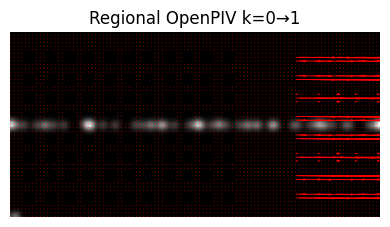

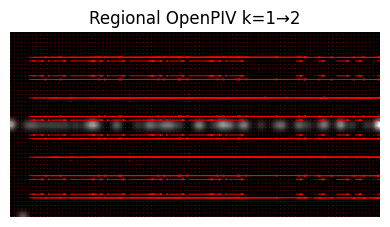

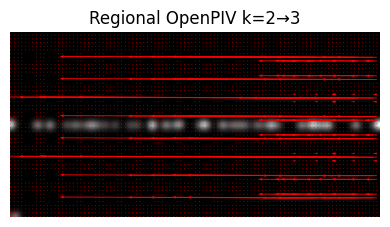

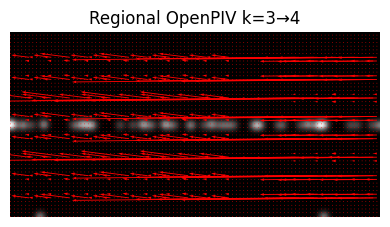

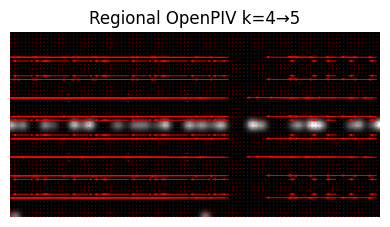

In [92]:
num_sensors = 60
WINDOW_LEN = 15
MAX_BASIS_DIM = 9
num_cv_folds = 3
TOTAL_STEPS = 20
PERIOD = 75

# double gyre
NX, NY = 300, 150
LX, LY = 2.0, 1.0
DT = 1
u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
                                A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 150, 150 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
# DT = 0.05 / U_max 
# # DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)


# NX, NY = 300, 300
# LX, LY = 2 * np.pi, 2 * np.pi
# DT = 1e-3
# u, v = generate_cfd_kolmogorov_flow(
#     n_timesteps=2000,
#     nx=NX, ny=NY,      
#     lx=LX, ly=LY,
#     dt=DT,              
#     nu=2e-2, 
#     forcing_amp=20.0, 
#     kf=4,
#     plot_series=False)
# sample_indices = np.linspace(1100, 1950, TOTAL_STEPS, dtype=int)
# u = u[sample_indices]
# v = v[sample_indices]

# k_skip = sample_indices[1] - sample_indices[0]  
# dt_advect = k_skip * DT  # delta t between stored frames


get_sensor_flow(u,v, LX, LY, DT, WINDOW_LEN, num_sensors, MAX_BASIS_DIM);

In [161]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pysensors as ps  # import your PySensors package

# ----------------- helpers -----------------
def _get_sliding_intervals(T, window_length, step):
    return [(s, s + window_length) for s in range(0, T - window_length + 1, step)]

def _fb_params_from_physics(nx, ny, lx, ly, dt, u_max, pyr_scale=0.5):
    """Pick Farnebäck params from a crude pixel jump estimate."""
    dx = lx / (nx - 1)
    disp_px = max(1.0, float(u_max) * float(dt) / dx)
    # choose pyramid depth so residual motion at coarsest ~<=3 px
    if disp_px <= 3:
        levels = 1
        residual = disp_px
    else:
        import math
        levels = int(math.ceil(1 + math.log(disp_px / 3.0, 1.0 / pyr_scale)))
        residual = disp_px * (pyr_scale ** (levels - 1))
    winsize = int(max(31, 2 * int(residual) + 1))
    if winsize % 2 == 0: winsize += 1
    poly_n = 5 if max(nx, ny) < 1000 else 7
    poly_sigma = 1.1 if poly_n == 5 else 1.5
    return dict(pyr_scale=pyr_scale, levels=levels, winsize=winsize,
                iterations=3, poly_n=poly_n, poly_sigma=poly_sigma,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

# ----------------- main API -----------------
def get_onept_energy_flow_psensors(
    u, v,                      # arrays (T, nx, ny)
    lx, ly, dt,                # domain + timestep (for OF params only)
    window_length=30, step_size=1,
    r=20,                      # n_basis_modes for SVD in SSPOR
    n_sensors=25,
    prior='decreasing',        # 'decreasing' | 'flat' (np.ones) | np.ndarray(len=r)
    noise=1.0,                 # same as your example
    mask_flat=None,            # optional boolean mask over FEATURES
    img_shape=None,            # optional shape to reshape masked image (e.g., (nx, ny) or (nx, ny, ?) )
    smooth_sigma_px=2.0,       # light pre-smoothing of energy map before OF
    normalize='minmax',        # 'minmax' | 'zscore' | None
    fb_params=None,            # optional dict for Farnebäck
    plot_every=0               # e.g., 1 to plot every pair
):
    """
    Compute 1-pt energy maps per window and optical flow between consecutive maps.

    Returns:
      energy_frames: (K, nx, ny) float32
      flows_px:      (K-1, nx, ny, 2) float32  # (u_px, v_px)
    """

    prior=np.ones(r)
    noise=1e-16
    
    T, nx, ny = u.shape
    # Build feature matrix by concatenating [u | v] along y (feature) axis
    data = np.concatenate([u, v], axis=2)         # (T, nx, 2*ny)
    F = nx * (2 * ny)

    intervals = _get_sliding_intervals(T, window_length, step_size)
    energy_frames = []
    sensors_list = []

    for (s, e) in intervals:
        # X shape (window_len, F); zero-mean per feature over this window
        X = data[s:e].reshape(e - s, F).astype(np.float64)
        X -= X.mean(axis=0, keepdims=True)

        # ----- YOUR EXACT API: fit SSPOR(TPGR) & compute 1-pt energy -----
        model = ps.SSPOR(
            basis=ps.basis.SVD(n_basis_modes=r),
            optimizer=ps.optimizers.TPGR(n_sensors=n_sensors, noise=noise, prior=prior)
        )
        model.fit(X)
        sensors = model.get_selected_sensors()                    # (indices in FEATURE space)
        sensors_list.append(np.asarray(sensors, dtype=int))

        one_point_energy = model.one_pt_energy_landscape(prior=prior, noise=noise)  # (F,)

        # ----- map the vector back to an (nx, ny) image -----
        if mask_flat is not None and img_shape is not None:
            # Use your mask-based placement (like in your snippet)
            # mask_flat is boolean array of length equal to number of features consumed by SSPOR
            img = np.zeros(int(np.prod(img_shape)), dtype=np.float32)
            img[mask_flat] = one_point_energy.astype(np.float32)
            frame = img.reshape(img_shape)
            # If img_shape is (nx, ny, 2) or similar, pick a channel or reduce as needed:
            if frame.ndim == 3 and frame.shape[-1] == 2:
                frame = frame[..., 0] * 0.5 + frame[..., 1] * 0.5  # average u/v channels
        else:
            # No mask: features are [u(0..nx*ny-1), v(0..nx*ny-1)] → average to grid
            e_u = one_point_energy[:nx * ny].reshape(nx, ny)
            e_v = one_point_energy[nx * ny:].reshape(nx, ny)
            frame = 0.5 * (e_u + e_v)

        # normalize & smooth (helps optical flow “brightness constancy”)
        A = frame.astype(np.float32)
        if normalize == 'minmax':
            lo, hi = np.percentile(A, 2), np.percentile(A, 98)
            A = (A - lo) / (hi - lo + 1e-12)
            A = np.clip(A, 0, 1)
        elif normalize == 'zscore':
            mu, sd = A.mean(), A.std() + 1e-12
            A = (A - mu) / sd
        if smooth_sigma_px and smooth_sigma_px > 0:
            A = gaussian_filter(A, sigma=smooth_sigma_px)

        energy_frames.append(A)

    energy_frames = np.stack(energy_frames, axis=0)  # (K, nx, ny)

    # ----- optical flow on consecutive energy maps -----
    if fb_params is None:
        u_max = float(np.nanmax(np.hypot(u, v)))
        fb_params = _fb_params_from_physics(nx, ny, lx, ly, dt, u_max)

    flows = []
    for k in range(len(energy_frames) - 1):
        f0 = energy_frames[k].T.astype(np.float32)     # (ny, nx)
        f1 = energy_frames[k + 1].T.astype(np.float32)
        flow = cv2.calcOpticalFlowFarneback(f0, f1, None, **fb_params)  # (ny, nx, 2)
        flows.append(flow.transpose(1, 0, 2))          # → (nx, ny, 2)

    flows_px = np.stack(flows, axis=0) if flows else np.zeros((0, nx, ny, 2), np.float32)

    # ----- optional quick viz like your colorbar plot -----
    if plot_every and plot_every > 0:
        num_plots = int(np.ceil(len(energy_frames) / plot_every))
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 4))
        if num_plots == 1: axes = [axes]
        for i in range(num_plots):
            k = min(i * plot_every, len(energy_frames) - 1)
            ax = axes[i]
            img_show = ax.imshow(energy_frames[k].T, origin='lower', cmap=plt.cm.PuBu_r)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(f'One-Point Energy (window {k})')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(img_show, cax=cax)
        plt.tight_layout(); plt.show()

        # quiver of drift on top of the first few frames
        if len(flows_px) > 0:
            step = max(1, min(nx, ny)//40)
            n_quiv = min(num_plots, len(flows_px))
            fig, axes = plt.subplots(1, n_quiv, figsize=(5 * n_quiv, 4))
            if n_quiv == 1: axes = [axes]
            for i in range(n_quiv):
                ax = axes[i]
                ax.imshow(energy_frames[i].T, origin='lower', cmap=plt.cm.PuBu_r)
                Xg, Yg = np.meshgrid(np.arange(0, nx, step), np.arange(0, ny, step), indexing='ij')
                U = flows_px[i][::step, ::step, 0]; V = flows_px[i][::step, ::step, 1]
                ax.quiver(Xg, Yg, U, V, color='black', angles='xy', scale_units='xy', scale=None)
                ax.set_title(f'1-pt energy drift, window {i}→{i+1}')
                ax.set_xticks([]); ax.set_yticks([])
            plt.tight_layout(); plt.show()

    return energy_frames, flows_px, sensors_list

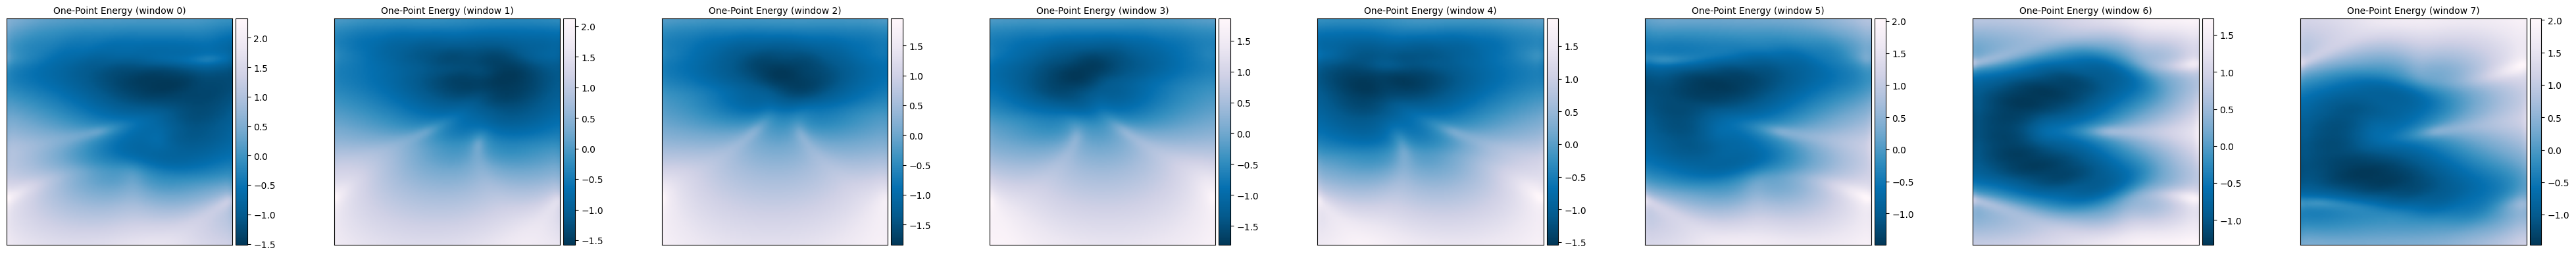

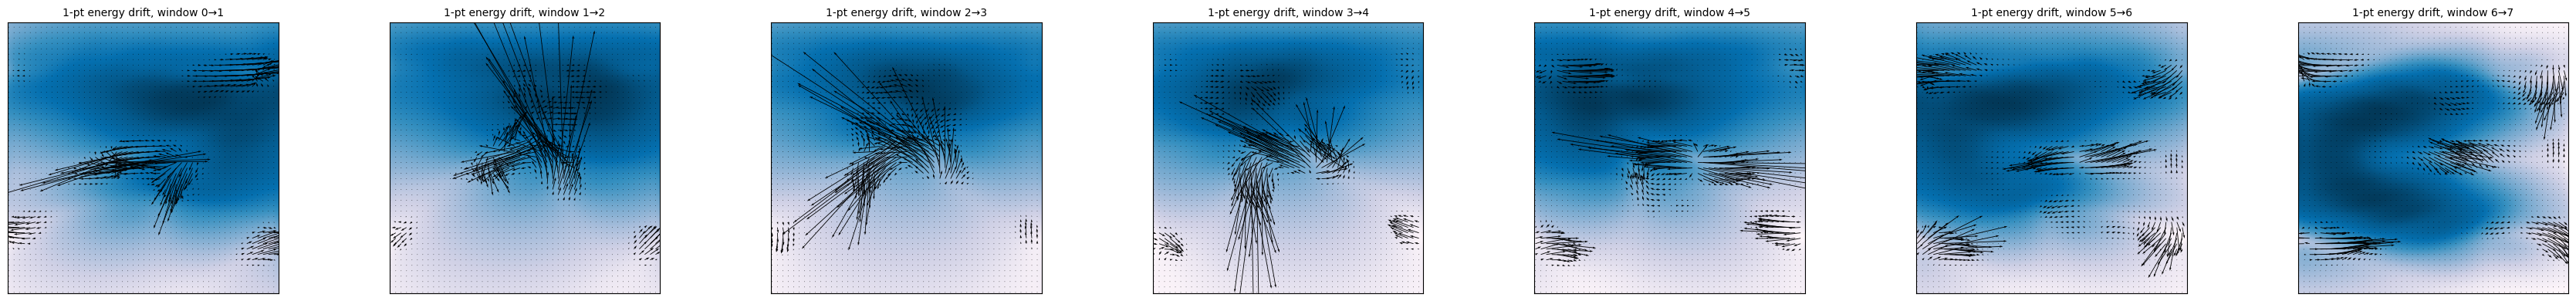

In [163]:
num_sensors = 20
WINDOW_LEN = 15
MAX_BASIS_DIM = 10
num_cv_folds = 3
TOTAL_STEPS = 50
PERIOD = 75

# # double gyre
# NX, NY = 300, 150
# LX, LY = 2.0, 1.0
# DT = 1
# u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
#                                 A=0.1, epsilon=0.5, period=PERIOD)

# moving vortex
NX, NY = 150, 150 # number of grid points along each axis
LX, LY = 1, 1 # changeable
U_max = 1.02 # maximum velocity in the flow -- gotten by look at data
DT = 0.05 / U_max 
# DT = 5 * (0.3 * 2 * np.pi) / (PERIOD * U_max)  # 0.3 is radius of vortex from center
u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)


# NX, NY = 300, 300
# LX, LY = 2 * np.pi, 2 * np.pi
# DT = 1e-3
# u, v = generate_cfd_kolmogorov_flow(
#     n_timesteps=2000,
#     nx=NX, ny=NY,      
#     lx=LX, ly=LY,
#     dt=DT,              
#     nu=2e-2, 
#     forcing_amp=20.0, 
#     kf=4,
#     plot_series=False)
# sample_indices = np.linspace(1500, 1950, TOTAL_STEPS, dtype=int)
# u = u[sample_indices]
# v = v[sample_indices]

# k_skip = sample_indices[1] - sample_indices[0]  
# dt_advect = k_skip * DT  # delta t between stored frames


# pick the SAME r, prior_mode, noise across time
_ = get_onept_energy_flow_psensors(
    u, v, LX, LY, DT,
    window_length=WINDOW_LEN, step_size=5,
    r=MAX_BASIS_DIM,
    smooth_sigma_px=2.0,
    normalize='zscore',
    # fb_params=None,
    plot_every=1
)
